In [14]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForCausalLM, BlipForQuestionAnswering
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

https://gist.github.com/iamaziz/171170dce60d9cd07fab221507fd1d52

In [15]:
batch_size=4

In [119]:
df = pd.read_csv(r'./Data/metadata_pre_+_BLIP.csv')
train_df=df[df['Image'].str.contains('train')]
val_df=df[df['Image'].str.contains('val')]
test_df=df[df['Image'].str.contains('test')]
train_df.shape[0]+val_df.shape[0]+test_df.shape[0]

32632

In [24]:
padding_len = 256

class VQAdata(Dataset):
  def __init__(self, df, processor):
    self.df = df
    self.processor = processor

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    img_path = self.df['File_Name'].tolist()[idx]
    #img_path = os.path.join("/content/drive/MyDrive/AI_final_project",img_path)
    img = Image.open(img_path).convert("RGB")
    que = self.df['Question'].tolist()[idx]
    ans = self.df['Answer'].tolist()[idx]

    encoding = self.processor(images=img, text=que, max_length= padding_len, padding="max_length", return_tensors="pt")
    ans_encode=self.processor.tokenizer.encode(ans,max_length= padding_len, padding="max_length", return_tensors="pt")

    # remove batch dimension
    encoding = {k:v.squeeze() for k,v in encoding.items()}

    return encoding, ans_encode, que, ans

In [22]:
df

Image                                           Question  \
0      train_0422   Where are liver stem cells (oval cells) located?   
1      train_0422  What are stained here with an immunohistochemi...   
2      train_0422  What are bile duct cells and canals of Hering ...   
3      train_0422  Are bile duct cells and canals of Hering stain...   
4      train_0986              What shows dissolution of the tissue?   
...           ...                                                ...   
32627   test_0648                                   What is present?   
32628   test_0648                                 Is kidney present?   
32629   test_0648                                   What is present?   
32630   test_0648                            Is sarcoidosis present?   
32631   test_0648                                     Where is this?   

                                     Answer                   File_Name  \
0                   in the canals of hering  ./Data/Images/img_0001.jpg   
1      bile duct cells and canals of hering  ./Data/Images/img_0001.jpg   
2              an immunohistochemical stain  ./Data/Images/img_0001.jpg   
3                                       yes  ./Data/Images/img_0001.jpg   
4                   an infarct in the brain  ./Data/Images/img_0002.jpg   
...                                     ...                         ...   
32627                                kidney  ./Data/Images/img_4289.jpg   
32628                                   yes  ./Data/Images/img_4289.jpg   
32629                           sarcoidosis  ./Data/Images/img_4289.jpg   
32630                                   yes  ./Data/Images/img_4289.jpg   
32631                               urinary  ./Data/Images/img_4289.jpg   

                GIT                 LXMERT  \
0      unanswerable              t i t l e   
1      unanswerable            f o r g o t   
2                12            f o r g o t   
3               yes          r o l l i n g   
4         ice cream                      之   
...             ...                    ...   
32627  unanswerable      s p o n s o r e d   
32628           yes            f o r g o t   
32629  unanswerable      s p o n s o r e d   
32630           yes          r o l l i n g   
32631  unanswerable  c o m p i l a t i o n   

                                              Pix2Struct     ViLT  
0                                                      +  nowhere  
1                                                    0.5  nothing  
2                                                 Hering      oil  
3      Hering stained here with an immunohistochemica...      yes  
4                                            Dissolution  plastic  
...                                                  ...      ...  
32627                                            Present   apples  
32628                                     Kidney present       no  
32629                                            Present   apples  
32630                                        Sarcoidosis       no  
32631                                             Kansas  outside  

[32632 rows x 8 columns]

In [25]:
test_dataset = VQAdata(test_df, processor)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [114]:
from collections import defaultdict
import re
import math
def split_sentence(sentence, n):
    words = defaultdict(int)
    tmp_sentence = re.sub("[^a-zA-Z ]", "", sentence)
    tmp_sentence = tmp_sentence.lower()
    tmp_sentence = tmp_sentence.strip().split()
    length = len(tmp_sentence)
    for i in range(length - n + 1):
        tmp_words = " ".join(tmp_sentence[i: i + n])
        if tmp_words:
            words[tmp_words] += 1
    return words

def brevity_penalty(candidate, references):
    c = len(candidate)
    ref_lens = (len(reference) for reference in references)
    r = min(ref_lens, key=lambda ref_len: (abs(ref_len - c), ref_len))
    
    if c > r:
        return 1
    else:
        return math.exp(1 - r / c)

def modified_precision(candidate, references, n):
    max_frequency = defaultdict(int)
    min_frequency = defaultdict(int)
    
    candidate_words = split_sentence(candidate, n)
    
    for reference in references:
        reference_words = split_sentence(reference, n)
        for word in candidate_words:
            max_frequency[word] = max(max_frequency[word], reference_words[word])
    for word in candidate_words:
            min_frequency[word] = min(max_frequency[word], candidate_words[word])
    P = sum(min_frequency.values()) / sum(candidate_words.values())
    return P

def bleu(candidate, references, n, weights):

    pn = []
    bp = brevity_penalty(candidate, references)
    for i in range(n):
        pn.append(modified_precision(candidate, references, i + 1))
    if len(weights) > len(pn):
        tmp_weights = []
        for i in range(len(pn)):
            tmp_weights.append(weights[i])
        bleu_result = calculate_bleu(tmp_weights, pn, n, bp)
        return str(bleu_result) + " (warning: the length of weights is bigger than n)"
    elif len(weights) < len(pn):
        tmp_weights = []
        for i in range(len(pn)):
            tmp_weights.append(0)
        for i in range(len(weights)):
            tmp_weights[i] = weights[i]
        bleu_result = calculate_bleu(tmp_weights, pn, n, bp)
        return str(bleu_result) + " (warning: the length of weights is smaller than n)"
    else:
        bleu_result = calculate_bleu(weights, pn, n, bp)
        return str(bleu_result)

#BLEU
def calculate_bleu(weights, pn, n, bp):
    sum_wlogp = 0
    for i in range(n):
        if pn[i] != 0:
            sum_wlogp += float(weights[i]) * math.log(pn[i])
    bleu_result = bp * math.exp(sum_wlogp)
    return bleu_result


def calculate_f1score(candidate, reference):
    candidate_words = split_sentence(candidate, 1)
    reference_words = split_sentence(reference, 1)
    word_set = set()
    for word in candidate_words:
        word_set.add(word)
    for word in reference_words:
        word_set.add(word)
    
    tp = 0
    fp = 0
    fn = 0
    for word in word_set:
        if word in candidate_words and word in reference_words:
            tp += candidate_words[word]
        elif word in candidate_words and word not in reference_words:
            fp += candidate_words[word]
        elif word not in candidate_words and word in reference_words:
            fn += reference_words[word]
    
    if len(candidate_words) == 0:
        return 0
    elif len(reference_words) == 0:
        return 0
    else:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        if tp == 0:
            return 0
        else:
            return 2 * precision * recall / (precision + recall)
def calculate_exactmatch(candidate, reference):
    candidate_words = split_sentence(candidate, 1)
    reference_words = split_sentence(reference, 1)
    count = 0
    total = 0
    for word in reference_words:
        if word in candidate_words:
            count += 1
    for word in candidate_words:
        total += candidate_words[word]
        
    if total == 0:
        return 0
    else:
        return count / total

In [83]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader, Subset

processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")
test_dataset = VQAdata(test_df, processor)
#test_dataset = Subset(test_dataset, range(50))

def predict(model,tokenizer):
    f1_total, exact, bleu_1, bleu_2, bleu_3 = 0.0, 0.0, 0.0, 0.0, 0.0
    idx=0
    model.eval()
    with torch.no_grad():
        test_loss=0.0
        for batch in test_dataset:
                #print(batch[1:])
                input_ids, attention_mask, pixel_values = batch[0]['input_ids'].unsqueeze(0).to('cuda'), batch[0]['attention_mask'].unsqueeze(0).to('cuda'), batch[0]['pixel_values'].unsqueeze(0).to('cuda')
                labels = batch[1].to('cuda')
                que=batch[2]
                ans = batch[3]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, labels = labels)
                test_loss += outputs.loss.item()
                predicted_token_ids = torch.argmax(outputs.logits, dim=-1).tolist()

                # Decode the predicted token IDs
                generated_tokens = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)[0]
            
                print('Question:', que)
                print('Answer:',ans)
                print('Before Training:',test_df['GIT'].tolist()[idx])
                print("Predicted:", generated_tokens)
                idx+=1
            
                input_ids = processor(text=que, add_special_tokens=False).input_ids
                input_ids = [processor.tokenizer.cls_token_id] + input_ids
                input_ids = torch.tensor(input_ids).unsqueeze(0).to('cuda')
                
                f1_total+=calculate_f1score(generated_tokens, ans)
                exact+=calculate_exactmatch(generated_tokens, ans)

                print('f1:',calculate_f1score(generated_tokens, ans))
                print('exact:',calculate_exactmatch(generated_tokens, ans))
   
                print()
                print('***************************')
        
    return f1_total/len(test_dataset), exact/len(test_dataset)

In [129]:
processor

GitProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 480,
    "width": 480
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "GitProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 480
  }
}

- tokenizer: BertTokenizerFast(name_or_path='microsoft/git-base-textvqa', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [81]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/git-base-textvqa")
res=[]
for i in range(25):
    model = AutoModelForCausalLM.from_pretrained(f"D:\Dropbox\Yueh\YU\Artificial_Intelligence\Final_Project\AI_Final_Project_Code\Code\Test2\GIT_textvqa_model_v2_epo{i}").to('cuda')
    res.append(predict(model,tokenizer))

Question: What are positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: the histone subunits
Before Training: answering does not require reading text in the image
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How are the histone subunits charged?
Answer: positively charged
Before Training: answering does not require reading text in the image
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Are the histone subunits positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What are illustrated?
Answer: the principal cellular alterations that characterize reversible cell injury and necrosis
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Are the principal cellular alterations that characterize reversible cell injury and necrosis i

Question: What is characterized by vasodilation, congestion, and edema?
Answer: the immediate reaction
Before Training: foot
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What is the immediate reaction characterized by?
Answer: vasodilation
Before Training: foot
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is the immediate reaction characterized by an inflammatory infiltrate rich in eosinophils, neutrophils, and T cells?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What shows several multinucleate giant cells?
Answer: the granuloma
Before Training: gimp
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What does the granuloma in the center show?
Answer: multinucleate giant cells
Before Training: gimp
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Does the granuloma in the center show several multinucleate giant cells?
Answer: yes
Before 

Question: What overlies white fibrous scar?
Answer: thrombus
Before Training: measuring
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What does thrombus in the left and right ventricular apices overlie?
Answer: white fibrous scar
Before Training: measuring
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Does thrombus in the left and right ventricular apices overlie white fibrous scar?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Did the areas of white chalky deposits overlie white fibrous scar?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What are super-imposed on advanced atherosclerotic lesions of the more proximal aorta (left side of photograph)?
Answer: friable mural thrombi
Before Training: price
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Are numerous friable mural thrombi super-imposed on adva

Question: Was the injurious stimulus removed for postpartum bleeding?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: an area of central necrosis
Before Training: bullet
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does typical tuberculous granuloma show?
Answer: an area of central necrosis
Before Training: flecks
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is an area of central necrosis surrounded by?
Answer: multiple multinucleate giant cells
Before Training: flakes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Dose typical tuberculous granuloma show an area of central necrosis surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

**************

Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are shown?
Answer: apoptotic cells in colonic epithelium
Before Training: holes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Are apoptotic cells in colonic epithelium shown?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are the areas of white chalky deposits shown?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What was removed for postpartum bleeding?
Answer: a gravid uterus
Before Training: head
Predicted: yes of
f1: 0
exact: 0.0

***************************
Question: What was a gravid uterus removed for?
Answer: postpartum bleeding
Before Training: head
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Was a gravid uterus removed for postpartum ble

Question: How does the wall of the artery show a circumferential bright pink area of necrosis?
Answer: with protein deposition and inflammation
Before Training: yes
Predicted: no bodies
f1: 0
exact: 0.0

***************************
Question: Does the wall of the artery show a circumferential bright pink area of necrosis with protein deposition and inflammation?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What are illustrated?
Answer: the cellular alterations in apoptosis are illustrated
Before Training: unanswerable
Predicted: no zones
f1: 0
exact: 0.0

***************************
Question: Are the cellular alterations in apoptosis illustrated?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What are shown?
Answe

f1: 0
exact: 0.0

***************************
Question: Do the necrotic cells show preserved outlines with loss of nuclei?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do skin stem cells show preserved outlines with loss of nuclei?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows a circumferential bright pink area of necrosis with protein deposition and inflammation?
Answer: the wall of the artery
Before Training: red blood
Predicted: yesrographgraph
f1: 0
exact: 0.0

***************************
Question: What does the wall of the artery show with protein deposition and inflammation?
Answer: a circumferential bright pink area of necrosis
Before Training: red
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How does the wall of the artery show a circumferential bright pink area of necrosis?
Answer: with protein deposition and inflammation
Be

Question: What is showing increased eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: early (reversible) ischemic injury
Before Training: unanswerable
Predicted: no of
f1: 0
exact: 0.0

***************************
Question: What does ischemic injury show?
Answer: surface blebs
Before Training: unanswerable
Predicted: noers the
f1: 0
exact: 0.0

***************************
Question: Does early ischemic injury show surface blebs, increase eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Do necrotic cells show preserved outlines with loss of nuclei, and an inflammatory infiltrate is present (difficult to discern at this magnification)?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are the preserved outlines with loss of nuclei?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***

Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is considered to culminate in necrosis if the injurious stimulus is not removed, by convention?
Answer: reversible injury
Before Training: unanswerable
Predicted: nolat the
f1: 0
exact: 0.0

***************************
Question: How is reversible injury considered to do if the injurious stimulus is not removed, by convention?
Answer: culminate in necrosis
Before Training: unanswerable
Predicted: no this
f1: 0
exact: 0.0

***************************
Question: Is reversible injury considered to culminate in necrosis if the injurious stimulus is not removed by convention?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Did early (reversible) ischemic injury increase eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: no
Before Training: yes
P

Question: Does the granuloma in the center show several multinucleate giant cells?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What are positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: the histone subunits
Before Training: answering does not require reading text in the image
Predicted: no of the cells
f1: 0.28571428571428575
exact: 0.25

***************************
Question: How are the histone subunits charged?
Answer: positively charged
Before Training: answering does not require reading text in the image
Predicted: no and
f1: 0
exact: 0.0

***************************
Question: Are the histone subunits positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What are illustrated?
Answer: the principal cellular alterations that characterize reversible cell injury a

Question: What is showing increased eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: early (reversible) ischemic injury
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does ischemic injury show?
Answer: surface blebs
Before Training: unanswerable
Predicted: yesible injury
f1: 0
exact: 0.0

***************************
Question: Does early ischemic injury show surface blebs, increase eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do necrotic cells show preserved outlines with loss of nuclei, and an inflammatory infiltrate is present (difficult to discern at this magnification)?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are the preserved outlines with loss of nuclei?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.

Question: Are apoptotic cells in colonic epithelium shown?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

Question: Is the immediate reaction characterized by an inflammatory infiltrate rich in eosinophils, neutrophils, and T cells?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Question: What is showing increased eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: early (reversible) ischemic injury
Before Training: unanswerable
Predicted: yessculat of
f1: 0
exact: 0.0

***************************
Question: What does ischemic injury show?
Answer: surface blebs
Before Training: unanswerable
Predicted: yesscuible injury
f1: 0
exact: 0.0

***************************
Question: Does early ischemic injury show surface blebs, increase eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do necrotic cells show preserved outlines with loss of nuclei, and an inflammatory infiltrate is present (difficult to discern at this magnification)?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are the preserved outlines with loss of nuclei?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1

Question: Is an area of central necrosis surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: yes
Before Training: the human
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What overlies white fibrous scar?
Answer: thrombus
Before Training: measuring
Predicted: of of of of of yesgraph
f1: 0
exact: 0.0

***************************
Question: What does thrombus in the left and right ventricular apices overlie?
Answer: white fibrous scar
Before Training: measuring
Predicted: of of of of of yesc congestion and
f1: 0
exact: 0.0

***************************
Question: Does thrombus in the left and right ventricular apices overlie white fibrous scar?
Answer: yes
Before Training: yes
Predicted: of of of of of yes
f1: 0.2857142857142857
exact: 0.16666666666666666

***************************
Question: Did the areas of white chalky deposits overlie white fibrous scar?
Answer: no
Before Training: yes
Predicted: of of of of of yes
f1:

Question: What are positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: the histone subunits
Before Training: answering does not require reading text in the image
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the by the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Question: What is showing increased eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: early (reversible) ischemic injury
Before Training: unanswerable
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Question: What are shown?
Answer: apoptotic cells in colonic epithelium
Before Training: holes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Question: Is the immediate reaction characterized by an inflammatory infiltrate rich in eosinophils, neutrophils, and T cells?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Question: What show preserved outlines with loss of nuclei?
Answer: the necrotic cells
Before Training: fleurette
Predicted: yes ofpa cells in
f1: 0.28571428571428575
exact: 0.25

***************************
Question: Do the necrotic cells show preserved outlines with loss of nuclei?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do skin stem cells show preserved outlines with loss of nuclei?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows a circumferential bright pink area of necrosis with protein deposition and inflammation?
Answer: the wall of the artery
Before Training: red blood
Predicted: with with the the the with the the with the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the with the the with the the the the the the the the the with the the with the the the the the the the the t

Question: What was a gravid uterus removed for?
Answer: postpartum bleeding
Before Training: head
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Was a gravid uterus removed for postpartum bleeding?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Was the injurious stimulus removed for postpartum bleeding?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: an area of central necrosis
Before Training: bullet
Predicted: cells cells cells cells of of of cells of cells cells of cells of of cells of of cells cells cells cells of cells cells of cells cells of of of of cells cells of of of of cells of cells cells of of of of cells cells cells cells of of cells of of of of cells of of of of of of cells of of of of of cells of of of of of of of of of cells of cells of

Question: Does the granuloma in the center show several multinucleate giant cells?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0.025641025641025647
exact: 0.012987012987012988

***************************
Question: What are positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: the histone subunits
Before Training: answering does not require reading text in the image
Predicted: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a the the a a a a a a a a a a a a a a a a a a a a a a a a the a a a a a a a by the the a a a a a a a the the cut a a a a a the the the the c

Question: How does the wall of the artery show a circumferential bright pink area of necrosis?
Answer: with protein deposition and inflammation
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with the with the with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with the with with with with with with with with the with with with with the with with with with with with with with with of the with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with of with with with with with with with with with with with with with with with with with

Question: Dose typical tuberculous granuloma show an area of central necrosis surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of 

Question: Are the principal cellular alterations that characterize reversible cell injury and necrosis illustrated?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of by by of of of of of of of of of of of of of of of of of of of of the the the the the the of of of of of of of of of of of of of of of the of of of of of of of of of of of of of the of of of of of of of of of of of of of of the the of of of of of of of of of of of of of the the the by by the of of of of of of of of of of of the of of of of of of of of of of by of of of of of of of of of of of of of of of of of of of of of the of of of of of of of of of of of of the the of of of of of of of of of of of the the of of of of of of of of of of of of of of of of of of of of of of of of the the of of of

Question: Is reversible injury considered to culminate in necrosis if the injurious stimulus is not removed by convention?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of by by of of of of of of of of of of of of of of of of of of of of the the the the the the of of of of of of of of of of of of of of of the of of of of of of of of of of of of of the of of of of of of of of of of of of of of the the of of of of of of of of of of of of of the the the by by the of of of of of of of of of of of the of of of of of of of of of of by of of of of of of of of of of of of of of of of of of of of of the of of of of of of of of of of of of the the of of of of of of of of of of of the the of of of of of of of of of of of of of of of of of of of of of of of of the the o

Question: Are the cellular alterations in apoptosis illustrated?
Answer: yes
Before Training: yes
Predicted: of of of of of of theccc the thec of of of of of of of of of of of of theccc the the the of of of of of of of of of of of of of the by by of of of by the the of of of of of of of of of thec of by of thec the the of of of of of of of of byc of by of of by by of of of of of of of of of thec the of of the of of of of of of thec by thec the of of of of of of of of of of of of ofcccccccc of of of of of of of ofcc muc of of of of of of of of the ofc the of of of of of of of ofc the of of of of of of of ofcccc of of of of of of of of ofccc the of of of of of of of of the the of of of of of of of of of the the of of the of the the the of of of of of of of of of of of of of of of the of of of of of of of of of of of of of of of of of of of of of of of by of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of 

Question: What does thrombus in the left and right ventricular apices overlie?
Answer: white fibrous scar
Before Training: measuring
Predicted: yesc congestion and
f1: 0
exact: 0.0

***************************
Question: Does thrombus in the left and right ventricular apices overlie white fibrous scar?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Did the areas of white chalky deposits overlie white fibrous scar?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are super-imposed on advanced atherosclerotic lesions of the more proximal aorta (left side of photograph)?
Answer: friable mural thrombi
Before Training: price
Predicted: yes -umatic sq andals
f1: 0
exact: 0.0

***************************
Question: Are numerous friable mural thrombi super-imposed on advanced atherosclerotic lesions of the more proximal aorta (left side of photograph)?
Answer: yes
Before Training

Question: What does the granuloma in the center show?
Answer: multinucleate giant cells
Before Training: gimp
Predicted: yesocmous gran cells
f1: 0.3333333333333333
exact: 0.3333333333333333

***************************
Question: Does the granuloma in the center show several multinucleate giant cells?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What are positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: the histone subunits
Before Training: answering does not require reading text in the image
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the theal the the the the the the th

Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Question: What is showing increased eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: early (reversible) ischemic injury
Before Training: unanswerable
Predicted: yes of
f1: 0
exact: 0.0

***************************
Question: What does ischemic injury show?
Answer: surface blebs
Before Training: unanswerable
Predicted: yes ofaticers the
f1: 0
exact: 0.0

***************************
Question: Does early ischemic injury show surface blebs, increase eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do necrotic cells show preserved outlines with loss of nuclei, and an inflammatory infiltrate is present (difficult to discern at this magnification)?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are the preserved outlines with loss of nuclei?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exa

Question: What are shown?
Answer: apoptotic cells in colonic epithelium
Before Training: holes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Question: What is the immediate reaction characterized by?
Answer: vasodilation
Before Training: foot
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

f1: 0
exact: 0.0

***************************
Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is considered to culminate in necrosis if the injurious stimulus is not removed, by convention?
Answer: reversible injury
Before Training: unanswerable
Predicted: no cells in -
f1: 0
exact: 0.0

***************************
Question: How is reversible injury considered to do if the injurious stimulus is not removed, by convention?
Answer: culminate in necrosis
Before Training: unanswerable
Predicted: no found
f1: 0
exact: 0.0

***************************
Question: Is reversible injury considered to culminate in necrosis if the injurious stimulus is not removed by convention?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Did early (reversible) ischemic injury increase eosinophilia of cytoplasm, and swelling of 

Question: Are the areas of white chalky deposits shown?
Answer: no
Before Training: yes
Predicted: the the the the the the the the a the the a the the the the a the the the the the the the the the the the the the a a a the the the the the the the the the the the the the the the the the the a the the the the the the the the the the the the the the the the the the a the the the the a the a the the the the the the the the a the the the the the the the the the the the a the the the the a a the the the a the the the the the the the the the the the the the the the the a the the the the the the the the the the a the a the the the the the the a the the the a the the the the the the the the the the the a the the the the the the the the the the a the the the the the the the the the the the a the the the the the the the the the the a a the the the the the the the the a the the the the the the the the the the the a the a the the the the the the the the the the a the the a a the the the the the the

Question: Are the principal cellular alterations that characterize reversible cell injury and necrosis illustrated?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

Question: Is reversible injury considered to culminate in necrosis if the injurious stimulus is not removed by convention?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

Question: How does the wall of the artery show a circumferential bright pink area of necrosis?
Answer: with protein deposition and inflammation
Before Training: yes
Predicted: after afterbubu after red thebububu thebubububu redbu the red the after thebu red after red red the withbubu the withbu redbu the red the red red red redbu after the after red red red with red with with after afterbu red red red afterbu after redbu with after afterbubu afterbu the after redbu redbu red afterbububububububu afterbubububu after withbububu redbubububu after with afterbubububu after afterbu after redbububu red thebububu with with red afterbu withbubu red after red the after with after redbububububu the after red after red red afterbububu red afterbu red redbubu after red red red with with red after red after with the after after red thebubu with with withbu afterbu redbu after with red after red cells afterbu with with red red the red with redbu red red after with with withbu after red thebu after red

Question: Was a gravid uterus removed for postpartum bleeding?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Was the injurious stimulus removed for postpartum bleeding?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: an area of central necrosis
Before Training: bullet
Predicted: norine tissue ur
f1: 0
exact: 0.0

***************************
Question: What does typical tuberculous granuloma show?
Answer: an area of central necrosis
Before Training: flecks
Predicted: no distribution
f1: 0
exact: 0.0

***************************
Question: What is an area of central necrosis surrounded by?
Answer: multiple multinucleate giant cells
Before Training: flakes
Predicted: norine
f1: 0
exact: 0.0

***************************
Question: Dose typical tuberculous granuloma show an area o

Question: What are positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: the histone subunits
Before Training: answering does not require reading text in the image
Predicted: no cy of the cells sp
f1: 0.2222222222222222
exact: 0.16666666666666666

***************************
Question: How are the histone subunits charged?
Answer: positively charged
Before Training: answering does not require reading text in the image
Predicted: no and prominent
f1: 0
exact: 0.0

***************************
Question: Are the histone subunits positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What are illustrated?
Answer: the principal cellular alterations that characterize reversible cell injury and necrosis
Before Training: unanswerable
Predicted: no of cancer zones
f1: 0
exact: 0.0

***************************
Question: Are the principal 

Question: Are the cellular alterations in apoptosis illustrated?
Answer: yes
Before Training: yes
Predicted: ##ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc no
f1: 0
exact: 0.0

***************************
Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: ##ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

Question: Are the principal cellular alterations that characterize reversible cell injury and necrosis illustrated?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

Question: Is reversible injury considered to culminate in necrosis if the injurious stimulus is not removed by convention?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

f1: 1.0
exact: 1.0

***************************
Question: Are the preserved outlines with loss of nuclei?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What show preserved outlines with loss of nuclei?
Answer: the necrotic cells
Before Training: fleurette
Predicted: yes debris areas have at
f1: 0
exact: 0.0

***************************
Question: Do the necrotic cells show preserved outlines with loss of nuclei?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do skin stem cells show preserved outlines with loss of nuclei?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows a circumferential bright pink area of necrosis with protein deposition and inflammation?
Answer: the wall of the artery
Before Training: red blood
Predicted: the the the the the the the the the the the the the the the the the the the the the

Question: Are the areas of white chalky deposits shown?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the a the the the the the the the the the the a the a the the the the the the the the the the the the the a a the the the the the the the the a a the the the the the the the the the the the the a the the the the the a the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the a the the the the a the the the a the a the the the the the a the the the the a a the the the the the a a the a the the the the the the a the the the the the the the the a the the a the the the the the the the the the the the the the the the the the the the the the the the the the the the a the the the the the the a a the the the the the the the the the the the the the the a the the the the the the the the the the the the the the the the the the the the the a the a the a the the the the the the the the the the the

f1: 0
exact: 0.0

***************************
Question: What does the granuloma in the center show?
Answer: multinucleate giant cells
Before Training: gimp
Predicted: nomous gran cells
f1: 0.3333333333333333
exact: 0.3333333333333333

***************************
Question: Does the granuloma in the center show several multinucleate giant cells?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What are positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: the histone subunits
Before Training: answering does not require reading text in the image
Predicted: ##aaaaaaaaaaaaaaaa with with the withaa with with the the with withaa the the with with withaaaaa the the the the with with withaaa with the the the with with with with with with withaa the the the with with witha the the the with witha with the the with a with aaa the the the withaaaaaa the the the theaa the the the the withaaa the the the theaaaa t

Question: Are the preserved outlines with loss of nuclei?
Answer: yes
Before Training: yes
Predicted: spin spin spin a a a spin spin spin spin spin a a spin spin spin a spin spin spin spin spin a spin a spin spin spin spin spin spin a a spin spin a spin spin a spin a a spin spin spin spin spin spin a a a spin spin spin spin a a spin spin a a a spin spin spin a spin a spin spin spin spin a spin spin spin spin a spin spin spin spin a a a a spin spin spin spin spin spin spin spin spin spin spin spin spin a spin spin spin a a spin spin a a a spin spin spin spin spin spin spin spin spin spin spin a spin spin a a spin spin spin a spin a spin spin spin a a spin spin spin spin spin spin spin spin spin spin spin spin a spin spin spin a spin spin a spin spin a a spin spin spin spin a spin spin a spin a a a a a a a spin a spin a a a spin a a spin spin spin a a a a a spin a spin a a spin spin spin spin spin spin a spin spin spin spin spin a a spin a spin spin spin spin a spin spin spin a spin a sp

Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are shown?
Answer: apoptotic cells in colonic epithelium
Before Training: holes
Predicted: the the the the cells the cells the the the cells the cells the the the the the the cells cells cells the the cells the the the cells cells cells the the the cells the the the the cells the the the cells cells cells cells the cells the the cells cells the cells cells the the cells cells the the the cells the the the cells the cells cells cells the the cells the the the the the the cells the the the cells the the cells cells cells the cells the cells the the the cells the the the the cells cells the the cells the the the the cells the cells cells the the the the the cells cells the the the the the the cells the cells cells the the the the the the the cells cells the the the the the the the the cells cells the the the cells

Question: What is an area of central necrosis surrounded by?
Answer: multiple multinucleate giant cells
Before Training: flakes
Predicted: yesinary
f1: 0
exact: 0.0

***************************
Question: Dose typical tuberculous granuloma show an area of central necrosis surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is an area of central necrosis surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: yes
Before Training: the human
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What overlies white fibrous scar?
Answer: thrombus
Before Training: measuring
Predicted: a a with a a a with a a a a a a a a a a a a a a a a a to of the largeousy
f1: 0
exact: 0.0

***************************
Question: What does thrombus in the left and right ventricular apices overlie?
Answer: white fibro

Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is considered to culminate in necrosis if the injurious stimulus is not removed, by convention?
Answer: reversible injury
Before Training: unanswerable
Predicted: yes cells an
f1: 0
exact: 0.0

***************************
Question: How is reversible injury considered to do if the injurious stimulus is not removed, by convention?
Answer: culminate in necrosis
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is reversible injury considered to culminate in necrosis if the injurious stimulus is not removed by convention?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Did early (reversible) ischemic injury increase eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: no
Before Training: yes


Question: Are apoptotic cells in colonic epithelium shown?
Answer: yes
Before Training: yes
Predicted: the the the the a a the the the the a a the the the a a a the the a a the a the a the a the the a a a the the a a a the the a a a a a a the a a a a a a the a a a the a a a a the the the a the a the the a the the the a a a the a the the the a a a a a the a the the the the the the a the the a a a the the the the the a the a the the the the the a the the a a a the the a a
f1: 0
exact: 0.0

***************************
Question: Are the areas of white chalky deposits shown?
Answer: no
Before Training: yes
Predicted: the the the the a a the the the the a a the the the a a a the the a a the a the a the a the the a a a the the a a a the the a a a a a a the a a a a a a the a a a the a a a a the the the a the a the the a the the the a a a the a the the the a a a a a the a the the the the the the a the the a a a the the the the the a the a the the the the the a the the a a a the the a a
f1: 0
ex

Question: What are super-imposed on advanced atherosclerotic lesions of the more proximal aorta (left side of photograph)?
Answer: friable mural thrombi
Before Training: price
Predicted: a at at at at at at a at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at the with with at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at the large ofumatictic andals of
f1: 0
exact: 0.0

***************************
Question: Are numerous friable mural thrombi super-imposed on advanced atherosclerotic lesions of the more proximal aorta (left side of photograph)?
Answer: yes
Before Training: unanswer
Predicted: a at at at at at at a at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at the with with at at at at at at at at at at at 

Question: Is reversible injury considered to culminate in necrosis if the injurious stimulus is not removed by convention?
Answer: yes
Before Training: yes
Predicted: normal normalaa normal normala normala yes
f1: 0.2857142857142857
exact: 0.16666666666666666

***************************
Question: Did early (reversible) ischemic injury increase eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the a the the the the the a the the the the the the a the the the the the the the the the the the the the the the the the a a a the the the the the the the the the the the the the the the the the the the the the the the a a the the the a the the the the the a the the the the the the the the the the the the the the the a the the the the the a the the the the the the the the a the the the the the the the a a the a the the the the the the the the the the the the the the t

Question: What shows a circumferential bright pink area of necrosis with protein deposition and inflammation?
Answer: the wall of the artery
Before Training: red blood
Predicted: ##sississississississississississississississis withsissis withsis ofsissississississis of withsis withsissis ofsississis ofsississis redsis ofsississississississis thesis assis with cellssississis of withsissississississis with thesis of withsissis of withsissississis insissississississis insissis cellssis of ofsis thesis insis ofsissis withsis in ofsissississis ofsissis ofsissis of insississississississississississississississis insississis of ofsissississississississississississississis with withsissis insississississis typesis type ofsississississississississississississississis withsissis with withsississis withsissis with with with with withsississississississis with with ofsis with withsississississis with with with withsissississississisbusissis withsississississississis with with withsissississississi

Question: What is surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: an area of central necrosis
Before Training: bullet
Predicted: of of with withulo no tissue
f1: 0.3333333333333333
exact: 0.16666666666666666

***************************
Question: What does typical tuberculous granuloma show?
Answer: an area of central necrosis
Before Training: flecks
Predicted: of of with withulo noma distribution
f1: 0.3333333333333333
exact: 0.16666666666666666

***************************
Question: What is an area of central necrosis surrounded by?
Answer: multiple multinucleate giant cells
Before Training: flakes
Predicted: of of with withulo no
f1: 0
exact: 0.0

***************************
Question: Dose typical tuberculous granuloma show an area of central necrosis surrounded by multiple multinucleate giant cells, epithelioid cells, and lymphocytes?
Answer: yes
Before Training: yes
Predicted: of of with withulo no
f1: 0
exact: 0.0

*******************

Question: Are the principal cellular alterations that characterize reversible cell injury and necrosis illustrated?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is considered to culminate in necrosis if the injurious stimulus is not removed, by convention?
Answer: reversible injury
Before Training: unanswerable
Predicted: no of
f1: 0
exact: 0.0

***************************
Question: How is reversible injury considered to do if the injurious stimulus is not removed, by convention?
Answer: culminate in necrosis
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is reversible injury considered to culminate in necrosis if the injurious stimulus is not removed by convention?
Answer: yes
Before Training: yes
Predicted: n

Question: Do skin stem cells show preserved outlines with loss of nuclei?
Answer: no
Before Training: yes
Predicted: at and and at al al and at and at al and and and and to and at and at andpl at at and at and to topl and and and and at at and at and and and at and and and and at with of at and and and at at and and to and and and and and at to at and and at al at and at and and and at with and and and and and to at at at at at and and and and and and and and and and and and at al and and at and and atpl and to to at at and and and and at and and to and with at to and and at and with and and atpl al at and and and and and al at at at and at at and to at with at at at and and and at al at at and and and at and and with and at to and at at with and to and and and at and and and and and and and and and with with al with al at and and and andpl and and at and at al at at at and al and and and and at at at at and and at at and al to to and at and at at to at and and al andpl to and and and 

Question: Are the areas of white chalky deposits shown?
Answer: no
Before Training: yes
Predicted: aing and a a and a a the the the a a a a and a a a a a a the a a the a a the and a and a aing a a a a a the a no
f1: 0.047619047619047616
exact: 0.024390243902439025

***************************
Question: What was removed for postpartum bleeding?
Answer: a gravid uterus
Before Training: head
Predicted: with with with yesato of
f1: 0
exact: 0.0

***************************
Question: What was a gravid uterus removed for?
Answer: postpartum bleeding
Before Training: head
Predicted: with with with yesato
f1: 0
exact: 0.0

***************************
Question: Was a gravid uterus removed for postpartum bleeding?
Answer: yes
Before Training: yes
Predicted: with with with yes
f1: 0.4
exact: 0.25

***************************
Question: Was the injurious stimulus removed for postpartum bleeding?
Answer: no
Before Training: yes
Predicted: with with with yes
f1: 0
exact: 0.0

************************

Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the normal normal the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the normal normal the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Question: What is showing increased eosinophilia of cytoplasm, and swelling of occasional cells?
Answer: early (reversible) ischemic injury
Before Training: unanswerable
Predicted: the the the the the the the of the the the the the the the the the the the the the of the the the of the the the the of the the of of of of the of the the a the the the the the the the the the the the the the the the the of of thel the thel the the the the the the the the the the the the the the the the the the the the the the the the the the the the a the of the the the the the the the the a a the the the the the the the the the the the the the the the no cells
f1: 0
exact: 0.0

***************************
Question: What does ischemic injury show?
Answer: surface blebs
Before Training: unanswerable
Predicted: the the the the the the the of the the the the the the the the the the the the the of the the the of the the the the of the the of of of of the of the the a the the the the the the the the the the the 

Question: How does the wall of the artery show a circumferential bright pink area of necrosis?
Answer: with protein deposition and inflammation
Before Training: yes
Predicted: with the the the the the after after the the after the the after after the as after cells after after the the after the the the the as after as after after as the the after after after the after after the as after the after after after the after after as after after cells after as after after cells cells the the after the after the the after as the the as after after after the the the after the as after the the the the the after cells after after the the after after the the after after after the cells the the after after after the the the after after after after after after the the the the the after the the after the the the the cells the after the the the after the as after the the the after the after after after after after after the the after after after after the after the after the the the after the after th

Question: What are shown?
Answer: apoptotic cells in colonic epithelium
Before Training: holes
Predicted: cells cells cells and cells cells cells cells and cells cells cells and cells and cells cells and cells cells cells cells cells cells and and and and no cells cells thetomoma various cellsmic multiple
f1: 0.7000000000000001
exact: 0.02857142857142857

***************************
Question: Are apoptotic cells in colonic epithelium shown?
Answer: yes
Before Training: yes
Predicted: cells cells cells and cells cells cells cells and cells cells cells and cells and cells cells and cells cells cells cells cells cells and and and and no
f1: 0
exact: 0.0

***************************
Question: Are the areas of white chalky deposits shown?
Answer: no
Before Training: yes
Predicted: cells cells cells and cells cells cells cells and cells cells cells and cells and cells cells and cells cells cells cells cells cells and and and and no
f1: 0.06666666666666667
exact: 0.034482758620689655

*******

Question: Did the areas of white chalky deposits overlie white fibrous scar?
Answer: no
Before Training: yes
Predicted: a a a a at a a a a at a a at with a the a a a at a a with at at a with with at at the a a at at at a a a a at at at a at at the the at at with at at at at at of at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at of of of the at at at at at at at at at at at at at at at yes
f1: 0
exact: 0.0

***************************
Question: What are super-imposed on advanced atherosclerotic lesions of the more proximal aorta (left side of photograph)?
Answer: friable mural thrombi
Before Training: price
Predicted: a a a a at a a a a at a a at with a the a a a at a a with at at a with with at at the a a at at at a a a a at at at a at at the the at at with at at at at at of at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at of of of the at at at at at at at at at a

Question: Are the principal cellular alterations that characterize reversible cell injury and necrosis illustrated?
Answer: yes
Before Training: yes
Predicted: ##ccccccccccc no
f1: 0
exact: 0.0

***************************
Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: ##ccccccccccc no
f1: 0.6666666666666666
exact: 0.5

***************************
Question: What is considered to culminate in necrosis if the injurious stimulus is not removed, by convention?
Answer: reversible injury
Before Training: unanswerable
Predicted: ##ccccccccccc no of
f1: 0
exact: 0.0

***************************
Question: How is reversible injury considered to do if the injurious stimulus is not removed, by convention?
Answer: culminate in necrosis
Before Training: unanswerable
Predicted: ##ccccccccccc no ve
f1: 0
exact: 0.0

***************************
Question: Is reversible injury considered to culminate in necrosis if the injurious stimulus i

Question: Are the cellular alterations in apoptosis illustrated?
Answer: yes
Before Training: yes
Predicted: ##ccccccccccccccccccccccccccsccccccccccccccccccccccccccccccccccccccccccccccsscccsscccccccccccccccccccccccccccccccccccccccccccccccccsccccccccccccccsccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccsccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccsccccccccccccccccccccccsscccccccccccccccccccccccccccccscccccccccc no
f1: 0
exact: 0.0

***************************
Question: Are methylation of particular histone residues illustrated?
Answer: no
Before Training: yes
Predicted: ##ccccccccccccccccccccccccccsccccccccccccccccccccccccccccccccccccccccccccccsscccsscccccccccccccccccccccccccccccccccccccccccccccccccsccccccccccccccscccccccccccccccccccccccccccccccccccccccccccccccccccccc

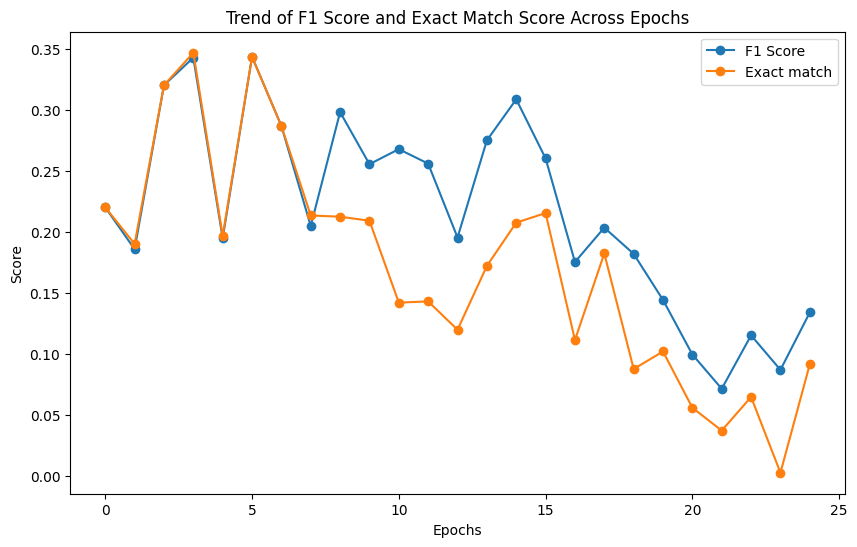

In [84]:
import matplotlib.pyplot as plt

# Your data
data = res

# Extract F1 scores, another scores, and epochs
f1_scores = [item[0] for item in data]
another_scores = [item[1] for item in data]
epochs = list(range(0, len(data)))

# Plotting
plt.figure(figsize=(10, 6))

# Plot F1 scores
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')

# Plot another scores
plt.plot(epochs, another_scores, label='Exact match', marker='o')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Trend of F1 Score and Exact Match Score Across Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [126]:
model = AutoModelForCausalLM.from_pretrained("D:\Dropbox\Yueh\YU\Artificial_Intelligence\Final_Project\AI_Final_Project_Code\Code\Test2\GIT_textvqa_model_v2_epo5").to('cuda')
print(predict(model,tokenizer))

Question: What are positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: the histone subunits
Before Training: answering does not require reading text in the image
Predicted: yesmit the cells
f1: 0.3333333333333333
exact: 0.3333333333333333

***************************
Question: How are the histone subunits charged?
Answer: positively charged
Before Training: answering does not require reading text in the image
Predicted: yesal
f1: 0
exact: 0.0

***************************
Question: Are the histone subunits positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What are illustrated?
Answer: the principal cellular alterations that characterize reversible cell injury and necrosis
Before Training: unanswerable
Predicted: yes zones
f1: 0
exact: 0.0

***************************
Question: Are the principal cellular alterations th

Question: Is the immediate reaction characterized by an inflammatory infiltrate rich in eosinophils, neutrophils, and T cells?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows several multinucleate giant cells?
Answer: the granuloma
Before Training: gimp
Predicted: yesnigraph the
f1: 0.5
exact: 0.5

***************************
Question: What does the granuloma in the center show?
Answer: multinucleate giant cells
Before Training: gimp
Predicted: yes gran cells
f1: 0.3333333333333333
exact: 0.3333333333333333

***************************
Question: Does the granuloma in the center show several multinucleate giant cells?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does the left ventricular wall show several multinucleate giant cells?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does the immunoperoxidase sta

Question: Does large, flat cells with small nuclei intersperse primitive tubules, represent the epithelial component?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What was present in other areas within this Wilms tumor, characterized by cells with hyperchromatic, pleomorphic nuclei, and an abnormal mitosis (center of field)?
Answer: focal anaplasia
Before Training: unans
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What was present within this Wilms tumor, characterized by cells with hyperchromatic, pleomorphic nuclei, and an abnormal mitosis center of field?
Answer: focal anaplasia
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Was focal anaplasia present in other areas within this Wilms tumor, characterized by cells with hyperchromatic, pleomorphic nuclei, and an abnormal mitosis center of field?
Answer: yes
Before Training: una
Predicted: yes
f1: 

Question: Where is the pacemaker?
Answer: in the right ventricle
Before Training: unanswerable
Predicted: yes side
f1: 0
exact: 0.0

***************************
Question: Is a pacemaker presented incidentally in the right ventricle?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is cohesive tumor in retina presented incidentally in the right ventricle?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are heaped up within the sinuses of Valsalva?
Answer: nodular masses of calcium
Before Training: unanswerable
Predicted: yesed
f1: 0
exact: 0.0

***************************
Question: What are nodular masses of calcium heaped up within?
Answer: the sinuses valsalva
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Are nodular masses of calcium heaped up within the sinuses of Valsalva?
Answer: yes
Before Training: yes
Predict

Question: What is seen lying within a clear space created by retraction of its cytoplasms?
Answer: a distinctive lacunar cell with a multilobed nucleus containing many small nucleoli
Before Training: no
Predicted: yesrine
f1: 0
exact: 0.0

***************************
Question: What does the multilobed nucleus of the distinctive lacunar cell contain?
Answer: many small nucleoli
Before Training: no, it is a lot of black and white
Predicted: yes cells
f1: 0
exact: 0.0

***************************
Question: Is a distinctive lacunar cell with a multilobed nucleus containing many small nucleoli seen lying within a clear space created by retraction of its cytoplasms?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is paler trabeculae seen lying within a clear space created by retraction of its cytoplasms?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: A distinctive lacunar cell wi

Question: Are the pattern of staining of anti-centromere antibodies filled with a characteristic foamy acellular exudate?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does silver stain demonstrate cup-shaped and round cysts within the exudate?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does congo red staining stain demonstrate cup-shaped and round cysts within the exudate?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does the histologic appearance demonstrate?
Answer: small
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does the histologic appearance demonstrate small round, uniform nuclei and moderate cytoplasm?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What shows mesangial cell prolifera

Question: Infiltration of the surface epithelium by T lymphocytes , which can be recognized by whose stained nuclei labeled T?
Answer: their
Before Training: nan
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows regularly spaced stool-filled diverticulae?
Answer: gross examination of a resected sigmoid colon
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does gross examination of a resected sigmoid colon show regularly spaced stool-filled diverticulae?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does gram show regularly spaced stool-filled diverticulae?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are cut in cross-section?
Answer: glands
Before Training: unanswerable
Predicted: yes of and the the and the the
f1: 0
exact: 0.0

***************************
Question: How are the gla

Question: Where is carcinomatous tissue seen?
Answer: on the posterior aspect
Before Training: unanswerable
Predicted: yes face
f1: 0
exact: 0.0

***************************
Question: Is carcinomatous tissue seen on the posterior aspect (lower left)?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is higher-power photomicrograph seen on the posterior aspect (lower left)?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is caused by gonococcal infection?
Answer: acute epididymitis
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is acute epididymitis caused by?
Answer: gonococcal infection
Before Training: inches
Predicted: yes the andsed andse
f1: 0
exact: 0.0

***************************
Question: How is acute epididymitis caused?
Answer: by gonococcal infection
Before Training: inches
Predicted: yes a and and
f1: 0
exact: 

Question: What is delineated from the residual normocellular gland on the upper right in this low-power view?
Answer: a solitary hypercellular adenoma
Before Training: unanswerable
Predicted: yes the
f1: 0
exact: 0.0

***************************
Question: What is a solitary hypercellular adenoma delineated from?
Answer: the residual normocellular gland on the upper right
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is a solitary hypercellular adenoma delineated from the residual normocellular gland on the upper right in this low-power view?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is the epithelium above the intact basement membrane delineated from the residual normocellular gland on the upper right in this low-power view?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows minimal variation in nuclear siz

Question: How is aneurysmal bone cyst with blood-filled cystic space surrounded?
Answer: by a fibrous wall containing proliferating fibroblasts
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is the aneurysmal bone cyst with blood-filled cystic space surrounded by a fibrous wall containing proliferating fibroblasts, reactive woven bone, and osteoclast-type giant cells?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is flow cytometry surrounded by a fibrous wall containing proliferating fibroblasts, reactive woven bone, and osteoclast-type giant cells?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is composed of curvilinear trabeculae of woven bone that lack conspicuous osteoblastic rimming and arise in a background of fibrous tissue?
Answer: fibrous dysplasia
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***

Question: Is the wall of the aneurysm a densely cellular tumor with necrosis and pseudo-palisading of tumor cell nuclei along the edge of the necrotic zone?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What did the microscopic appearance of medulloblastoma show?
Answer: small
Before Training: unanswerable
Predicted: yes pattern of in cells
f1: 0
exact: 0.0

***************************
Question: Did microscopic appearance of medulloblastoma show mostly small, blue, primitive-appearing tumor cells?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Did a wide-eyed, staring gaze, caused by overactivity of the sympathetic nervous system, show mostly small, blue, primitive-appearing tumor cells?
Answer: no
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are distinguished grossly from most primary central nervous system tumors by the

Question: What does the affected area on right show?
Answer: cells with intensely eosinophilic cytoplasm of tubular cells
Before Training: unanswerable
Predicted: yes andnophitop
f1: 0
exact: 0.0

***************************
Question: How does the affected area on right show cells?
Answer: with intensely eosinophilic cytoplasm of tubular cells
Before Training: unanswerable
Predicted: yes bodies andlo cytop and
f1: 0
exact: 0.0

***************************
Question: Does the affected area on right show cells with intensely eosinophilic cytoplasm of tubular cells?
Answer: yes
Before Training: unanswerable
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does necrosis show cells with intensely eosinophilic cytoplasm of tubular cells?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What show granular debris?
Answer: nuclei
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************

Question: Do the whorls composed of the smooth muscle cells and fibroblasts show osseous metaplasia in the centre?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do two daughter cells show osseous metaplasia in the centre?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What has core containing proteins, p24 and p18, two strands of viral rna, and enzyme reverse transcriptase?
Answer: the particle
Before Training: nan
Predicted: yesl
f1: 0
exact: 0.0

***************************
Question: How many strands does the particle have?
Answer: two
Before Training: 2
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: The particle has core containing proteins, p24 and p18, how many strands of viral rna, and enzyme reverse transcriptase?
Answer: two
Before Training: nan
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does the particle ha

Question: Are the deposits also present in peritubular connective tissue producing atrophic tubules?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is p-component also present in peritubular connective tissue producing atrophic tubules?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is extensive in the space of Disse causing compression and pressure atrophy of hepatocytes?
Answer: deposition
Before Training: com
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where the deposition is extensive causing compression and pressure atrophy of hepatocytes?
Answer: in the space of disse
Before Training: unanswerable
Predicted: yes of of
f1: 0.4444444444444444
exact: 0.3333333333333333

***************************
Question: Is the deposition extensive in the space of Disse causing compression and pressure atrophy of hepatocytes?
Answer: yes
Before Trainin

Question: Does sequence of events in the pathogenesis of reversible and irreversible cell injury show typical coagulative necrosis ie?
Answer: no
Before Training: don't
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is acute inflammatory infiltrate at?
Answer: the periphery of the infarct
Before Training: unanswerable
Predicted: yes the the
f1: 0.5
exact: 0.3333333333333333

***************************
Question: What is there at the periphery of the infarct?
Answer: acute inflammatory
Before Training: ice
Predicted: yesc
f1: 0
exact: 0.0

***************************
Question: Is there acute inflammatory infiltrate at the periphery of the infarct?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is the deposition acute inflammatory infiltrate at the periphery of the infarct?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are predominantly se

Question: Is the kidney contrasted with normal basal polarity in columnar epithelium?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is the basement membrane intact in both?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is sectioned slice of the liver intact in both?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is surrounded by increased fat?
Answer: matted mass of lymph nodes
Before Training: cauliflower
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is matted mass of lymph nodes surrounded by?
Answer: increased fat
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is matted mass of lymph nodes surrounded by increased fat?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is 

Question: Do these end components of chromosome result in defect in anchoring of lipid bilayer of the membrane to the underlying cytoskeleton?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What results in spherical contour and small size so as to contain the given volume of haemoglobin in the deformed red cell?
Answer: this
Before Training: unanswerable
Predicted: yestom
f1: 0
exact: 0.0

***************************
Question: Does this result in spherical contour and small size so as to contain the given volume of haemoglobin in the deformed red cell?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does the wedge-shaped infarct result in spherical contour and small size so as to contain the given volume of haemoglobin in the deformed red cell?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What lose their cell membran

Question: Is the alveolar septa narrowing of the lumen of coronary due to fully developed atheromatous plaque which has dystrophic calcification in its core?
Answer: no
Before Training: nan
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is there in the media and adventitia?
Answer: endarteritis and periarteritis of the vasa vasorum
Before Training: blackberry
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is there endarteritis and periarteritis of the vasa vasorum in the media and adventitia?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is thalassaemia and hbd endarteritis and periarteritis of the vasa vasorum in the media and adventitia?
Answer: no
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is there of plasma cells, lymphocytes and macrophages?
Answer: perivascular infiltrate
Before Training: blackberry
Predict

Question: What are the alveolar walls lined by?
Answer: cuboidal to tall columnar and mucin-secreting tumour cells with papillary growth pattern
Before Training: purple
Predicted: yes alveolar
f1: 0
exact: 0.0

***************************
Question: Are the alveolar walls lined by cuboidal to tall columnar and mucin-secreting tumour cells with papillary growth pattern?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are 3 components: ghon 's focus, lined by cuboidal to tall columnar and mucin-secreting tumour cells with papillary growth pattern?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are replaced by multiple, variable-sized, circumscribed nodular masses which are grey-white in colour?
Answer: large parts of the lung parenchyma
Before Training: no
Predicted: yesmit of
f1: 0.25
exact: 0.5

***************************
Question: What are large parts of the lung pare

Question: Does external surface show increased mesenteric fat, thickened wall and narrow lumen?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does aboratory findings of itp show increased mesenteric fat, thickened wall and narrow lumen?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows segment of thickened wall with narrow lumen which is better appreciated in cross section while intervening areas of the bowel are uninvolved or skipped?
Answer: luminal surface of longitudinal cut section
Before Training: nan
Predicted: yes the
f1: 0
exact: 0.0

***************************
Question: What does luminal surface of longitudinal cut section show?
Answer: segment of thickened wall with narrow lumen
Before Training: fat
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How does luminal surface of longitudinal cut section show segment of thickened wall?

Question: Is an asbestos body wiping out of liver lobules with only collapsed reticulin framework left out in their place, high lighted by reticulin stain right photomicrograph?
Answer: no
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is there?
Answer: no significant inflammation or fibrosis
Before Training: phenom
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is there no significant inflammation or fibrosis?
Answer: yes
Before Training: no
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is the cut surface no significant inflammation or fibrosis?
Answer: no
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows three layers in the wall of hydatid cyst?
Answer: microscopy
Before Training: high
Predicted: yes thegraph the the
f1: 0
exact: 0.0

***************************
Question: How many layers does microscopy show?
Answer: three
Before Tra

Question: What are surrounded by abundant fibrous tissue and chronic interstitial inflammatory reaction?
Answer: tubules
Before Training: flower
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are the tubules surrounded by?
Answer: abundant fibrous tissue and chronic interstitial inflammatory reaction
Before Training: roses
Predicted: yesules
f1: 0
exact: 0.0

***************************
Question: Are the tubules surrounded by abundant fibrous tissue and chronic interstitial inflammatory reaction?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are the capillary walls surrounded by abundant fibrous tissue and chronic interstitial inflammatory reaction?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What show periglomerular fibrosis?
Answer: glomeruli
Before Training: flower
Predicted: yes the
f1: 0
exact: 0.0

***************************
Question

Question: Do the grades of CIN-1 or mild dysplasia show progressive increase in the number of abnormal cells parallel to the increasing severity of grades?
Answer: yes
Before Training: no
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is ziehl-neelsen or afb parallel to the increasing severity of grades?
Answer: no
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is well-differentiated adenocarcinoma showing closely packed glands with cytologic atypia?
Answer: the most common histologic pattern
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is the most common histologic pattern?
Answer: well-differentiated adenocarcinoma showing closely packed glands with cytologic atypia
Before Training: unanswerable
Predicted: yes st
f1: 0
exact: 0.0

***************************
Question: Is the most common histologic pattern well-differentiated adenocarcinoma showing cl

Question: What does the subcutaneous tissue show?
Answer: masses or nodules of calcium salt surrounded by foreign body giant cells
Before Training: pink
Predicted: yestop
f1: 0
exact: 0.0

***************************
Question: Does the subcutaneous tissue show masses or nodules of calcium salt surrounded by foreign body giant cells?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What shows branching papillae having flbrovascular stalk covered by a single layer of cuboidal cells having ground-glass nuclei?
Answer: microscopy
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does microscopy show branching papillae having flbrovascular stalk covered by a single layer of cuboidal cells having ground-glass nuclei?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does pbf show branching papillae having flbrovascular stalk cover

Question: Is the basal layer expanded externally due to a gelatinous tumour?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows lobulated mass with bluish cartilaginous hue infiltrating the soft tissues?
Answer: sectioned surface
Before Training: a flower
Predicted: yes surface the the
f1: 0.3333333333333333
exact: 0.25

***************************
Question: How does sectioned surface show lobulated mass?
Answer: with bluish cartilaginous hue infiltrating the soft tissues
Before Training: unanswerable
Predicted: yested
f1: 0
exact: 0.0

***************************
Question: Does sectioned surface show lobulated mass with bluish cartilaginous hue infiltrating the soft tissues?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does the amputated head of the long bone show lobulated mass with bluish cartilaginous hue infiltrating the soft tissues?
Answer: no
Before Traini

Question: What do some of the whorls contain?
Answer: psammoma bodies
Before Training: blue rose
Predicted: yes and of
f1: 0
exact: 0.0

***************************
Question: Do some of the whorls contain psammoma bodies?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do a gaucher cell in bone marrow contain psammoma bodies?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows a separate encapsulated gelatinous mass?
Answer: lower part of the image
Before Training: calif
Predicted: yes surface the
f1: 0.25
exact: 0.3333333333333333

***************************
Question: What does lower part of the image show?
Answer: a separate encapsulated gelatinous mass
Before Training: calif
Predicted: yes of
f1: 0
exact: 0.0

***************************
Question: Does lower part of the image show a separate encapsulated gelatinous mass?
Answer: yes
Before Training: yes
Predicted:

Question: What is present?
Answer: pus in test tube
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is pus in test tube present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is subdiaphragmatic abscess present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this area in the body?
Answer: abdomen
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What illustrates pus from the peritoneal cavity?
Answer: case of peritonitis slide
Before Training: unanswerable
Predicted: yes the the the
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Abdomen
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: pus in test tube
Before Training: unanswerable
Predicted: yes
f1: 0


Question: What is present?
Answer: peritoneum
Before Training: measuring
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is peritoneum present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: retroperitoneal liposarcoma
Before Training: measuring
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is retroperitoneal liposarcoma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where is this area in the body?
Answer: abdomen
Before Training: molt
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What cut surface natural color yellow and white typical gross sarcoma?
Answer: nodular tumor
Before Training: answering does not require reading text in the image
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Abdomen
Before Training: measu

Question: What does this image show?
Answer: gram negative septicemia due to scalp electrode in a neonate
Before Training: raw meat
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show gram negative septicemia due to scalp electrode in a neonate?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does acid show gram negative septicemia due to scalp electrode in a neonate?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Why does this image show gram negative septicemia?
Answer: due to scalp electrode in a neonate
Before Training: unanswerable
Predicted: yes to ruptured sac
f1: 0.18181818181818182
exact: 0.25

***************************
Question: What does this image show?
Answer: gram negative septicemia due to scalp electrode in a neonate
Before Training: pigs
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does thi

Question: What is present?
Answer: newborn Cord Around Neck
Before Training: u. s. a.
Predicted: yesato
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: view of face and chest anterior
Before Training: spalding
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show view of face and chest anterior?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does subdiaphragmatic abscess show view of face and chest anterior?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Anencephaly
Before Training: spalding
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is Anencephaly present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is skin over back a buttocks present?
Answer: no
Before Training: yes
Predicted: 

Question: What is present?
Answer: Notochord
Before Training: peony
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is Notochord present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is liver present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Notochord
Before Training: peony
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: epithelial component resembling endometrium
Before Training: love
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show epithelial component resembling endometrium?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does newborn cord around neck show epithelial component resembling endometrium?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact:

Question: How does this image show excellent invasive tumor?
Answer: with marked desmoplastic reaction
Before Training: unanswerable
Predicted: yes bodies
f1: 0
exact: 0.0

***************************
Question: Does this image show excellent invasive tumor with marked desmoplastic reaction?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does leiomyosarcoma show excellent invasive tumor with marked desmoplastic reaction?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are seen?
Answer: intraductal lesions
Before Training: pinkish purple
Predicted: yesgesua
f1: 0
exact: 0.0

***************************
Question: Are intraductal lesions seen?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are opened abdominal cavity with massive tumor in omentum none apparent in liver nor over peritoneal surfaces gut seen?
Answer:

Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is fibrinous peritonitis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: vasculature
Before Training: capri
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is vasculature present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is stillborn macerated present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: capillary
Before Training: capri
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is capillary present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is beckwith-wiedemann syndrome present?
Answer: no
Before Training:

Question: Is subdiaphragmatic abscess present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this mage from?
Answer: capillary
Before Training: lobsters
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: crab
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: vasculature
Before Training: crab
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Capillary
Before Training: crab
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: sarcoplasmic reticulum
Before Training: rhs
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show sarcoplasmic reticulum?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does omphalocele s

Question: What is present?
Answer: coronary artery
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is marfans syndrome present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: chronic ischemia
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is chronic ischemia present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is conjoined twins present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: heart
Befo

Question: Is fibrinous peritonitis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: heart
Before Training: x
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: heart
Before Training: cascade
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show heart, myocardial infarction, surgery to repair interventricular septum rupture?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does breast show heart, myocardial infarction, surgery to repair interventricular septum rupture?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: 

Question: What is present?
Answer: cardiovascular
Before Training: blade
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: aorta
Before Training: the protrus
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: blade
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: heart
Before Training: chocolate
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show heart, myocardial infarction free wall, 6 days old, in a patient with diabetes mellitus and hypertension?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does abdomen show heart, myocardial infarction free wall, 6 days old, in a patient with 

Question: What is present?
Answer: cardiovascular
Before Training: 6. 5
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is slide present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: heart
Before Training: 6. 5
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: 6. 5
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: congestive heart failure
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show congestive heart failure?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does lateral view show congestive 

Question: Is this typical lesion present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this from?
Answer: heart
Before Training: pink
Predicted: yes system
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Heart
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: heart
Before Training: ripples
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show heart, fibrosis, chronic rheumatic heart disease?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does an opened peritoneal cavity cause by fibrous band strangulation show heart, fibrosis, chronic rheumatic heart disease?
Answer: no
Before Training

Question: Where is this in?
Answer: in heart
Before Training: unanswerable
Predicted: yesure
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: heart
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show heart, old myocardial infarction with fibrosis, he?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does pus in test tube show heart, old myocardial infarction with fibrosis, he?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0

Question: Does this image shows of smooth muscle cell with lipid in sarcoplasm and lipid show heart, microthrombi, thrombotic thrombocytopenic purpura?
Answer: no
Before Training: unans
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is tuberculosis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this in?
Answer: in heart
Before Training: unanswerable
Predicted: yesure
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: thrombus in leg vein with 

Question: Does this image show vasculitis, polyarteritis nodosa?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does lateral view show vasculitis, polyarteritis nodosa?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: pink
Predicted: yesrine
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is intraductal papillomatosis with apocrine metaplasia present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: vasculature
Before Training: pink
Predicted: yesrine
f1: 0
exact: 0.0

***************************
Question: Is vasculature present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

******

Question: What spotted fever, immunoperoxidase staining vessels for rickettsia rickettsii?
Answer: rocky mountain
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is rocky mountain spotted?
Answer: fever
Before Training: sky
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is rocky mountain spotted fever, immunoperoxidase staining vessels for rickettsia rickettsii?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is macerated stillborn spotted fever, immunoperoxidase staining vessels for rickettsia rickettsii?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

*********

Question: What does this image show?
Answer: x-ray postmortcoronary arteries with multiple lesions
Before Training: unanswerable
Predicted: yes ray
f1: 0
exact: 0.0

***************************
Question: How does this image show x-ray postmortcoronary arteries?
Answer: with multiple lesions
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show x-ray postmortcoronary arteries with multiple lesions?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does aldehyde fuscin show x-ray postmortcoronary arteries with multiple lesions?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

*****

Question: Is intraductal papillomatosis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: unanswerable
Predicted: yes system
f1: 0.5
exact: 0.5

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: adrenal phaeochromocytoma
Before Training: 5. 5
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show adrenal phaeochromocytoma?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does granulomata slide show adrenal phaeochromocytoma?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: 5. 5
Predicted: yes
f1: 0
exact:

Question: Does this image show thyroid, hashimotos?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does sacrococcygeal teratoma show thyroid, hashimotos?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is fibrinous peritonitis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: unanswerable
Predicted: yesintestinal system
f1: 0.5
exact: 0.5

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

*************

Question: Is intraductal papillomatosis with apocrine metaplasia present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Nodule
Before Training: unanswerable
Predicted: yesato
f1: 0
exact: 0.0

***************************
Question: Is Nodule present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is cachexia present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: unanswerable
Predicted: yesleenrine system
f1: 0.5
exact: 0.5

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: yesato
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: adrenal
Before Training: unanswerable
Predicted: yesato
f1: 0
exact: 0.0

***************************
Qu

Question: What is present?
Answer: carcinoma
Before Training: cinnamon
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is carcinoma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: pompeii
Predicted: yes system
f1: 0.5
exact: 0.5

***************************
Question: What had colon carcinoma?
Answer: 70yof
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What had colon carcinoma?
Answer: section through thyroid and trachea
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is section through thyroid and trachea had?
Answer: colon carcinoma
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What had metastases to lungs , pleura , liver and regional nodes?
Answer: carcinoma
Before Traini

Question: Does this image show fixed tissue but good color gland not recognizable as such?
Answer: yes
Before Training: answering does not require reading text in the image
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does myocardium show fixed tissue but good color gland not recognizable as such?
Answer: no
Before Training: answering does not require reading text in the image
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: scallops
Predicted: yesatologic
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is amyloidosis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: pituitary
Before Training: scallops
Predicted: yesatologic
f1: 0
exact: 0.0

************************

Question: How does this image show adrenal, polyarteritis nodosa?
Answer: with infarct
Before Training: unanswerable
Predicted: yes bodies
f1: 0
exact: 0.0

***************************
Question: Does this image show adrenal, polyarteritis nodosa with infarct?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does photo show adrenal, polyarteritis nodosa with infarct?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is myocardial infarct present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this part in the figure?
Answer: endocrine system
Before Training: ped

Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is papillary intraductal adenocarcinoma present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this part in the figure?
Answer: endocrine system
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: pituitary
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show pituitary, chromaphobe adenoma?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does retroperitoneal leiomyosarcoma show pituitary, chromaphobe adenoma?
Answer: no
Before Training: yes
Predicted:

Question: Does iron stain?
Answer: yes
Before Training: no
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does cachexia stain?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: iron stain
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show iron stain?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does lymphoma show iron stain?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is acute peritonitis present?
Answer: no
Before Training: ye

Question: Is angiogram present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this part in the figure?
Answer: endocrine system
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: thyroid
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: normal immature infant
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: yesrine
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is newborn cord ar

Question: Does this image show necrosis of distal finger in a patient with panniculitis and fascitis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does nipple duplication show necrosis of distal finger in a patient with panniculitis and fascitis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are present?
Answer: extremities
Before Training: dead fish
Predicted: yesmities
f1: 0
exact: 0.0

***************************
Question: Are extremities present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are cells present?
Answer: no
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What streptococcus a scepticemia in a patient with scleroderma who was on high dose steroids?
Answer: necrosis of distal finger panniculitis and fascitis
Before Training: yes
Predicted: yes
f1: 0

Question: Are view looking down on heads present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Dysplastic
Before Training: a nail
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is Dysplastic present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is natural color present?
Answer: no
Before Training: answering does not require reading text in the image
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are present?
Answer: extremities
Before Training: a nail
Predicted: yesmities
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Dysplastic
Before Training: a nail
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: good example exposure not the best but ok Rheumatoid Arthritis
Before Training: bleach
Predicted: yes of

Question: What is present?
Answer: Foot
Before Training: foot
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows clubbing?
Answer: this great toe
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this great toe show clubbing?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does feet show clubbing?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What are present?
Answer: extremities
Before Training: unanswerable
Predicted: yesmities
f1: 0
exact: 0.0

***************************
Question: Are extremities present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are trophic changes present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: pulmonary osteoarthr

Question: What is present?
Answer: hand
Before Training: hands
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: simian crease
Before Training: croc
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show simian crease?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What are present?
Answer: extremities
Before Training: crocs
Predicted: yesmities
f1: 0
exact: 0.0

***************************
Question: Are extremities present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: hand
Before Training: crocs
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hand present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What are present?
Answer: extremities
Before Training: crocs
Predi

Question: What does this image show?
Answer: gravid uterus
Before Training: munchies
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show gravid uterus?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does anomalous origin show gravid uterus?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where does this part belong to?
Answer: female reproductive system
Before Training: mussels
Predicted: yesintestinal
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: uterus
Before Training: meter
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show uterus, leiomyoma?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does abdomen show uterus, leiomyoma?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0



Question: What is present?
Answer: fallopian tube
Before Training: u. s. a.
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How many cm does this image show cut surface lesion 76yobf?
Answer: 4
Before Training: 2
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: cut surface 4 cm lesion 76yobf
Before Training: cm
Predicted: yes of
f1: 0
exact: 0.0

***************************
Question: Does this image show cut surface 4 cm lesion 76yobf?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does interesting case show cut surface 4 cm lesion 76yobf?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: female reproductive
Before Training: cm
Predicted: yeslogic
f1: 0
exact: 0.0

***************************
Question: Is female reproductive present?
Answer: yes
Before Training: yes
Predic

Question: What is present?
Answer: Leiomyomas
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is Leiomyomas present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is tuberculous peritonitis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where does this part belong to?
Answer: female reproductive system
Before Training: unanswerable
Predicted: yesintestinal
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: female reproductive
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Leiomyomas
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How many myomas does this image show opened uterus with quite typical?
Answer: three
Before Training: 1
Predicted: yes
f1: 0

Question: Where does this belong to?
Answer: female reproductive system
Before Training: munch
Predicted: yesintestinal system
f1: 0.4
exact: 0.5

***************************
Question: What is present?
Answer: female reproductive
Before Training: munch
Predicted: yestrointestinal
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: uterus
Before Training: munch
Predicted: yestrointestinal
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cervical leiomyoma
Before Training: munch
Predicted: yestrointestinal
f1: 0
exact: 0.0

***************************
Question: What was in the stomach this is true bilateral krukenberg?
Answer: peritoneal surface of uterus and douglas pouch outstanding photo primary
Before Training: inches
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What was peritoneal surface of uterus and douglas pouch outstanding photo primary in this is true bilateral krukenberg?
Answer: in the sto

Question: What is present?
Answer: female reproductive
Before Training: skin
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: ovary
Before Training: skin
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: mucinous cystadenocarcinoma
Before Training: skin
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is not diagnostic?
Answer: this partially fixed gross
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is this partially fixed gross not diagnostic?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is vasculature not diagnostic?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: female reproductive
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is female 

Question: What is present?
Answer: female reproductive
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is female reproductive present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: uterus
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is uterus present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: leiomyoma
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is leiomyoma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where does this belong to?
Answer: female reproductive system
Before Training: hoog
Predicted: yes system
f1: 0.4
exact: 0.5

***************************
Question: What is present?
Answer: female reproductive
Befor

Question: What is present?
Answer: female reproductive
Before Training: quartz
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is female reproductive present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is amyloidosis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this from?
Answer: female reproductive system
Before Training: unanswerable
Predicted: yes system
f1: 0.4
exact: 0.5

***************************
Question: What is present?
Answer: female reproductive
Before Training: quartz
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: uterus
Before Training: pink
Predicted: yestro
f1: 0
exact: 0.0

***************************
Question: Does this image show uterus, leiomyomas?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Quest

Question: What does this image show?
Answer: excellent photo of pleomorphic spindle cell tumor with storiform pattern
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How does this image show excellent photo of pleomorphic spindle cell tumor?
Answer: with storiform pattern
Before Training: yes
Predicted: yes bodies
f1: 0
exact: 0.0

***************************
Question: Does this image show excellent photo of pleomorphic spindle cell tumor with storiform pattern?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does medial aspect show excellent photo of pleomorphic spindle cell tumor with storiform pattern?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: female reproductive
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is female reproductive present?
Answer:

Question: What is present?
Answer: gastrointestinal
Before Training: the pinkish
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: stomach
Before Training: brownie
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show stomach, necrotizing esophagitis and gastritis, sulfuric acid ingested as suicide attempt?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does this typical thecoma with yellow foci show stomach, necrotizing esophagitis and gastritis, sulfuric acid ingested as suicide attempt?
Answer: no
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is gastrointestinal present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

**********

Question: What does this image show?
Answer: duodenal ulcer
Before Training: cinnamon bun
Predicted: yestro
f1: 0
exact: 0.0

***************************
Question: Does this image show duodenal ulcer?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does pituitary show duodenal ulcer?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: cinnamon
Predicted: yestrointestinal
f1: 0
exact: 0.0

***************************
Question: Is gastrointestinal present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is stillborn macerated present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: gastrointestinal system
Before Training: doughnut
Predicted: yesintestinal system
f1: 0.5
exact: 

Question: What does this image show?
Answer: colon
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show colon, chronic ulcerative colitis, pseudopolyps?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does autopsy show colon, chronic ulcerative colitis, pseudopolyps?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is gastrointestinal present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is this good yellow color slide present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: gastrointestinal system
Before Training: donu

Question: Does fetus developing very early show intestine, leiomyoma?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: turtle
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is gastrointestinal present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is eosinophilic adenoma present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this from?
Answer: gastrointestinal system
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: turtle
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: oral dysplasia
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

****************

Question: Where is this from?
Answer: gastrointestinal system
Before Training: london
Predicted: yes system
f1: 0.5
exact: 0.5

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is?
Answer: the tumor
Before Training: milk
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is the tumor?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is esophagus?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: good example can tell even at what the tumor is
Before Training: milk
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show good example can tell even at this what the tumor is?
Answer: yes
Before Training: unanswerable
Predicted: yes
f1: 1.0
exact: 1.0

******

Question: What is present?
Answer: Pinworm
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is Pinworm present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is peritoneum present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this from?
Answer: gastrointestinal system
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Pinworm
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: typical infiltrating adenocarcinoma extending to serosal fat
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************

Question: What is present?
Answer: whipples disease
Before Training: pink and white
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: bacon
Predicted: yesint
f1: 0
exact: 0.0

***************************
Question: Is gastrointestinal present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is aldehyde fuscin present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: colon
Before Training: bacon
Predicted: yesint
f1: 0
exact: 0.0

***************************
Question: Is colon present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is hemochromatosis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: villous adenoma
Before Training:

Question: Is body on autopsy table lesion that supposedly predicts premature coronary disease easily seen?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is easily seen?
Answer: body on autopsy table lesion that supposedly predicts premature coronary disease
Before Training: male
Predicted: yes several capsule
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: ear lobe horizontal crease
Before Training: male
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: stenotic foramen magnum in situs excellent example
Before Training: kilt
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show stenotic foramen magnum in situs excellent example?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does hematoma show stenotic foramen magnum in situs excellent exa

Question: Is multiple myeloma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is photo present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: bone, skull
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: multiple myeloma
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What left was patent hemisection of nose?
Answer: right side atresia
Before Training: water
Predicted: yesos right
f1: 0.4
exact: 0.5

***************************
Question: What is right side atresia left?
Answer: was patent hemisection of nose
Before Training: water
Predicted: yes of
f1: 0.28571428571428575
exact: 0.5

***************************
Question: Is right side atresia left was patent hemisection of nose?
Answer: yes
Before Training: yes
P

Question: Is cleft palate present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: bone, calvarium
Before Training: dead meat
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: metastatic lung carcinoma
Before Training: dead meat
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: large nodular osteoma in right temporal fossa
Before Training: jaw
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show large nodular osteoma in right temporal fossa?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does fibroma show large nodular osteoma in right temporal fossa?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: bone
Before Training: blood
Predic

Question: Is hematologic present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is hemorrhage in newborn present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this part in?
Answer: spleen
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hematologic
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: splenic infarcts
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show splenic infarcts?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does hypertrophic gastritis show splenic infarcts?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Ques

Question: Does exostosis show i am not sure of diagnosis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is a thymus?
Answer: this
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is this?
Answer: a thymus
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is this a thymus?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is female reproductive a thymus?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hematologic
Before Training: cm
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hematologic present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is blood present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact:

Question: Is hematologic present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is edema present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: bone marrow
Before Training: metro
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is bone marrow present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is there present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this part in?
Answer: spleen
Before Training: metro
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hematologic
Before Training: metro
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: bone marrow
Before Training: metro
Predicted: yes
f1: 0
exact: 0.0

*

Question: What is present?
Answer: spleen
Before Training: unanswerable
Predicted: yesatologic
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: traumatic rupture
Before Training: unanswerable
Predicted: yesatologic
f1: 0
exact: 0.0

***************************
Question: What are well shown?
Answer: not too spectacular discs
Before Training: pebble
Predicted: yesmit and
f1: 0
exact: 0.0

***************************
Question: Are not too spectacular discs well shown?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Are teeth well shown?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: close-up view of vertebral marrow not too spectacular discs are well shown and normal also entered into file as normal discs slide
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does s

Question: Do retroperitoneum induce involution in baby with hyaline membrane disease?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hematologic
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hematologic present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is cardiovascular present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What induce involution in baby with hyaline membrane disease?
Answer: thymus, stress
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What do thymus , stress induce?
Answer: involution in baby with hyaline membrane disease
Before Training: rain
Predicted: yes andtion in baby with disease
f1: 0.6153846153846153
exact: 0.6666666666666666

***************************
Qu

Question: What is present?
Answer: thymoma
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is thymoma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is leiomyomas present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hematologic
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: thymus
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: thymoma
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: ring form
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show ring form?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1

Question: Is temporal muscle hemorrhage present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hematologic
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: bone marrow
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: plasma cell
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What stain excellent example source unknown?
Answer: iron
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does iron stain excellent example source unknown?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does quite good liver stain excellent example source unknown?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exac

Question: What is present?
Answer: acute myelogenous leukemia
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is acute myelogenous leukemia present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is endocervical polyp present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What stain many pleomorphic blast cells readily seen?
Answer: wrights
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What do wrights stain?
Answer: many pleomorphic blast cells readily seen
Before Training: purple
Predicted: yes and le macromic cells in cells blood prior blood
f1: 0.23529411764705882
exact: 0.1

***************************
Question: What is present?
Answer: hematologic
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is presen

Question: What does this image show?
Answer: two basophilic bodies and periarterial fibrosis excellent example of rarely seen lupus lesion
Before Training: flower
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show two basophilic bodies and periarterial fibrosis excellent example of this rarely seen lupus lesion?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: hematologic
Before Training: flower
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hematologic present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: spleen
Before Training: flower
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is spleen present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: 

Question: Does this image show liver, cirrhosis alpha-1 antitrypsin deficiency?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does cortical nodule show liver, cirrhosis alpha-1 antitrypsin deficiency?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: fermented
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is that present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: fermented
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: liver and pancreas
Before Training: unanswerable
Predicted: yes
f1: 0
exact

Question: Does this image show cholangiocarcinoma?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does vasculitis foreign body show cholangiocarcinoma?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is digital infarcts bacterial endocarditis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is 

Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is cytomegaly present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: cinnamon
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is this typical thecoma with yellow foci present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: cinnamon
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: cinnamon
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: unanswe

Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: cm
Predicted: yesato
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: cm
Predicted: yesato
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: hepatitis c virus
Before Training: quartz
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show hepatitis c virus?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does adenoma sebaceum show hepatitis c virus?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: quartz
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answe

Question: Does sickle cell disease show primary biliary cirrhosis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is fetus developing very early present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is angiogram present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before 

Question: What does this image show?
Answer: autoimmune hepatitis
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show autoimmune hepatitis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does exposure show autoimmune hepatitis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is very good example present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is 

Question: What is present?
Answer: liver
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is fracture present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: hepatitis b virus
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show hepatitis b virus, hepatocellular carcinoma?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does splenomegaly with cirrhosis show hepatitis b virus, hepatocellular carcinoma?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0

Question: Is aorta not opened surrounded by large nodes?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer: aorta not opened surrounded by large nodes
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show aorta not opened surrounded by large nodes?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: lymph node
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is lymph node present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: hodgkins disease
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hodgkins disease present?
Answer: yes
Before Training: yes
Predicted: yes
f

Question: How does surface of nodes seen externally in slide show matting and necrosis?
Answer: focal
Before Training: 10. 5
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How is excellent example cut surface of nodes seen externally in slide shows matting and necrosis?
Answer: focal
Before Training: 1. 5
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: matted and fused periaortic nodes with hemorrhagic necrosis good example
Before Training: my fave
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show matted and fused periaortic nodes with hemorrhagic necrosis good example?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does feet show matted and fused periaortic nodes with hemorrhagic necrosis good example?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: W

Question: Is antitrypsin present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: nice example lymphocyte depleted medullary area
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show nice example lymphocyte depleted medullary area?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does arcus senilis show nice example lymphocyte depleted medullary area?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: lymph node
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is lymph node present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is side showing patency right side present?
Answer: no
Before

Question: What is present?
Answer: prostate
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is prostate present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: hyperplasia median bar
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is hyperplasia median bar present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer: enlarged nodular prostate with medial lobe enlargement bladder hypertrophy focal mucosal hemorrhages in bladder mild hydronephrosis very good example
Before Training: cherry tomatoes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show enlarged nodular prostate with medial lobe enlargement bladder hypertrophy focal mucosal hemorrhages in bladder mild hydronephro

Question: Is adenocarcinoma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer: chancroid
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show chancroid, smear of bubo?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: penis
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is penis present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer: very good example of normal prostate gland
Before Training: raspberry
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show very good example of normal prostate gland?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact

Question: Is this image shows wrights typical present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: rib with obvious focal lesion squamous cell carcinoma primary in penis
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show rib with obvious focal lesion squamous cell carcinoma primary in penis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: joints
Before Training: bacon
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is joints present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is distal end excellent example?
Answer: sectioned femur lesion
Before Training: delete
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is sectioned fem

Question: What is present?
Answer: soft tissue
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is soft tissue present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer: close-up view of cross sectioned rib lesion showing white neoplastic lesion with hemorrhagic center
Before Training: 4. 5
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show close-up view of cross sectioned rib lesion showing white neoplastic lesion with hemorrhagic center?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does calculi show close-up view of cross sectioned rib lesion showing white neoplastic lesion with hemorrhagic center?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: joints
Before Train

Question: What is present?
Answer: soft tissue
Before Training: donuts
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is soft tissue present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is rheumatoid arthritis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: tracheotomy site
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show tracheotomy site, granulation tissue?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does granulomata slide show tracheotomy site, granulation tissue?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: muscle
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

**************************

Question: Does this image show typical acute lesion very good?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: muscle
Before Training: eye
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is muscle present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: soft tissue
Before Training: eye
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is soft tissue present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is slide?
Answer: tumor well shown gross
Before Training: raspberry
Predicted: yes and close up up up up up up up up
f1: 0
exact: 0.0

***************************
Question: What is tumor well shown gross?
Answer: slide
Before Training: unanswerable
Predicted: yes tumor
f1: 0
exact: 0.0

***************************
Qu

Question: What does this image show?
Answer: necrosis dr garcia tumors 67
Before Training: unanswerable
Predicted: yes of
f1: 0
exact: 0.0

***************************
Question: Does rheumatoid arthritis show necrosis dr garcia tumors 67?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: brain
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is chest and abdomen slide present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: medulloblastoma
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is feet present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: dr garcia tumors 51
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

*******

Question: Does this image show brain, subarachanoid hemorrhage due to disseminated intravascular coagulation?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does muscle show brain, subarachanoid hemorrhage due to disseminated intravascular coagulation?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: nervous
Before Training: brain
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is nervous present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is this section showing liver with tumor mass in hilar area tumor present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: nervous
Before Training: brain
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is nervous present?
Answer:

Question: Do mucicarmine stain?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do sacrococcygeal teratoma stain?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: nervous
Before Training: nike
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is nervous present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is cut edge of mesentery present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: nervous
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: brain
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show brain, encephalomalasia?
Answer: yes
Before Train

Question: Does this image show brain, herpes inclusion bodies?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does hemorrhage newborn show brain, herpes inclusion bodies?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: nervous
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is nervous present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is endocrine present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: herpes simplex virus
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show herpes simplex virus, brain, immunohistochemistry?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1

Question: Is neurofibrillary change present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is malignant thymoma present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: neural tangle
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show neural tangle?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does astrocytoma show neural tangle?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: brain
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is brain present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is vasculature present?
Answ

Question: What is present?
Answer: squamous cell carcinoma
Before Training: red
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is squamous cell carcinoma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: oral
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: chronic sialadenitis
Before Training: raspberry
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show chronic sialadenitis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does sugar coated show chronic sialadenitis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: pink and purple
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: I

Question: Does this image show compound nevus?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does bilateral cleft palate show compound nevus?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: rain
Predicted: yesint
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is excellent example present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: oral
Before Training: the pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: intramucosal nevus
Before Training: the flower
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show intramucosal n

Question: Where is this?
Answer: oral
Before Training: hobbit
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: necrotizing sialometaplasia
Before Training: tooth
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show necrotizing sialometaplasia?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does hemorrhagic corpus luteum show necrotizing sialometaplasia?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: tooth
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is gross present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Ans

Question: What is present?
Answer: oral
Before Training: pompom
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is vessel present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: oral
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: leukoplakia
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show leukoplakia?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does oil acid show leukoplakia?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: unanswerable
Predicte

f1: 1.0
exact: 1.0

***************************
Question: Does malformed base show cherubism?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is cachexia present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: oral
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: hematopoietic bone marrow defect
Before Training: 107. 79
Predicted: yes ray
f1: 0
exact: 0.0

***************************
Question: Does this image show hematopoietic bone marrow defect?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

*****

Question: What does this image show?
Answer: adenocarcinoma
Before Training: orange
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show adenocarcinoma, mucinous, head of pancreas?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does excellent vertebral body primary show adenocarcinoma, mucinous, head of pancreas?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: pancreas
Before Training: cinnamon
Predicted: yesintestinal
f1: 0
exact: 0.0

***************************
Question: Is pancreas present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer: acute pancreatitis with fat necrosis
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How does this image show acute pancreatitis

Question: What does this image show?
Answer: normal pancreas
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show normal pancreas?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does choanal atresia show normal pancreas?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: pancreas
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: pancreatic fat necrosis
Before Training: heart
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show pancreatic fat necrosis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does pneumocystis show pancreatic fat necrosis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.

Question: Does this image show hilar lymph nodes, nodular sclerosing hodgkins disease and diffuse alveolar damage with hemorrhagic pneumonia?
Answer: yes
Before Training: no
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: respiratory
Before Training: fossilized
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is respiratory present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: lung
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How many antitrypsin does this image show lung, emphysema and bronchial hemorrhage, alpha-deficiency?
Answer: 1
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: lung
Before Training: pompei
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show

Question: Does this image show lung, pulmonary edema and focal pneumonitis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does acute peritonitis show lung, pulmonary edema and focal pneumonitis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: respiratory
Before Training: red
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is respiratory present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is glial nodule present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: lung
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: cryptococcal pneumonia
Before Training: brown
Predicted: yes
f1: 0
exact: 0.0

************

Question: Is respiratory present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is metastatic pancreas carcinoma present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: lung
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: lung
Before Training: raspberry
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show lung, multinucleated foreign body giant cell?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does pancreas show lung, multinucleated foreign body giant cell?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: lung
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

****************

Question: How does this image show lung, sarcoidosis, multinucleated giant cells?
Answer: with asteroid bodies
Before Training: unanswerable
Predicted: yes bodies
f1: 0.4
exact: 0.5

***************************
Question: Does this image show lung, sarcoidosis, multinucleated giant cells with asteroid bodies?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: respiratory
Before Training: virus
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is respiratory present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: lung
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: Breast cancer metastasis to lung
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show Breast cance

Question: What is present?
Answer: metastatic malignant ependymoma
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is metastatic malignant ependymoma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is incidental finding present?
Answer: no
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: lung
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How is x-ray chest shown left hilar tumor in hilar node?
Answer: mass
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How is x-ray chest shown left hilar mass tumor in hilar?
Answer: node
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: verruca vulgaris
Before Training: speck
Predicted: yes
f1: 0
ex

Question: Does this image show close-up photo quite good?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does spina bifida show close-up photo quite good?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: petechiae
Before Training: pilsating
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is petechiae present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is glomerulosa present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: skin
Before Training: buries
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: close-up photo very good
Before Training: pils
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image sho

Question: Is rocky mountain spotted fever, vasculitis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is benign cystic teratoma spotted fever, vasculitis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: skin
Before Training: mould
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: skin
Before Training: clog
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show skin, neurofibromatosis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does ulcer show skin, neurofibromatosis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: skin
Before Training: the sea
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What doe

Question: Is Sporotrichosis present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is this good yellow color slide present?
Answer: no
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: skin
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Demodex Folliculorum
Before Training: pebble
Predicted: yesint
f1: 0
exact: 0.0

***************************
Question: Is Demodex Folliculorum present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is fibrinous peritonitis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: skin
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: m

Question: Does this image show staghorn calculi in renal pelvis, gout?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does palmar crease normal show staghorn calculi in renal pelvis, gout?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: urinary
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: kidney
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show kidney, renal papillary necrosis, acute?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does lung show kidney, renal papillary necrosis, acute?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: urinary
Before Training:

Question: What is present?
Answer: kidney
Before Training: piggy
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is kidney present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is immunostain for growth hormone present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: metastatic carcinoma lung
Before Training: piggy
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is metastatic carcinoma lung present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is serous cyst present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: urinary
Before Training: a street
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: kidney
Before Training: 

Question: Where is this?
Answer: urinary
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: kidney
Before Training: hypnot
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show kidney, polyarteritis nodosa?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does myocardium show kidney, polyarteritis nodosa?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: urinary
Before Training: hypnot
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: kidney transplant rejection
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show kidney transplant rejection?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

******************

Question: Does this image show kidney glomerulus, kimmelstiel-wilson nodules in a patient with diabetes mellitus?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: urinary
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: kidney
Before Training: ice cream
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show kidney, kw kimmelstiel-wilson?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: urinary
Before Training: ice cream
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: kidney
Before Training: flower
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show kidney, arteriolonephrosclerosis, malignant hypertension?
Answer: yes

In [127]:
model = AutoModelForCausalLM.from_pretrained("D:\Dropbox\Yueh\YU\Artificial_Intelligence\Final_Project\AI_Final_Project_Code\Code\Test2\GIT_textvqa_model_v2_epo25").to('cuda')
print(predict(model,tokenizer))

Question: What are positively charged, thus allowing the compaction of the negatively charged DNA?
Answer: the histone subunits
Before Training: answering does not require reading text in the image
Predicted: ##aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa a a withaaaaaaaaaaaaa a with with with withaaaaaaaaaaaaaa with with with withaaaaaaaaaaaa a with with with with withaaaaaaaaaa a with with withaaaaaaaaa a with with with with withaaaaaaaaa with with aaaaaaaaa with a with withaaaaaaaaaa with withseaaaaaaaaa with with withaaaaaaaaaaaaaaa with with with with aaaaaaaaaaaaaa a with with withaaaaaaaaaaaaaa with with with with withseaaaaaaaaaaaaaaa a with with with aaaaaaaaaaaaaaaa with with aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

Question: What shows a circumferential bright pink area of necrosis with protein deposition and inflammation?
Answer: the wall of the artery
Before Training: red blood
Predicted: ##sississississississississississississississississississississississisal thesississis asissississis ofsississis ofalsissississississississississississississississississississississis asississisal ofsississississississisalsississisalsis the thealsis ofsississississississississississississississississississississississississississis ofsississississis ofsissississississississississis ofsissississississississississis withsississississississis ofsississississississississississis thesississississisalsississississississisalsis the a the withsississississis withalsissis withsisalsississisalsissis withsissississississississis withsissississisalsississis with withalsississississis withsis with withsississississississississis with with with with with thesissississississississississis thesississississississis with withsi

Question: Are the cellular alterations in apoptosis illustrated?
Answer: yes
Before Training: yes
Predicted: example example example example example example example example example example example example example example example example example example example of example example example example example example example example example example example example example example example of of of example example example example example example example example example example example example example example of of example example example example example example example example example of example of of example example example example example example example of of example example example example example example example example example of of of of example example of of example example example example example example example of of infiltrate of of of of of example example example example example example example of of example example example example example example example of example example example

Question: What was removed for postpartum bleeding?
Answer: a gravid uterus
Before Training: head
Predicted: of of of with of with with with with with with with of with with withte of yesules of
f1: 0
exact: 0.0

***************************
Question: What was a gravid uterus removed for?
Answer: postpartum bleeding
Before Training: head
Predicted: of of of with of with with with with with with with of with with withte of yesules
f1: 0
exact: 0.0

***************************
Question: Was a gravid uterus removed for postpartum bleeding?
Answer: yes
Before Training: yes
Predicted: of of of with of with with with with with with with of with with withte of yes
f1: 0.10526315789473684
exact: 0.05555555555555555

***************************
Question: Was the injurious stimulus removed for postpartum bleeding?
Answer: no
Before Training: yes
Predicted: of of of with of with with with with with with with of with with withte of yes
f1: 0
exact: 0.0

***************************
Question: What is

Question: Are skin stem cells strikingly similar to normal squamous epithelial cells, with intercellular bridges and nests of keratin?
Answer: no
Before Training: yes
Predicted: of of al of of of of of of of of al of of al of of of of of of al of of of al of of of al of of of of of of of of al al of of of of al of al of of of of al of of of of of of of of of al of of of of al of of of of of of al of of al of of of of of of of al of of yes
f1: 0
exact: 0.0

***************************
Question: What shows failure of normal differentiation, marked nuclear and cellular pleomorphism, and numerous mitotic figures extending toward the surface?
Answer: high-power view of another region
Before Training: unanswerable
Predicted: with of ofsis of ofsissis of the of the the the the the the the the the the the the the thesis withsis of the the the the the the the the the the the of with of of the with with of withsis the the the the the the the the of ofocsissis ofsis withsis of with with the the t

Question: Is this condition cystic hygroma?
Answer: yes
Before Training: yes
Predicted: skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skinuri skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skinuri skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skinuri skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skinuri skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skinuri skin skin skin skin skin skin skin skin skin skin skin sk

Question: Are the light green polypeptides characteristically seen with, but not limited to, constitutional chromosomal anomalies such as 45, X karyotypes?
Answer: no
Before Training: yes
Predicted: skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skinuri skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skinuri skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skinuri skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skinuri skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin

Question: Are predominance of blastemal morphology and diffuse anaplasia associated with specific molecular lesions?
Answer: yes
Before Training: yes
Predicted: by the to to the the to the to to the the the the the to the the the the to the to to the the to the to to the to section the the the the to the to to to the to to section the the the to to the the the the to to to the the to the the the the to by the the the the to section section to to the the the a the by the to to the to the the to the the the the the the the the the to section the section the to the to to to the to to the the the the section the to to to to to to to to the to the the by the section the the the the the the to the the the to a the the to to the to the to to the to the the to the section the to section to the to to the the to the to the to the the to the to to a the a the the to to section the the the the section the to by the the no
f1: 0
exact: 0.0

***************************
Question: Are FISH using a flu

Question: Did the cause of reversible injury show scattered inflammatory cells, calcification arrowheads, and neovascularization?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with al with with with with with with with with with with with with with with with with with with with al with with with with with with with with with with with with with al with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with al with with with with with with with with with with with with with with with with with with with with with with with with with with with no
f1: 0.014388489208633093
exact: 0.007246376811594203

***************************
Question: Is part of the vessel uninvolved?
Answer: yes
Before Tr

Question: Are this degree of external dysmorphogenesis left atrium shown on the right in this four-chamber view of the heart?
Answer: no
Before Training: yes
Predicted: of for for for by for of with on for for by for a a a the a for for for a a a a a a a a a the for for a a a a a a a a for a for for a for for a a a with for by for by by a a a a a a with for a a a a a a a a a by for for a a of a of a a a a for for with of of for for a a for a a by for for for for for a a a a by for for a a a a a a a a by a a for by a a for for a a a a for a a a a a a a a the the yes
f1: 0
exact: 0.0

***************************
Question: What is presented incidentally in the right ventricle?
Answer: a pacemaker
Before Training: unanswerable
Predicted: of for for for by for of with on for for by for a a a the a for for for a a a a a a a a a the for for a a a a a a a a for a for for a for for a a a with for by for by by a a a a a a with for a a a a a a a a a by for for a a of a of a a a a for for with of 

Question: Are note bowing of legs as a consequence of the formation of poorly not fused, as in rheumatic aortic valve stenosis?
Answer: no
Before Training: yes
Predicted: of of as as as as of as as as as as as as as of of of as as of as as as as of of of of of as as of of of of of as as of as as of of of as ofal of of of of of as of as of as of as as of of as as as as of as of of of of ofal of of as ofalal ofal ofal of of of as as as of of of of as of of of of as of of of of of of of of ofal as of of as ofalal ofal ofal of of ofalal ofal of of of of ofalal of of ofalal of of of of as of as of of of ofal of of of ofalalalal of as of ofal of of of ofal of of of of of of of of of of of of of of of as of of of of as of of as of of of of of of of of of of gas
f1: 0
exact: 0.0

***************************
Question: One cusp has a partial fusion at whose center?
Answer: its
Before Training: no
Predicted: of of as as as as of as as as as as as as as of of of as as of as as as as of of of of of

Question: What is evident?
Answer: four-chamber dilation and hypertrophy
Before Training: dog
Predicted: of of of of of of of of of of hyper of of of of of of of of yespa - with and
f1: 0.07692307692307693
exact: 0.045454545454545456

***************************
Question: How are four-chamber dilation and hypertrophy?
Answer: evident
Before Training: unanswerable
Predicted: of of of of of of of of of of hyper of of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: Are four-chamber dilation and hypertrophy evident?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of hyper of of of of of of of of yes
f1: 0.09523809523809523
exact: 0.05

***************************
Question: Is the pattern of staining of anti-centromere antibodies evident?
Answer: no
Before Training: yes
Predicted: of of of of of of of of of of hyper of of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: Does microscopic appearance of the thick

Question: Is a diagnostic, binucleate Reed-Sternberg cell surrounded by eosinophils, lymphocytes, and histiocytes?
Answer: yes
Before Training: yes
Predicted: to to to to to to to yes
f1: 0.2222222222222222
exact: 0.125

***************************
Question: Is the arteriolar wall surrounded by eosinophils, lymphocytes, and histiocytes?
Answer: no
Before Training: yes
Predicted: to to to to to to to yes
f1: 0
exact: 0.0

***************************
Question: What results for the AML are shown in the figure?
Answer: flow cytometry
Before Training: unanswerable
Predicted: notoptometry
f1: 0
exact: 0.0

***************************
Question: Is the glomerulus result for the AML shown in the figure?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What are positive for the stem cell marker CD34 and the myeloid lineage specific markers CD33 and CD15 subset?
Answer: the tumor cells
Before Training: nan
Predicted: notop of
f1: 0
exact: 0.0

Question: What shows mesangial cell proliferation, basement membrane duplication, leukocyte infiltration, and accentuation of lobular architecture?
Answer: membranoproliferative glomerulonephritis (mpgn)
Before Training: unanswerable
Predicted: a with by a a a a a yes
f1: 0
exact: 0.0

***************************
Question: Did membranoproliferative glomerulonephritis (MPGN) show mesangial cell proliferation, basement membrane duplication, leukocyte infiltration, and accentuation of lobular architecture?
Answer: yes
Before Training: unans
Predicted: a with by a a a a a yes
f1: 0.19999999999999998
exact: 0.1111111111111111

***************************
Question: Did predominance of blastemal morphology and diffuse anaplasia show mesangial cell proliferation, basement membrane duplication, leukocyte infiltration, and accentuation of lobular architecture?
Answer: no
Before Training: no
Predicted: a with by a a a a a yes
f1: 0
exact: 0.0

***************************
Question: What shows comp

Question: Is low magnification composed of nests of malignant cells that partially recapitulate the stratified organization of squamous epithelium?
Answer: no
Before Training: yes
Predicted: the with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with the with with with with with with with with with with with with with with with with with with with with with the with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with the with with with with with with with with with with with with with with with with with with the with with with with with with with with with the the with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with w

Question: Is reversible injury composed of granulation tissue overlaid by degraded blood?
Answer: no
Before Training: yes
Predicted: ofsalalal theals ofalalal andss ofs of ofalalsalsssalalal the of ofsss ofalals of ofs ofal the the thessss ofsal the the thes the thealal of of of and the theal thealal ofsal thealalals the ofsalalalssal andal and theals thealsalalalalsalalals ofalalalalal andal andssssalsal the ofssalal andalssssalss ofsal the andals ofalalalalsal of ofalal ofsss of ofs of ofal of of ofs ofs ofal of of ofal ofalal of of of of of of ofsal of ofal ofs of ofal of ofalal ofalal ofal of of of ofalal of ofalal ofalalal ofalalalal ofalalal ofalalalalal of of ofalalal ofs ofal of ofal ofals ofalalalalalalal ofal ofsals of ofals of ofal ofal ofssss of of ofss ofalalalal ofalalsss of of of of ofs ofalalalalals of ofalsssssssal ofalal ofalal ofals ofs of ofssals ofal of of yes
f1: 0
exact: 0.0

***************************
Question: Are the rugal fold partially lost?
Answer: yes
Bef

Question: How much does the liver weigh?
Answer: 700 g
Before Training: 60
Predicted: ciop aden yes
f1: 0
exact: 0.0

***************************
Question: How is the liver?
Answer: small (700g)
Before Training: unanswerable
Predicted: ciop aden yes
f1: 0
exact: 0.0

***************************
Question: Is the liver small (700 g), bile-stained, soft, and congested?
Answer: yes
Before Training: yes
Predicted: ciop aden yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Is endoscopy small (700 g), bile-stained, soft, and congested?
Answer: no
Before Training: yes
Predicted: ciop aden yes
f1: 0
exact: 0.0

***************************
Question: What is entrapped in a dense, onion-skin concentric scar?
Answer: a bile duct undergoing degeneration
Before Training: h
Predicted: no natural
f1: 0
exact: 0.0

***************************
Question: What is a bile duct undergoing degeneration entrapped in?
Answer: a dense
Before Training: h
Predicted: no stain
f1: 0
exact:

Question: Is the epididymis involved by an abscess?
Answer: yes
Before Training: yes
Predicted: ofscuscuscu ofscuscu hand ofocococscuocscuscuococococscufarfarocfarocococ ofocococococococococscuococ ofscufarococfarptptscuscufarfarocfarscuptfarscuocscuscu of ofscuocococscufarfarscuscuscuscufarptscuocococfarfarfarscufarscuococscuscuocfarscufarfarscufarococscuocscufarfarfarfarfarococococscuscuscuscufarfarscuococfarcterscufarscufarscuocscu ofptscuscuscufarscuscuscuscuscuscuscuscuscu of ofscuscuscuscufarscuscuscuptptscu thyfar of ofscu of of of of ofscu of of ofscu ofscuoc ofoc ofococ ofococ of ofoc ofoc of ofoc yes
f1: 0.06060606060606061
exact: 0.03125

***************************
Question: Is this in turn involved by an abscess?
Answer: no
Before Training: yes
Predicted: ofscuscuscu ofscuscu hand ofocococscuocscuscuococococscufarfarocfarocococ ofocococococococococscuococ ofscufarococfarptptscuscufarfarocfarscuptfarscuocscuscu of ofscuocococscufarfarscuscuscuscufarptscuocococfarfarfarscufa

Question: What does the coarsely nodular gland contain?
Answer: areas of fibrosis and cystic change
Before Training: 5%
Predicted: int int intary int int int int int yes int int int int yes int int int int int int int int int int int int int int int yes int int int int int yes tumors pigmentno cells of the
f1: 0.0425531914893617
exact: 0.024390243902439025

***************************
Question: Does the coarsely nodular gland contain areas of fibrosis and cystic change?
Answer: yes
Before Training: yes
Predicted: int int intary int int int int int yes int int int int yes int int int int int int int int int int int int int int int yes int int int int int yes
f1: 0.19999999999999998
exact: 0.027777777777777776

***************************
Question: Does the injurious stimulus contain areas of fibrosis and cystic change?
Answer: no
Before Training: yes
Predicted: int int intary int int int int int yes int int int int yes int int int int int int int int int int int int int int int yes int 

Question: Is amyloid derived from calcitonin molecules secreted by the neoplastic cells?
Answer: yes
Before Training: yes
Predicted: with a a a a a a a a a a a a a a a a a a a a a a a a a a a a of of a a a a a a a a a a a the the a a a a a of of a a a a a of of a a a of of of a a a of a of a of of a with a a a of of a of a a of a a of a a a a of a a a a of a a with the of a a a a of with a a a a a a a a a of a a a a a a with a a a a a a a a a a a a of a a a a a a a of a a of the a a a a a of of a a a of of a a a a of of of a a of of a a a a a a a a of a a the a a of a a a of a a a a of a a a a a of a a a a a a of no
f1: 0
exact: 0.0

***************************
Question: Is the polyp derived from calcitonin molecules secreted by the neoplastic cells?
Answer: no
Before Training: yes
Predicted: with a a a a a a a a a a a a a a a a a a a a a a a a a a a a of of a a a a a a a a a a a the the a a a a a of of a a a a a of of a a a of of of a a a of a of a of of a with a a a of of a of a a of

Question: Were the thickened alveolar walls diffusely hyperplastic?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What was from a patient with ACTH-dependent Cushing syndrome, in whom both adrenal glands were diffusely hyperplastic?
Answer: the adnormal gland
Before Training: nan
Predicted: yes lower sc yellow
f1: 0
exact: 0.0

***************************
Question: What was the abnormal gland from?
Answer: a patient with acth-dependent cushing syndrome
Before Training: 1. 5
Predicted: yes lower sc2yp
f1: 0
exact: 0.0

***************************
Question: How was the abnormal gland?
Answer: from a patient with acth-dependent cushing syndrome
Before Training: 1. 5
Predicted: yesalis
f1: 0
exact: 0.0

***************************
Question: Was the abnormal gland from a patient with ACTH-dependent Cushing syndrome, in whom both adrenal glands were diffusely hyperplastic?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 

Question: Is this more cellular and disorganized than Fig.654?
Answer: yes
Before Training: yes
Predicted: ayyyis ayyyy a a ayy ay a ayyyyy ayy a a a a ayyy ayyyy ayy ay ay ais a a ayy aisisyyyyyisyyyy ayyyyyy ayyyy a ay a a ais a a a a ayy a a a ais a ayy a a a a a a ayy ay a a a ay a a ay a a a ay a ay no
f1: 0
exact: 0.0

***************************
Question: What entraps native lamellar bone as a confluent mass of cartilage?
Answer: conventional chondrosarcoma
Before Training: pink
Predicted: a a a a a a a a a a a a a a a a a a a a a my a a a a a a a a a a a a a a a a a a a a my my a a a a a a a a a my a a a a a my a a a a my a a a my my a a a my my my a a a a a a a my a my a a a a a a a my my my my a my my my a a a my a my a a a a a my a a a a a a a a a my my a a a a my a a a a a a a a a a my a a a a my a a a my my a a a a a a a a a a a a a a a a a my a my my a a a a a a a a a my a a a a a a a a a my my my a a a a a a a a a a a my a a a a a a a a a a a my my my my a a a a a a a a 

Question: What is the aneurysmal bone cyst with blood-filled cystic space surrounded by?
Answer: a fibrous wall containing proliferating fibroblasts
Before Training: blue
Predicted: the a a a a a a a a a a a a a a a a a with a a a with with with a a a a a asis with with with with with a a a with with with with with with with with a a a a a with with with with with with with with with with with with with the a with with with with with with with with with with with with with a a with with with with with with with with with with with a a a with with with with with with with with with with with a a with with with with with with with with with with with a the with with with with with a a the asis the with with the of the the the the withsis the a the the the the of of of of of by a the the the the of of of with of of of a a the the the the the of of of of of of a a a the the of a of of of the the the the of the of of a of a a a the the the the the the a a a the a a a a a a the a a a a a a a

Question: What does the right axon, by contrast, show?
Answer: a segment surrounded by a series of thinly myelinated internodes of uneven length flanked on both ends by normal thicker myelin internodes
Before Training: no
Predicted: yesant with
f1: 0
exact: 0.0

***************************
Question: Does the right axon, by contrast, show a segment surrounded by a series of thinly myelinated internodes of uneven length flanked on both ends by normal thicker myelin internodes?
Answer: yes
Before Training: unans
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does this full-thickness histologic section show a segment surrounded by a series of thinly myelinated internodes of uneven length flanked on both ends by normal thicker myelin internodes?
Answer: no
Before Training: unans
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What share the same fiber type (fiber type grouping)?
Answer: large clusters of fibers
Before Training: giraffe
Predic

Question: Where are abscesses present?
Answer: in the putamen and thalamus
Before Training: unanswerable
Predicted: by by byagebro by by by by by byagebroage bybro byagebro by by byage by by by by by byage byage by by by by byage by by by byage by by by byage byage by by by by by by by by byage by by by by by by by by no section line
f1: 0
exact: 0.0

***************************
Question: Are abscesses present in the putamen and thalamus?
Answer: yes
Before Training: yes
Predicted: by by byagebro by by by by by byagebroage bybro byagebro by by byage by by by by by byage byage by by by by byage by by by byage by by by byage byage by by by by by by by by byage by by by by by by by by no
f1: 0
exact: 0.0

***************************
Question: Are the upper parts of both lungs present in the putamen and thalamus?
Answer: no
Before Training: yes
Predicted: by by byagebro by by by by by byagebroage bybro byagebro by by byage by by by by by byage byage by by by by byage by by by byage by by b

Question: What is tumor composed of?
Answer: nests of basaloid cells
Before Training: unanswerable
Predicted: the the the the the the the the of section of of the of of of the of of the of of the in of of of of the the the the the the of of of of section of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of the of the of of the the of of of of of the of of of of of of of of of of of the of of of of of of of yesscurine fibri l typepi and nelpil )a
f1: 0.8451882845188284
exact: 0.007407407407407408

***************************
Question: Is tumor composed of nests of basaloid cells infiltrating a fibrotic stroma?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the of section of of the of of of the of of the of of the in of of of of the the the the the the of of of of section of of of of of of of of of of of of of of of of of of of of of of of of of o

Question: Are the nuclei of affected tubules pale?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the to to to to to to to to to to to to to to to to to to to to to to to to to to to to to the the to the to to the the to the to to to the the the to yes
f1: 0.014492753623188404
exact: 0.0072992700729927005

***************************
Question: Are equence of events in the pathogenesis of reversible and irreversible cell injury pale?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

f1: 0.0028089887640449437
exact: 0.0014064697609001407

***************************
Question: Is the cytoplasm identified by homogeneous, eosinophilic cytoplasm?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thes the the the the the the the the the the the the the the the the the the the thesas the the the theasss the the the the the the the the the the the the the the the the thess the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thesss the the the the the the the the the the the the the the the thes the the the the the the the the thes the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

Question: Do these cells consist of condensation of nuclear chromatin and fragmentation of the cell into membrane-bound apoptotic bodies which are engulfed by macrophages?
Answer: no
Before Training: nan
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thes the the the the the the the the the the the the the the the the the the the thesas the the the theasss the the the the the the the the the the the the the the the the thess the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thesss the the the the the the the the the the the the the the the thes the the the the the the the the thes the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

f1: 0
exact: 0.0

***************************
Question: What do the nuclei show?
Answer: granular debris
Before Training: unanswerable
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the al the the the al the the the yes al
f1: 0
exact: 0.0

***************************
Question: Do the nuclei show granular debris?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

f1: 0
exact: 0.0

***************************
Question: Where is the dead cell seen?
Answer: in singles
Before Training: unanswerable
Predicted: after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after after aft

Question: Is the affected part soft, swollen and dark?
Answer: yes
Before Training: no
Predicted: with with with with with with with with with with with with with yes
f1: 0.13333333333333333
exact: 0.07142857142857142

***************************
Question: Is the interface between viable and non-viable area soft, swollen and dark?
Answer: no
Before Training: no
Predicted: with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What is not clear-cut?
Answer: line of demarcation between gangrenous segment and the viable bowel clear-cut
Before Training: jellyfish
Predicted: with with with with with with with with with with with with with yesleencar
f1: 0
exact: 0.0

***************************
Question: Is line of demarcation between gangrenous segment and the viable bowel not clear-cut?
Answer: no
Before Training: no
Predicted: with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

******

Question: Are these cells also enlarged with irregular outlines?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with wi

Question: Does the particle have core containing proteins, p24 and p18, two strands of viral rna, and enzyme reverse transcriptase?
Answer: yes
Before Training: nan
Predicted: example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example examplec example example example example example example example example example example example example example example example example example example example example exampleccccc example example example example example example ex

Question: Is the epidermis studded with 2 viral glycoproteins, gp120 and gp41, in the positions shown?
Answer: no
Before Training: unanswerable
Predicted: example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example examplec example example example example example example example example example example example example example example example example example example example example exampleccccc example example example example example example example example example

Question: What does p-component have?
Answer: pentagonal or doughnut profile
Before Training: x
Predicted: ##cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc no appearanceal
f1: 0
exact: 0.0

***************************
Question: Does p-component have a pentagonal or doughnut profile?
Answer: yes
Before Training: no
Predicted: ##ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

Question: What show birefringence?
Answer: the congophilic areas
Before Training: unanswerable
Predicted: ##y the the the the the the the a the the the the the the the the the the the the the the the the the theyy theyyy by by ayy type by byve thevevey by goody byy the type the the a a the the the the the the the the the the the the the the the the the the the the the good the the the the the the the the the the yespa
f1: 0.8467153284671532
exact: 0.012987012987012988

***************************
Question: Do the figure show apple-green birefringence?
Answer: no
Before Training: yes
Predicted: ##y the the the the the the the a the the the the the the the the the the the the the the the the the theyy theyyy by by ayy type by byve thevevey by goody byy the type the the a a the the the the the the the the the the the the the the the the the the the the the good the the the the the the the the the the yes
f1: 0
exact: 0.0

***************************
Question: Do the lipofuscin pigment gra

Question: Does m phase show congophilia which under polarising microscopy?
Answer: no
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of no
f1: 0.007936507936507936
exact: 0.00398406374501992

***************************
Question: Is apple-green birefringence shown in 

Question: Does the periphery show marked degeneration and necrosis of hepatocytes accompanied by haemorrhage while the peripheral zone shows mild fatty change of liver cells?
Answer: no
Before Training: unanswer
Predicted: with the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the in the ci the the the red the the the the the the the the the red the into in the with the the the with ci the ci with the the in in the the the the ci red the the the the the in in the the the in the the the to the the with the the the red the the the the the the red the the ci the the the the with red with with the in the the the the red the red red in the with the with with the the the the the red in with 

Question: What do renal tubules and glomeruli show?
Answer: typical coagulative necrosis
Before Training: dough
Predicted: ##alalalal nomour debrisinging cy cy
f1: 0
exact: 0.0

***************************
Question: Do renal tubules and glomeruli show typical coagulative necrosis?
Answer: yes
Before Training: yes
Predicted: ##alalalal no
f1: 0
exact: 0.0

***************************
Question: Does sequence of events in the pathogenesis of reversible and irreversible cell injury show typical coagulative necrosis ie?
Answer: no
Before Training: don't
Predicted: ##alalalal no
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Where is acute inflammatory infiltrate at?
Answer: the periphery of the infarct
Before Training: unanswerable
Predicted: ##alalalal no connect
f1: 0
exact: 0.0

***************************
Question: What is there at the periphery of the infarct?
Answer: acute inflammatory
Before Training: ice
Predicted: ##alalalal nomour
f1: 0
exact: 0.0

******

Question: What is the inner circle shown with?
Answer: green line
Before Training: a spiral
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thea the the the the the the the the the the the the the the the the the the the the the the the the the the theacccccccccccccccccccccc the the the the the thea the theaa the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thec the the the the the the the the the the the the the the the the thec the the the the the the the the the the the the the the the the the the thecc the the the the the the the the the the the the the the the the examplec thecc theca the the the the the the the the the the the the thec the thecc the the the the the the the the the the the the the the the thecc the the theccc the the the thec the the the the the the the the the the the the the the the the 

Question: What is the circle shown with?
Answer: red line represents cell cycle for permanent cells
Before Training: a circle
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thea the the the the the the the the the the the the the the the the the the the the the the the the the the theacccccccccccccccccccccc the the the the the thea the theaa the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thec the the the the the the the the the the the the the the the the thec the the the the the the the the the the the the the the the the the the thecc the the the the the the the the the the the the the the the the examplec thecc theca the the the the the the the the the the the the thec the thecc the the the the the the the the the the the the the the the thecc the the theccc the the the thec the the the the the the the th

Question: Does ctive granulation tissue have inflammatory cell infiltrate, newly formed blood vessels and young fibrous tissue in loose matrix?
Answer: yes
Before Training: yes
Predicted: to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to

Question: What are filled with blood clot?
Answer: the open wound
Before Training: unanswerable
Predicted: by tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr the the tr the the the the the the the the the the the the the the the the the the the the the the the the the the the the tr the the the the the the the the the the the the the the the the the the the the the the the the the the the the tr the the the the the the the the the the the the the the the the the the the the the the the the the the tr the tr the tr tr tr tr tr the the the the the the the the the the tr tr the the the the the tr the the the tr the the the tr the tr the the the tr the the tr tr tr the the tr the tr the tr the tr the the the the the the the the the tr the tr the the the the the by the the the the the the tr the the the the the the tr the tr the the the the the tr tr the the the tr the the the the tr the the tr the the tr the the tr the the the tr the the the the the the 

f1: 0
exact: 0.0

***************************
Question: Do spurs of epidermal cells migrate along the incised margin on either side as well as around the suture track?
Answer: yes
Before Training: yes
Predicted: by tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr the the tr the the the the the the the the the the the the the the the the the the the the the the the the the the the the tr the the the the the the the the the the the the the the the the the the the the the the the the the the the the tr the the the the the the the the the the the the the the the the the the the the the the the the the the tr the tr the tr tr tr tr tr the the the the the the the the the the tr tr the the the the the tr the the the tr the the the tr the tr the the the tr the the tr tr tr the the tr the tr the tr the tr the the the the the the the the the tr the tr the the the the the by the the the the the the tr the the the the the the tr the tr the the the the the tr tr t

f1: 0.0032733224222585926
exact: 0.001639344262295082

***************************
Question: What at around 7th day results in scar tissue at the sites of incision and suture track?
Answer: removal of suture
Before Training: unanswerable
Predicted: by tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr tr the the tr the the the the the the the the the the the the the the the the the the the the the the the the the the the the tr the the the the the the the the the the the the the the the the the the the the the the the the the the the the tr the the the the the the the the the the the the the the the the the the the the the the the the the the tr the tr the tr tr tr tr tr the the the the the the the the the the tr tr the the the the the tr the the the tr the the the tr the tr the the the tr the the tr tr tr the the tr the tr the tr the tr the the the the the the the the the tr the tr the the the the the by the the the the the the tr the the the the the the 

Question: Is the basement membrane intact in both?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with yes
f1: 0.11764705882352941
exact: 0.0625

***************************
Question: Is sectioned slice of the liver intact in both?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What is surrounded by increased fat?
Answer: matted mass of lymph nodes
Before Training: cauliflower
Predicted: section to to to to to to to to to section section to to to section to to to to section section to to to to to to to to to section section to to section to to to to to to to section to to section to to to to to to to to to to to to to section section to to to to to to to section to to to to to to to to to to to to to section to to to to to to to to section section no section section to to to to to to to to t

Question: How does the viral envelope fuse with?
Answer: the plasma membrane of the host cell
Before Training: unanswerable
Predicted: the the the the the the thea the the the the the the the the the the the the the the the the the the the thea the the the the the the the the the the the the the the the the the the the the the the the the thea the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Question: Is classification of chromosomes base on size and location of centromere?
Answer: yes
Before Training: yes
Predicted: ##alaalaaaaaaaaageagealgaalalagea no
f1: 0
exact: 0.0

***************************
Question: Is the serial numbers in the figure base on size and location of centromere?
Answer: no
Before Training: yes
Predicted: ##alaalaaaaaaaaageagealgaalalagea no
f1: 0.6666666666666666
exact: 0.5

***************************
Question: What shows koilocytes having abundant vacuolated cytoplasm and nuclear enlargement?
Answer: the smear
Before Training: unanswerable
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the noato
f1: 0.989795

Question: Does the circle shown with red line contain progressively less rna and more haemoglobin?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thes the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

Question: What result in defect in anchoring of lipid bilayer of the membrane to the underlying cytoskeleton?
Answer: mutations in membrane proteins-alpha-spectrin
Before Training: unanswerable
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Question: Does this result in spherical contour and small size so as to contain the given volume of haemoglobin in the deformed red cell?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

f1: 0
exact: 0.0

***************************
Question: Do m phase lose their cell membrane further during passage through the spleen?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Question: What does this produce?
Answer: a circulating subpopulation of hyperspheroidal spherocytes
Before Training: unanswerable
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Question: When do d lose their cell membrane further?
Answer: during passage through the spleen
Before Training: unanswerable
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

f1: 0.6666666666666666
exact: 0.5

***************************
Question: Is the alveolar septa narrowing of the lumen of coronary due to fully developed atheromatous plaque which has dystrophic calcification in its core?
Answer: no
Before Training: nan
Predicted: ##usususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususususus yes
f1: 0
exact: 0.0

***************************
Question: What is there in the media and adventitia?
Answer: endarteritis and periarteritis of the vasa vasorum
Before Training: blackberry
Predicted: no al with tissue
f1: 0
exact: 0.0

***************************
Question: Is there endarteritis and periarteritis of the vasa vasorum in the media and adventitia?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is thalassaemia and hbd endarteritis and peria

Question: What is increased?
Answer: weight of the heart
Before Training: the world
Predicted: example example example example example example example example example with large large with with large large with with with large yesstic
f1: 0
exact: 0.0

***************************
Question: Is weight of the heart increased?
Answer: yes
Before Training: yes
Predicted: example example example example example example example example example with large large with with large large with with with large yes
f1: 0.0909090909090909
exact: 0.047619047619047616

***************************
Question: Is the sequence on left increased?
Answer: no
Before Training: yes
Predicted: example example example example example example example example example with large large with with large large with with with large yes
f1: 0
exact: 0.0

***************************
Question: What is there?
Answer: patchy myocardial fibrosis
Before Training: pawprint
Predicted: the the the the the the the the the the the the 

Question: What are the location of vegetations on mitral valve shown as?
Answer: viewed from the left atrium
Before Training: unanswerable
Predicted: ##aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa by by by byaaaaaaaaaaaaa by byaaaaaaaaaaaaa byaaaaaaaaa byaaa byaaaaaaaaa bya with with with byaaaaaaaaaaa by with byaaaaaaaaaa with with byaaaaaaaaa byaa byaaaaaaaaaa by with witha by byaaaaaaaaaaaa with by by with with withaa by by byaaaaaaaaaaaaa by by withaaaaaaaaaaaaaaa with the the bya with withaaaaaaaaaaaaaaa with by with witha byaaaaaaaaaaaaaaaa with with with withaaaaaaaaaaaaaaaa with with with with by byaaaaaaaaaaaaa with with with with with with by by by byaaaaaaaaaaaa with with with with by with with the the the by byaaaaaaaaaa with with with with a the the the the with byaaaaaaaaaaa with with with by by byaaaaaaaaaaaaaaaaaaaaaaa byaaaaaaaaaaaaaaaaaaaaaaa byaaaaaaaaaaaaaaaaaaaaaaa byaaaaaaaaaaaaaaaaaaaaaaaa by byaaaaaaaaaaaaaaaaaaaaaaaa by by byaaaaaaaaaaaaaaaaaaaaaaaaa by by by

Question: What are there?
Answer: alternate areas of collapsed and dilated alveolar spaces
Before Training: pink and white
Predicted: with with yes acinarules andllary lacldings rs cells two layers of epithelium witheliocytesity of nuclei
f1: 0.16666666666666669
exact: 0.06666666666666667

***************************
Question: What are there of collapsed and dilated alveolar spaces, many of which are lined by eosinophilic hyaline membranes?
Answer: alternate areas
Before Training: many times
Predicted: with with yes
f1: 0
exact: 0.0

***************************
Question: Are there alternate areas of collapsed and dilated alveolar spaces, many of which are lined by eosinophilic hyaline membranes?
Answer: yes
Before Training: yes
Predicted: with with yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Are cross section cs alternate areas of collapsed and dilated alveolar spaces, many of which are lined by eosinophilic hyaline membranes?
Answer: no
Before Training

Question: Are coal macules composed of aggregates of dust-laden macrophages and collagens seen surrounding respiratory bronchioles?
Answer: yes
Before Training: yes
Predicted: of of yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Are particles at the end of the smear seen surrounding respiratory bronchioles?
Answer: no
Before Training: yes
Predicted: of of yes
f1: 0
exact: 0.0

***************************
Question: What are distended?
Answer: alveoli and respiratory bronchioles surrounding the coal macule
Before Training: xmas
Predicted: of of yes
f1: 0
exact: 0.0

***************************
Question: Are the alveoli and respiratory bronchioles surrounding the coal macule distended?
Answer: yes
Before Training: yes
Predicted: of of yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Are the chambers distended?
Answer: no
Before Training: yes
Predicted: of of yes
f1: 0
exact: 0.0

***************************
Question: What are lined

Question: Where is a partly formed unerupted tooth seen in?
Answer: wall
Before Training: donut
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the of of of of of theto the the the the the the the the the the the the the the the the thetototototo the the of the the the the the the the the the oftototo of of the the the the the oftotototo of the thetotototo of the the the the thetototototo theto of the the of the the the the the the the the thetotototo of of of of the the the the the the the the the the the the the the oftotototo of of of of the the the the the the the the the the the the the the the the of of oftoto of of of the the of the the the the the the the the the the the the the the the the the the the the of the the the the of of of the the the the the the the the the the of the the the the the the the the of the the the the the the of the the the 

Question: Are collections of histiocytes conspicuously absent?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the of of of of of theto the the the the the the the the the the the the the the the the thetototototo the the of the the the the the the the the the oftototo of of the the the the the oftotototo of the thetotototo of the the the the thetototototo theto of the the of the the the the the the the the thetotototo of of of of the the the the the the the the the the the the the the oftotototo of of of of the the the the the the the the the the the the the the the the of of oftoto of of of the the of the the the the the the the the the the the the the the the the the the the the of the the the the of of of the the the the the the the the the the of the the the the the the the the of the the the the the the of the the the t

Question: What shows increased mesenteric fat, thickened wall and narrow lumen?
Answer: external surface
Before Training: fat
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the dark dark by by by the the the the the the the the the the the the the the the the the the the the the the by by by the the the the the the the the the the the the the the the the the the the thebrobro by by example the the the the the the the the the the the the the the the the the the the the by by the the the the the the the the the the the the the the the the the the thebrove by by the the the the the the the the the the the the the the the the the the the theve by the the the the the the the the the the the the the the the the the thebro by by the the the the the the the the the the the the the the the the the the by by by the the the the the the the the the the the the the the the the the by by by the the the the the the the th

Question: What does luminal surface of longitudinal cut section show?
Answer: segment of thickened wall with narrow lumen
Before Training: fat
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the dark dark by by by the the the the the the the the the the the the the the the the the the the the the the by by by the the the the the the the the the the the the the the the the the the the thebrobro by by example the the the the the the the the the the the the the the the the the the the the by by the the the the the the the the the the the the the the the the the the thebrove by by the the the the the the the the the the the the the the the the the the the theve by the the the the the the the the the the the the the the the the the thebro by by the the the the the the the the the the the the the the the the the the by by by the the the the the the the the the the the the the the the the the by by by the the the t

Question: Are the histological features present: transmural chronic inflammatory cell infiltration, deep fissures into the bowel wall, submucosal widening due to oedema, some prominent lymphoid follicles and a few non-caseating epithelioid cell granulomas in the bowel wall?
Answer: yes
Before Training: unans
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of with of with yes
f1: 0.05
exact: 0.02564102564102564

***************************
Question: What shows stricture and a lymph node in section having caseation necrosiss?
Answer: external surface of small intestine
Before Training: schr
Predicted: ##alalalalalalalalalalalalalalalal ofalalalalalalalalalalalalalalalalalalalalalalalym of of ofalalalalal of of ofalalalalalalalalal of of of of ofalalalalal of of ofalalalalalalalalal of of ofalalalalal of of ofalalalalalalalalal of of ofalalalalal of of ofalalalalalalalalal of of ofalalalalal of of ofalalalalalalalalalalalala

Question: What is thickened?
Answer: wall of intestine in the area of narrowed lumen
Before Training: bones
Predicted: ##alalalalalalalalalalalalalalalal ofalalalalalalalalalalalalalalalalalalalalalalalym of of ofalalalalal of of ofalalalalalalalalal of of of of ofalalalalal of of ofalalalalalalalalal of of ofalalalalal of of ofalalalalalalalalal of of ofalalalalal of of ofalalalalalalalalal of of ofalalalalal of of ofalalalalalalalalalalalalal of of ofalalalalalalalalalalalalalalal of of ofalalalalalalalalalalalalalalal of ofalalalalalalalalalalalalalal of ofalalalalalalalalalalalalalalal ofalalalalalalalalalalalalalalalalalalalalalalalalalal ofalalalalalalal of ofalalalalal of of ofalalalalalalalal of of of ofalalalalal of of ofalalalalalalalal ofalalalalal of of ofalalalalalalalal of ofalalalalal of of ofalalalalalalal of of ofalalalalal of of ofalalalalalalal ofalalalalalal of of ofalalalalalalal of of ofalalalalalal of of ofalalalalalalal of of ofalalalalalal of of ofalalalalalala

Question: What are indicative of more severe liver cell injury?
Answer: acidophilic councilman bodies
Before Training: unanswerable
Predicted: with the the the the the the the the the the the the the the the the theal large the the the the the the the the the the the the the the the the the good good the the the the the the the the the the the the the the the the the good good large the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the good good the the the the the the the the the the the the the the the the good goodal good good good good with the the mual the good the the the good good the the good the the the the the the good the the the the the the the the the goodal the good the good the good the the the large good good the the the the the good the the the the the good good the theal the the the the the the the the good the the the good the the the with the the the the good the the good t

Question: Is mild degree of liver cell necrosis seen as ballooning degeneration while acidophilic councilman bodies are indicative of more severe liver cell injury?
Answer: yes
Before Training: unanswerable
Predicted: with the the the the the the the the the the the the the the the the theal large the the the the the the the the the the the the the the the the the good good the the the the the the the the the the the the the the the the the good good large the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the good good the the the the the the the the the the the the the the the the good goodal good good good good with the the mual the good the the the good good the the good the the the the the the good the the the the the the the the the goodal the good the good the good the the the large good good the the the the the good the the the the the good good the theal the the the the the the the the

f1: 0.7793103448275861
exact: 0.0058823529411764705

***************************
Question: Does icroscopy show three layers in the wall of hydatid cyst?
Answer: yes
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the largetototo the the theto the the the the the the the the the the the the the the the the the the the thetotototo large the the the the the the the the the the the the the the the the the the the the the the largetototo large the the thetotototototototototototototo the the the thetoto the the the thetoto the the thetotototo the the theto the the thetotototo the the theto the the thetoto the thetoto the theto largetoto large the thetoto the thetotototo the the thetototo theto theto the the the afterto theto the theto the thetoto the theto the the proto theto the thetototo thetototo thetototo thetototo thetoto theto thetoto theto theto the the thetoto thetotototo thetotototo thetotototo thetotototototo thetototototo the

Question: What does thickness and intensity of colour of on left side of figure correspond to?
Answer: extent of metabolic pathway
Before Training: open
Predicted: no a stain
f1: 0
exact: 0.0

***************************
Question: Does thickness and intensity of colour of arrows on left side of figure correspond to extent of metabolic pathway followed ADH = alcohol dehydrogenase ; ALDH or ACDH = hepatic acetaldehyde dehydrogenase ; NAD = nicotinamide adenine dinucleotide ; NADH = r
Answer: yes
Before Training: nan
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Do these nests correspond to extent of metabolic pathway followed ADH = alcohol dehydrogenase ; ALDH or ACDH = hepatic acetaldehyde dehydrogenase ; NAD = nicotinamide adenine dinucleotide ; NADH = reduced NAD?
Answer: no
Before Training: unans
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is there of epithelium-lined spaces into the gallbladder wall in an area?
Answer: penetra

Question: What are the capillary walls diffusely thickened due to?
Answer: duplication of the gbm
Before Training: x4
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with w

Question: Does the scarred area show atrophy of some tubules and dilatation of others which contain colloid casts thyroidisation?
Answer: yes
Before Training: no
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the theto the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thetototo the the the thetoto the thetoto the thetoto the thetoto the thetoto the thetoto the the the the the theto the the theto the the the the the the the the the the the the the the the the the the the the the thetoto the the the the the in the the the theto the the the the the the the the the the the the the the the thes the the the the the the the the the the the the the the the the the the yes
f1: 0.011560693641618497
exact: 0.005813953488372093

***************************
Question: Does 

f1: 0
exact: 0.0

***************************
Question: What included are thick-walled?
Answer: blood vessels
Before Training: flower
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the theto the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thetototo the the the thetoto the thetoto the thetoto the thetoto the thetoto the thetoto the the the the the theto the the theto the the the the the the the the the the the the the the the the the the the the the thetoto the the the the the in the the the theto the the the the the the the the the the the the the the the thes the the the the the the the the the the the the the the the the the the yessrc in
f1: 0
exact: 0.0

***************************
Question: Are the blood vessels included are thick-walled?
Answer: yes
Be

Question: What is there in the number of layers of epithelium?
Answer: increase
Before Training: blueberry
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of yesbrorosis
f1: 0
exact: 0.0

***************************
Question: Is there increase in the number of layers of epithelium?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of yes
f1: 0.024999999999999998
exact: 0.012658227848101266

***************************
Question: Is the heart increased in the number of layers of epithelium?
Answer: no
Before Training: yes
Predicted: of of of of of of of of of of of of of of of

Question: What shows a very large multilocular cyst without papillae?
Answer: cut surface
Before Training: no
Predicted: yes - of breast
f1: 0
exact: 0.0

***************************
Question: What does cut surface show without papillae?
Answer: a very large multilocular cyst
Before Training: unanswerable
Predicted: yes - up withcular cyst
f1: 0.22222222222222224
exact: 0.25

***************************
Question: Does cut surface show a very large multilocular cyst without papillae?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does the anorectal margin show a very large multilocular cyst without papillae?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows presence of loculi containing gelatinous mucoid material?
Answer: the cyst wall
Before Training: unanswerable
Predicted: yes - surface of
f1: 0
exact: 0.0

***************************
Question: What does the cyst

Question: Are etastatic carcinomatous deposits in the also seen?
Answer: no
Before Training: yes
Predicted: at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at at a a a a at at at at at at at at at at at at at at at at a a a at at at at at at at at at at at at at at at of a at a a a at at at at at at at at at at at at at at at a at at at at at at at at at at at at at at at at a a a a a at at at at at at at at at at at at at at a at at at at at at at at at at at at a a a a at at at at at at at at at at at at at at at a a a at at at at at at at at at at at at at a a a a at at at at at at at at at at at at at at a at at a

Question: Does Cut surface show a grey white firm tumour extending irregularly into adjacent breast parenchyma?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with section with with with with with with with with with with with with section with with with with with with with with with with with with section with with with with with with with with with with with with section section with with with with with with with with with with with with with section with with with with with with with with with with with with with with with with section section with with with with with with with with with with with with with with with with section with with with with with with with with with with with with with with with with section with with with with with with with with with with with with with with

f1: 0
exact: 0.0

***************************
Question: Does the basal layer show hydropic degeneration and loss of dermoepidermal junction?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does intact show hydropic degeneration and loss of dermoepidermal junction?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What shows masses or nodules of calcium salt surrounded by foreign body giant cells?
Answer: subcutaneous tissue
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does the subcutaneous tissue show?
Answer: masses or nodules of calcium salt surrounded by foreign body giant cells
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does the subcutaneous tissue show masses or nodules of calcium salt surrounded by foreign body giant cells?
Answer: yes
Before Training: yes
Predicted: ye

Question: What shows trabeculae with osteoclastic activity at the margins?
Answer: trabecular bone forming the marrow space
Before Training: unanswerable
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the by by by the the the the the the the the the the the the the the by by the the the by the the the the the the the the the by by the the the the the the the the the by by by by the the the the the the the by by by the the the the the by by the the the the the by by by by by the the the the by by the the the the the the by by by by the the the the the the the the the the by by by mass by by the the the the the the the the the the by by by by the by by by by by 

Question: Does the upper dermis show trabeculae with osteoclastic activity at the margins?
Answer: no
Before Training: yes
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the by by by the the the the the the the the the the the the the the by by the the the by the the the the the the the the the by by the the the the the the the the the by by by by the the the the the the the by by by the the the the the by by the the the the the by by by by by the the the the by by the the the the the the by by by by the the the the the the the the the the by by by mass by by the the the the the the the the the the by by by by the by by by by by by the the by by by by by the t

Question: What begins as a focus of microabscess in a vascular loop in the marrow which expands to stimulate?
Answer: process
Before Training: health
Predicted: rocky yespha fi change
f1: 0
exact: 0.0

***************************
Question: What does process begin as?
Answer: a focus of microabscess in a vascular loop in the marrow which expands to stimulate
Before Training: unanswerable
Predicted: rocky yeslit several pattern
f1: 0
exact: 0.0

***************************
Question: Does process begin as a focus of microabscess in a vascular loop in the marrow which expands to stimulate?
Answer: yes
Before Training: unanswerable
Predicted: rocky yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Does photomicrograph on right under higher magnification begin as a focus of microabscess in a vascular loop in the marrow which expands to stimulate?
Answer: no
Before Training: nan
Predicted: rocky yes
f1: 0
exact: 0.0

***************************
Question: What is the

Question: Does the amputated head of the long bone show lobulated mass with bluish cartilaginous hue infiltrating the soft tissues?
Answer: no
Before Training: yes
Predicted: ##aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa -aheraaaaaaaaa foraa forheraaaaaa -aaaaaaaaa foraaaaaaaa foraaa aaaaaaaaaaaaa with withaaaaaaaaaaaaaa withaa aaaaaa -aaaaaaa -aa with for for with foraaaaaa witha -aaaaaaaa for fora a foraaaaaaa foraaaaaaaa for foraa a foraaaaaa a with a withaaaaaaaa a for a a a a foraaa -a for a foraaaaaaaaaaaaaaaa fora aaaaaaa a aaaaaaaaaa for -aaaaaa with withaaaaaaaaaaaaaaaaaaa foraaaaaaaaaaaaaaaaa aaa a a foraaaaaaaaheraaaa a a a aaa aa foraaa - -aa for a aaa aaaaaaa -a withaaa yes
f1: 0
exact: 0.0

***************************
Question: What is expanded in the region of epiphysis?
Answer: end of the long bone
Before Training: pebble
Predicted: the the the the the the the the the the the the the the the the the the the the 

f1: 0.011627906976744186
exact: 0.005847953216374269

***************************
Question: Is viral dna expanded in the region of epiphysis?
Answer: no
Before Training: yes
Predicted: ##eded endeded with end of of end ended endeded end of of end end ended ofedededededededededed end of ofedededed endedededededed end ended withed endeded end of end toededed ended witheded withededed end endededededed of with end end withed endeded ended ofed ended ofed with ended endededededed of ofeded toededed with endededed with end with withed ended to ended ended withededededed end endeded ended endeded endeded end endeded end endededededed of end endedededededededed of end endededed ofeded of of with of end of withededededed of with of of ofededed end end end end end of end end end of of of of of ofededed end end of of of of of ofeded end end of of ended witheded of of end of of of of end ended of of of of of of of of of of of ofeded of of of of ofed of withed of of of of ended ofed with of of of 

Question: What does Inbox in the right photomicrograph show?
Answer: pas positive tumour cells in perivascular location
Before Training: fleur de licht
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with of with with with with with with with with with with with with with with with in with of with with with with with with withal with with with with with with with with with with with in with with withal of with with with withal with with with with with ofal with with with with of with with with with with with with with with withsis with with with with with with of with of

Question: What shows admixture of spindle-shaped pleomorphic cells forming storiform pattern and histiocyte-like round to oval cells?
Answer: tumour
Before Training: unanswerable
Predicted: with the the the the the the the the the the the the the the the withtototototo the the the the the the the the the the the the the the the thetoto the the the the the the the the the the the the the the the thetototo the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thetoto with the the the the the the the the the the the the the the the with with thetoto the thetototo with thetoto thetoto with with thetoto the the with thetoto the with withtoto the the thetoto the with thetoto with thetototo the the with thetotototo withtoto with theto with thetoto with withto thetototototo with theto with the with thetoto the with thetoto with thetoto with theto with thetotototo the the the the the the the theto with the the the the the the

f1: 0.9090909090909091
exact: 0.004524886877828055

***************************
Question: What do some of the whorls contain?
Answer: psammoma bodies
Before Training: blue rose
Predicted: with the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the with the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the withsis the with the the the the the the the with with the the with the the the the the with the the the the the the the with with the the the the the the the with with the with with the the the the the the the the red the the the the the with with the the with the with red the the the the the thesissis the the the the with the the the the the the the the the with the with the the the the the with the the the the with with

Question: What does lower part of the image show?
Answer: a separate encapsulated gelatinous mass
Before Training: calif
Predicted: section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section sect

Question: Is pidural haematoma multilobulated with increased fat while lower part of the image shows a separate encapsulated gelatinous mass?
Answer: no
Before Training: yes
Predicted: section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section section

Question: What is present?
Answer: peritoneum
Before Training: potato
Predicted: ##itoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoito and and anditoito anditoitoitoitoitoitoitoitoito andito and heitoito epitoitoitoa and - -ito -ito anditoito and - -itoito andito anditoitoito and andaitoitoito andito epitoitoitoito - anditoitoito anditoitoitoito and anditoaitoitoitoa anditoitoitoitoitoitoitoitoitoito acute peritonitis
f1: 0
exact: 0.0

***************************
Question: Is peritoneum present?
Answer: yes
Before Training: yes
Predicted: ##itoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoitoito and and anditoito anditoitoitoitoitoitoitoitoito andito and heitoito epitoitoitoa and - -ito -ito anditoito and - -itoito andito anditoitoito and andaitoitoito andito epitoitoitoito - anditoitoito anditoitoitoito and anditoaitoitoitoa anditoitoitoitoitoitoitoitoitoito acute
f1: 0
exact: 0.0

***************************
Question: Is subdiaphragmatic abscess present?
Ans

Question: What is present?
Answer: Carcinomatosis
Before Training: pompom
Predicted: with of with with of with withito of withito with ofito of with of with of with ofito with with with with withito of of with of with with of with withito of of withito of of ofed of ofitoito of of of of of of ofitoito of with of of of with of of of lung of of of of of of of with of of of of with of of yescino skull
f1: 0
exact: 0.0

***************************
Question: Does this image show opened peritoneal cavity showing cecum and appendix on left side?
Answer: yes
Before Training: yes
Predicted: - -aa - - - - - -aa - -aa - - - -aaed of - - - -a - - l - - yes yes - - yes yesa -edaaaa - - -aa yes -ed - - -a -ed - - - - - - - - -a - - - - - -aaa yes and - - - - - -a and anded - - - -a and and and - -a -a - - and and and -ed l and - anded - -ed and and - and -eded -a l anda - yes
f1: 0.23076923076923078
exact: 0.021739130434782608

***************************
Question: Does omphalocele show opened perit

Question: What is present?
Answer: pus in test tube
Before Training: unanswerable
Predicted: les les les les yes les les l lesscu les les yes
f1: 0
exact: 0.0

***************************
Question: What psoas natural color large ovoid typical sarcoma?
Answer: opened muscle
Before Training: answering does not require reading text in the image
Predicted: yes - muscle a - he yes - - a of - of - - yes - a - a yes - ofsti - a - - - yes musclestististi yes excellent of
f1: 0.09523809523809525
exact: 0.05263157894736842

***************************
Question: Does opened muscle psoa natural color large ovoid typical sarcoma?
Answer: yes
Before Training: yes
Predicted: yes - muscle a - he yes - - a of - of - - yes - a - a yes - ofsti - a - - - yes musclestististi yes
f1: 0.5217391304347826
exact: 0.058823529411764705

***************************
Question: Does carcinomatosis psoa natural color large ovoid typical sarcoma?
Answer: no
Before Training: yes
Predicted: yes - muscle a - he yes - - a 

Question: Where is this area in the body?
Answer: abdomen
Before Training: the bottom left
Predicted: end hes case end yes reproductive
f1: 0
exact: 0.0

***************************
Question: What shows cut surface with fish flesh appearance and extensive necrosis very good for illustrating appearance of a sarcoma?
Answer: this section showing liver tumor mass in hilar area tumor
Before Training: 5. 5
Predicted: end hes case end yes of good
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Abdomen
Before Training: measuring
Predicted: end hes case end yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Retroperitoneum
Before Training: measuring
Predicted: end hes case end yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: leiomyosarcoma
Before Training: measuring
Predicted: end hes case end yes
f1: 0
exact: 0.0

***************************
Question: What cut surface natural color yellow an

Question: What does this image show?
Answer: nodular tumor cut surface natural color yellow and white typical gross sarcoma
Before Training: measuring
Predicted: - example example - example example - - - - example example example example example example example example - - example example example example example example - example example example - example example - example example - example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example - - example - example example example example example example example example example example example example example example example example example example example example example - example example example example example - example example example example exam

Question: What is present?
Answer: peritoneum
Before Training: measuring
Predicted: - example example - example example - - - - example example example example example example example example - - example example example example example example - example example example - example example - example example - example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example - - example - example example example example example example example example example example example example example example example example example example example example example - example example example example example - example example example example example example example example example example example example example example ex

Question: Where is this area in the body?
Answer: abdomen
Before Training: molt
Predicted: - example example - example example - - - - example example example example example example example example - - example example example example example example - example example example - example example - example example - example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example - - example - example example example example example example example example example example example example example example example example example example example example example - example example example example example - example example example example example example example example example example example example example exa

Question: What is present?
Answer: retroperitoneal liposarcoma
Before Training: measuring
Predicted: - example example - example example - - - - example example example example example example example example - - example example example example example example - example example example - example example - example example - example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example - - example - example example example example example example example example example example example example example example example example example example example example example - example example example example example - example example example example example example example example example example example example e

Question: How is nodular tumor cut surface natural color yellow and white gross sarcoma?
Answer: typical
Before Training: answering does not require reading text in the image
Predicted: - example example - example example - - - - example example example example example example example example - - example example example example example example - example example example - example example - example example - example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example - - example - example example example example example example example example example example example example example example example example example example example example example - example example example example example - example exam

Question: What is present?
Answer: abdomen
Before Training: pig
Predicted: of with with yes of of with with h and with of with of of of with ofal and with of of yes yes of of of of with with yes yes yes of with with of with of of of of with with with with of with of of with with with of of with of of with with with of with yes
f1: 0
exact: 0.0

***************************
Question: Is abdomen present?
Answer: yes
Before Training: yes
Predicted: of with with yes of of with with h and with of with of of of with ofal and with of of yes yes of of of of with with yes yes yes of with with of with of of of of with with with with of with of of with with with of of with of of with with with of with yes
f1: 0.19718309859154928
exact: 0.015625

***************************
Question: Is slices of liver and spleen typical tuberculous exudate is present on capsule of liver and spleen present?
Answer: no
Before Training: yes
Predicted: of with with yes of of with with h and with of with of of of with 

Question: What is present?
Answer: peritoneal fluid
Before Training: purple
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is peritoneal fluid present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: carcinoma
Before Training: purple
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is carcinoma present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is leiomyosarcoma present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: Abdomen
Before Training: purple
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: peritoneal fluid
Before Training: purple
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: carcinoma
Before Training: purple
Predicted: no
f

Question: Does mesothelioma show hand, gunshot entrance wound, intermediate range, powder burns freckling?
Answer: no
Before Training: yes
Predicted: is is with with with with is with with with with with with with with with with is is with with is is is is is is is withine is with with with is is is is is is is is with is is is with with is is is is is is is is is is with is with with is is is is is is is is is is is with with is is with is is is is is is is is is with with with with with with with with with is is is is is is is with with with with with with with with with with with with with with with with with with with with is is is is is is is is is with with with with with with with with with with with with with with with with with with with with is is is is is is is is with with with with with with with with with with with with with with with with with with with with is is is is is is with with is with with with with with with with is with with with with with with with with with 

Question: What is present?
Answer: Anencephaly
Before Training: octopus
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with yesatologic
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: posterior view of body lesions mostly in head neck and thorax
Before Training: fat
Predicted: ##al yesym 24 body ge appearance
f1: 0.12500000000000003
exact: 0.2

***************************
Question: Does this image show posterior view of body lesions mostly in head neck and thorax?
Answer: yes
Before Training: yes
Predicted: ##al yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Does mesothelioma show posterior view of body lesions mostly in head neck and thorax?
Answer: no
Before Training: yes
Predicted: ##al yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: lymphangiomatosis
Before Training: pinkish
P

f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: body burns 24 hours prior now anasarca
Before Training: dead pig
Predicted: yes with
f1: 0
exact: 0.0

***************************
Question: Does this image show body burns 24 hours prior now anasarca?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does situs inversus show body burns 24 hours prior now anasarca?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: close-up view of head anterior view
Before Training: measuring
Predicted: view yesjo view of one side
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Does this image show close-up view of head anterior view?
Answer: yes
Before Training: yes
Predicted: view yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: What is present?
Answer: Conjoined Twin

Question: What does this image show?
Answer: joined anterior chest and abdomen
Before Training: fab
Predicted: yes with view of large the
f1: 0
exact: 0.0

***************************
Question: Does this image show joined anterior chest and abdomen?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: Siamese Twins
Before Training: cherry
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is Siamese Twins present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: Siamese Twins
Before Training: cherry
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: lateral view of head typical example
Before Training: pompom
Predicted: good example example example example example example example example example example example example example example example example exam

Question: What is present?
Answer: Sacrococcygeal Teratoma
Before Training: love
Predicted: in in in in in - in in in in in in with in in in in in in in e in - in in in in - in in in - in - in in in in in in in in - in in in in in in in in in in - in in in a - in in in in - in in in in in in in in in in - in in in in in in in - in l - - in in in in in in in - in in in in in - - in in in the in in a in in l with in in in a in in in - in in in in - in in in in in in in in in in in in in in - - in in in in in in in in in in in in in - in l in in in in in in - in in in in in in in with in - in - in a - in in in in in - in in in in in in in in in in in in in in in in in in in in in l in in in in in in in in in in yesccato
f1: 0
exact: 0.0

***************************
Question: Is Sacrococcygeal Teratoma present?
Answer: yes
Before Training: yes
Predicted: in in in in in - in in in in in in with in in in in in in in e in - in in in in - in in in - in - in in in in in in in in - in in in in i

f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: two nipples
Before Training: unanswerable
Predicted: example example examplerhrhrhrhrhrhrhrh example example example examplerh example example example example examplerhrhrh example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example 

Question: Is Nipple Duplication present?
Answer: yes
Before Training: yes
Predicted: example example examplerhrhrhrhrhrhrhrh example example example examplerh example example example example examplerhrhrh example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example exa

Question: What is present?
Answer: Nipple Duplication
Before Training: unanswerable
Predicted: example example examplerhrhrhrhrhrhrhrh example example example examplerh example example example example examplerhrhrh example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example example e

Question: Does this image show excellent invasive tumor with marked desmoplastic reaction?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with with with with w

Question: Are opened abdominal cavity with massive tumor in omentum none apparent in liver nor over peritoneal surfaces gut seen?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with wit

Question: What is present?
Answer: papillary Intraductal Adenocarcinoma
Before Training: pinkish purple
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with with with with with with with with w

Question: What are seen?
Answer: intraductal lesions
Before Training: pinkish purple
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with in with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with 

Question: How does this image show metastatic choriocarcinoma?
Answer: with extensive vascularization
Before Training: yes
Predicted: with with with with with with with with with and of of with with with with with with with with with with with with with and with and and with with with with with with with with with with with with with with with with with with and with with with with with with with with with with with with with with with with and with with with with with with with with with s with with with with with with s with with with with with with with with with with with with with with with with with with with with with with with with with with with with of with with with with with with with with with with withs with with with with with with with with with with with with with with with with with with with with with with with with of with with with with with with with with with with and with with with with with with with with with with with with with with with with with of with wit

Question: Is breast present?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with and of of with with with with with with with with with with with with with and with and and with with with with with with with with with with with with with with with with with with and with with with with with with with with with with with with with with with with and with with with with with with with with with s with with with with with with s with with with with with with with with with with with with with with with with with with with with with with with with with with with with of with with with with with with with with with with withs with with with with with with with with with with with with with with with with with with with with with with with with of with with with with with with with with with with and with with with with with with with with with with with with with with with with with of with with with with with with with with with with with with with with

Question: Is carcinomatosis endometrium primary present?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with and of of with with with with with with with with with with with with with and with and and with with with with with with with with with with with with with with with with with with and with with with with with with with with with with with with with with with with and with with with with with with with with with s with with with with with with s with with with with with with with with with with with with with with with with with with with with with with with with with with with with of with with with with with with with with with with withs with with with with with with with with with with with with with with with with with with with with with with with with of with with with with with with with with with with and with with with with with with with with with with with with with with with with with of with with with with with with with with wi

Question: What does this image show?
Answer: coronary artery atherosclerosis diagram
Before Training: lg
Predicted: ##herherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherher atherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherher atherherherherherherherherherherherherherherher atherherherherher yes artery atherhercleclerosis
f1: 0.18181818181818182
exact: 0.14285714285714285

***************************
Question: Does this image show coronary artery atherosclerosis diagram?
Answer: yes
Before Training: yes
Predicted: ##herherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherherh

Question: What does this image show?
Answer: skeletal muscle
Before Training: capri
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show skeletal muscle?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does polycystic disease show skeletal muscle?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: capri
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is fibrinous peritonitis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: vasculature
Before Training: capri
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is vasculature pr

Question: Is capillary present?
Answer: yes
Before Training: yes
Predicted: ##tro mytro mytro my mytro mytrotro mytrotro my mytro mytro mytro mytro my my mytrotrotro my mytro my my my yes
f1: 0.0909090909090909
exact: 0.047619047619047616

***************************
Question: Is intraductal papillomatosis present?
Answer: no
Before Training: yes
Predicted: ##tro mytro mytro my mytro mytrotro mytrotro my mytro mytro mytro mytro my my mytrotrotro my mytro my my my yes
f1: 0
exact: 0.0

***************************
Question: Where is this mage from?
Answer: capillary
Before Training: l
Predicted: ##tro mytro mytro my mytro mytrotro mytrotro my mytro mytro mytro mytro my my mytrotrotro my mytro my my my yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: l
Predicted: ##tro mytro mytro my mytro mytrotro mytrotro my mytro mytro mytro mytro my my mytrotrotro my mytro my my my yes
f1: 0
exact: 0.0

***************************
Que

Question: What is present?
Answer: Cardiovascular
Before Training: earth
Predicted: corona corona corona corona corona corona corona corona corona corona coronacy corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona with coronacy yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: vasculature
Before Training: earth
Predicted: corona corona corona corona corona corona corona corona corona corona coronacy corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona corona with coronacy yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cranial artery
Before Training: earth
Predicted: corona corona corona corona corona corona corona corona corona corona coronacy corona corona corona corona corona corona corona corona corona c

Question: Is conjoined twins present?
Answer: no
Before Training: yes
Predicted: cardiovascular cardiovascular cardiovascular yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: heart
Before Training: paris
Predicted: cardiovascular cardiovascular cardiovascular yesint
f1: 0
exact: 0.0

***************************
Question: What does show lesion containing no lipid?
Answer: myocytolysis not
Before Training: unanswerable
Predicted: cardiovascular cardiovascular cardiovascular yespsy
f1: 0
exact: 0.0

***************************
Question: What does myocytolysis not show containing no lipid?
Answer: show lesion
Before Training: unanswerable
Predicted: cardiovascular cardiovascular cardiovascular yespsy
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: unanswerable
Predicted: cardiovascular cardiovascular cardiovascular yesint
f1: 0.8571428571428571
exact: 0.25

***************************
Questio

Question: Where is this?
Answer: heart
Before Training: schnami
Predicted: with with with with with with with with with with with with with with with with with with of with with with with with with with with with with with with with with with with with with with with with with of with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Ques

f1: 0
exact: 0.0

***************************
Question: Does this image show normal cardiovascular?
Answer: yes
Before Training: yes
Predicted: ##cinocinocinocinocinocinocinocino yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Does this image shows of smooth muscle cell with lipid in sarcoplasm and lipid show normal cardiovascular?
Answer: no
Before Training: yes
Predicted: ##cinocinocinocinocinocinocinocino yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: heart
Before Training: schnaub
Predicted: ##cinocinocinocinocinocinocinocino yes
f1: 0
exact: 0.0

***************************
Question: How many vessel does this image show congestive heart failure, coronary artery disease?
Answer: three
Before Training: 10
Predicted: with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: congestive heart failure
Before Training: cm
Predicted: with with 

Question: What is present?
Answer: Cardiovascular
Before Training: weight
Predicted: heart heart heart heart cardiovascular
f1: 0.33333333333333337
exact: 0.2

***************************
Question: What does this image show?
Answer: heart
Before Training: porcupine
Predicted: yes yes yes yes
f1: 0
exact: 0.0

***************************
Question: How does this image show heart, old myocardial infarction?
Answer: with fibrosis
Before Training: unanswerable
Predicted: yes yes yes yes multiplecy seen
f1: 0
exact: 0.0

***************************
Question: Does this image show heart, old myocardial infarction with fibrosis?
Answer: yes
Before Training: yes
Predicted: yes yes yes yes
f1: 1.0
exact: 0.25

***************************
Question: Does tuberculosis show heart, old myocardial infarction with fibrosis?
Answer: no
Before Training: yes
Predicted: yes yes yes yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: porcupine


Question: What is present?
Answer: cardiovascular
Before Training: unanswerable
Predicted: yes tissue
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: vasculature
Before Training: unanswerable
Predicted: yes tissue
f1: 0
exact: 0.0

***************************
Question: Is vasculature present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: vasculature
Before Training: unanswerable
Predicted: yes reproductive system
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: unanswerable
Predicted: yes tissue
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: vasculature
Before Training: unanswerable
Predicted: yes tissue
f1: 0
exact: 0.0

***********************

Question: Does this image show heart, myocardial infarction free wall, 6 days old, in a patient with diabetes mellitus and hypertension?
Answer: yes
Before Training: yes
Predicted: ##coco of ofco cardiovascular
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: unanswerable
Predicted: ##coco of ofco cardiovascular
f1: 0.4
exact: 0.25

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: ##coco of ofco cardiovascular
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: heart
Before Training: unanswerable
Predicted: ##coco of ofco cardiovascular
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: unanswerable
Predicted: ##coco of ofco cardiovascular
f1: 0.4
exact: 0.25

***************************
Question: What does this image show?
Answer: heart
Before Training: unanswerable
Predicted

Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: with withherherher withherherherherherher section section section section section section section section he
f1: 0
exact: 0.0

***************************
Question: Is abdomen present?
Answer: no
Before Training: yes
Predicted: with withherherher withherherherherherher section section section section section section section section he
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: heart
Before Training: my favorite
Predicted: with withherherher withherherherherherher section section section section section section section section heocry
f1: 0
exact: 0.0

***************************
Question: What left ventricular hypertrophy?
Answer: amyloidosis
Before Training: cm
Predicted: with withherherher withherherherherherher section section section section section section section section hepa
f1: 0
exact: 0.0

***************************
Question: What is amyloidosis left?
Answer: v

Question: Where is this?
Answer: heart
Before Training: munchies
Predicted: cutalal cut cutalalalousousal the thealalalousousalal as as cut cutalousousal thealal the thealalalalal the as the cutalous thealousalousousal theal thealalal the the as cut cut cutousousousal thealousousousal the the the as the the theous thealalal the cut cutalalalal thesis theousousousous cut the the the theous the the thealalal as cutalalal cutsis theous the the thesisousal the the theous cut thealal as as cut cut cut theal cutous the the the theous the the theous theal theousalal asal cuts cut cutalalousal the the theous the the theal theousal theal thealalal cut cut cut cut theal the the the the the thealal the theous the the thesis thealalalalsisal cutal the cutousous the cut the the the the the cutal the the cut cut cut asalalousalalalal cut the cut cut the assissis the the as as theal the theal cut cut as as thealalal the theal the cut cutous the cut the the the the the the as as the as cut cut thealal

Question: Where is this from?
Answer: heart
Before Training: the pink
Predicted: aden of of aden a of and and of and aden and of of and of aden yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: pink
Predicted: aden of of aden a of and and of and aden and of of and of aden yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: heart
Before Training: pink
Predicted: sc sc with sc sc sc sc sc sc sc sc sc sc sc with sc sc sc sc sc sc sc sc yes
f1: 0
exact: 0.0

***************************
Question: Does this image show heart, myocardial infarction, wavey fiber change, necrtosis, hemorrhage, and dissection?
Answer: yes
Before Training: yes
Predicted: sc sc with sc sc sc sc sc sc sc sc sc sc sc with sc sc sc sc sc sc sc sc yes
f1: 0.07999999999999999
exact: 0.041666666666666664

***************************
Question: Does side show heart, myocardial infarction, wavey fiber change, necrto

f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: pink and purple
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is aorta present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: vasculature
Before Training: pink and purple
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is vasculature present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is intraductal papillomatosis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this in?
Answer: in vasculature
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question:

Question: Does this image show atherosclerosis, right coronary artery?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of by of by of of of of of of of of of by of of by of of of of by of of of of of by of of of of of of of of of of of of of of of of by of of of of of of of of of of of of of of of of of of of of of by by of of of of of of of of of of of of of of of of of of of of of of of of by of of of of of of of of of of of of of of of of by of of of of of of of of of of of of of of of of of of of of of of of of of of of of of by of of of of by by of of of of of of of of of of of of of of of of of of of of of of by of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of 

Question: What is present?
Answer: Cardiovascular
Before Training: ice
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of by of by of of of of of of of of of by of of by of of of of by of of of of of by of of of of of of of of of of of of of of of of by of of of of of of of of of of of of of of of of of of of of of by by of of of of of of of of of of of of of of of of of of of of of of of of by of of of of of of of of of of of of of of of of by of of of of of of of of of of of of of of of of of of of of of of of of of of of of of by of of of of by by of of of of of of of of of of of of of of of of of of of of of of by of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of 

Question: Does spina bifida show leg veins, thrombus?
Answer: no
Before Training: yes
Predicted: with with with with withous with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: pink
Predicted: with with with with withous with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yesoc
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: with with with with withous with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with wit

Question: Is vasculature present?
Answer: yes
Before Training: yes
Predicted: by with with with by with no
f1: 0
exact: 0.0

***************************
Question: Is retroperitoneum present?
Answer: no
Before Training: yes
Predicted: by with with with by with no
f1: 0.25
exact: 0.14285714285714285

***************************
Question: Where is this from?
Answer: vasculature
Before Training: the east end of the city of phoenix
Predicted: by with with with by with nooc
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: pink
Predicted: by with with with by with nognant
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: vasculature
Before Training: pink
Predicted: by with with with by with nognant
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: acute inflammation
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Que

f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: cardiovascular
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is mesothelioma present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: vasculature
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is vasculature present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is lesion of myocytolysis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this from?
Answer: vasculature
Before Training: london
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: W

Question: Is cardiovascular present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is stillborn cord around neck present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: angiogram
Before Training: unanswerable
Predicted: yes -
f1: 0
exact: 0.0

***************************
Question: Is angiogram present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is lower chest and abdomen anterior present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this from?
Answer: heart
Before Training: london
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Cardiovascular
Before Training: unanswerable
Predicted: yes -
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Angi

Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: with no yes no
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: with no yes no
f1: 0.4
exact: 0.25

***************************
Question: Is intraductal papillomatosis present?
Answer: no
Before Training: yes
Predicted: with no yes no
f1: 0.6666666666666666
exact: 0.25

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: unanswerable
Predicted: with no yes noinaint system
f1: 0.28571428571428575
exact: 0.2

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: with no yes no
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: adrenal phaeochromocytoma
Before Training: 5. 5
Predicted: of to of to of of with to with with to with with with of with to to with with with with with wit

Question: What is present?
Answer: endocrine
Before Training: bumpy
Predicted: and and of of of and of of and of of of and of of of of of and of and of of of of of and of of and of of and of and of and and of and of and of of of of of of of of of of of of of of of of of of of of of of and of of of with with of of with of of of of with of of of of of with of of of of of of of of of of of of of of of of of of of of of of yes cy
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: adrenal phaeochromocytoma
Before Training: unanswerable
Predicted: of of yescera surfaceosis
f1: 0
exact: 0.0

***************************
Question: Does this image show adrenal phaeochromocytoma?
Answer: yes
Before Training: yes
Predicted: of of yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Does side show adrenal phaeochromocytoma?
Answer: no
Before Training: yes
Predicted: of of yes
f1: 0
exact: 0.0

***************************
Question: What

Question: Does this image show adrenal, metastatic gastric carcinoma, diffuse?
Answer: yes
Before Training: yes
Predicted: good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good im im im im good good good good good good good good good good good good good good good good good good good good im im im im im im im

Question: Where does this belong to?
Answer: endocrine system
Before Training: unanswerable
Predicted: good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good im im im im good good good good good good good good good good good good good good good good good good good good im im im im im im im good good good good

f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: and with with with with with with with with yes with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with withal with with with with with with with with with with with with - with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes yes with with with with with with yes with with yes with yes with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with of of - with and and and and and andalalalalalalalalalalalalalalalalal withalal yes
f1: 0
exact: 0.0

***************************
Question: Is endocrin

Question: Does fibrinous peritonitis show adrenal phaeochromocytoma?
Answer: no
Before Training: yes
Predicted: he yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: bun
Predicted: he yespatobiliary
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: he yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Is fat necrosis present?
Answer: no
Before Training: yes
Predicted: he yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: buns
Predicted: he yesinaintestinal system
f1: 0.4
exact: 0.3333333333333333

***************************
Question: What is present?
Answer: endocrine
Before Training: bun
Predicted: he yespatobiliary
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: parathyroid
Before Training: cm
Predicted: wit

Question: What is present?
Answer: endocrine
Before Training: metro
Predicted: he he he he he he liver liver with with ur ur ur ur ur ur meta meta meta meta meta meta liver meta meta meta with meta meta meta meta meta yes meta yes meta meta yes
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: he he he he he he liver liver with with ur ur ur ur ur ur meta meta meta meta meta meta liver meta meta meta with meta meta meta meta meta yes meta yes meta meta yes
f1: 0.14634146341463414
exact: 0.02631578947368421

***************************
Question: Is omentum present?
Answer: no
Before Training: yes
Predicted: he he he he he he liver liver with with ur ur ur ur ur ur meta meta meta meta meta meta liver meta meta meta with meta meta meta meta meta yes meta yes meta meta yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: metro
Predicted: he he 

Question: Is angiogram present?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with 

Question: Is cachexia present?
Answer: no
Before Training: yes
Predicted: ##her withherher withherherherherherherherherherherherherherherherherherherherherherherher withherherherherherherherherherherherherherherherherherherherherherherherherher withher withher withherherherherherherherherherherherherherherherherherherherherher withherherher withher yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: unanswerable
Predicted: ##her withherher withherherherherherherherherherherherherherherherherherherherherherherher withherherherherherherherherherherherherherherherherherherherherherherherherher withher withher withherherherherherherherherherherherherherherherherherherherherher withherherher withher yesscurine system
f1: 0.15384615384615385
exact: 0.09090909090909091

***************************
Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: ##her withherher withherherherherhe

Question: Does situs inversus show sectioned gland bilateral lesions excellent example?
Answer: no
Before Training: yes
Predicted: of with with of with with with with with with meta meta meta meta meta meta meta with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: 3. 5
Predicted: of with with of with with with with with with meta meta meta meta meta meta meta with with with with with with with with with with with with with with with with

Question: What does this image show?
Answer: section through thyroid and trachea apparently
Before Training: pompeii
Predicted: of with of with of primary and with primary of of and primary of of of of of of of of of of of of of of of of of of of and of of of of and of of of of of of of of and primary of of of of of of of of and primary of of of of of of of of of of and of of of of of of of and of of of of of of of of of of of of of of primary of of of of of of of of of and of of and and of of of of of of and of with of of of primary of of of of of of primary primary primary of of of yes cap of obvious metastatic lesion seen on inner
f1: 0.15286624203821655
exact: 0.007142857142857143

***************************
Question: How does this image show section through?
Answer: thyroid and trachea apparently
Before Training: answering does not require reading text in the image
Predicted: of with of with of primary and with primary of of and primary of of of of of of of of of of of of of of o

Question: Is carcinoma present?
Answer: yes
Before Training: yes
Predicted: of with of with of primary and with primary of of and primary of of of of of of of of of of of of of of of of of of of and of of of of and of of of of of of of of and primary of of of of of of of of and primary of of of of of of of of of of and of of of of of of of and of of of of of of of of of of of of of of primary of of of of of of of of of and of of and and of of of of of of and of with of of of primary of of of of of of primary primary primary of of of yes
f1: 0.015037593984962407
exact: 0.007575757575757576

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: pompeii
Predicted: of with of with of primary and with primary of of and primary of of of of of of of of of of of of of of of of of of of and of of of of and of of of of of of of of and primary of of of of of of of of and primary of of of of of of of of of of and of of of of of of of and of of o

Question: What is present?
Answer: endocrine
Before Training: 1. 5 inches
Predicted: of of of of of of ofion of co tissuecal
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: adrenal
Before Training: 1. 5 inches
Predicted: of of of of of of ofion of co tissuecal
f1: 0
exact: 0.0

***************************
Question: How much week gestation gram infant lesion had ruptured causing 20 ml hemoperitoneum?
Answer: 30
Before Training: 1
Predicted: with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What had ruptured causing 20 ml hemoperitoneum?
Answer: adrenal of premature 30 week gestation gram infant lesion
Before Training: 1
Predicted: with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: How many ml had adrenal of premature 30 week gestation gram infant lesion ruptured causing hemoperitoneum?
Answer: adrenal
Before Training: 3
Predict

Question: Is amyloidosis present?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: pituitary
Before Training: scallops
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yesatologic
f1: 0
exa

Question: Is carcinomatosis endometrium primary present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: endocrine system
Before Training: unanswerable
Predicted: yesina system
f1: 0.5
exact: 0.5

***************************
Question: What is bloody?
Answer: photo
Before Training: 22
Predicted: yes cord due
f1: 0
exact: 0.0

***************************
Question: What is shown well?
Answer: close-up tumor
Before Training: 23
Predicted: yes cord of hem of
f1: 0
exact: 0.0

***************************
Question: What is close-up tumor well?
Answer: tumor shown
Before Training: unanswerable
Predicted: yes cord on ce ahil with cy body cy neck
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: 23:23
Predicted: yes cord around
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: adrenal
Before Training: 23:23
Predicted: y

Question: What does this image show?
Answer: adrenal
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How does this image show adrenal, polyarteritis nodosa?
Answer: with infarct
Before Training: unanswerable
Predicted: yes bodies
f1: 0
exact: 0.0

***************************
Question: Does this image show adrenal, polyarteritis nodosa with infarct?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does photo show adrenal, polyarteritis nodosa with infarct?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: pebble
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is myocardial infarct present?
Answer: no
Before Training: yes
Predicted: y

Question: What is present?
Answer: endocrine
Before Training: unanswerable
Predicted: the a the the the the a the a the with of the the the a a with the the the a the ay with the withy with with with withy with ayyy a a they with ay a with with with a the the a with a a a a a a and a a a a a a with a a a with a a a a a a a a a a a a a a a a a a a a a a a a a the yes tumorrine
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: the a the the the the a the a the with of the the the a a with the the the a the ay with the withy with with with withy with ayyy a a they with ay a with with with a the the a with a a a a a a and a a a a a a with a a a with a a a a a a a a a a a a a a a a a a a a a a a a a the yes
f1: 0.02150537634408602
exact: 0.010869565217391304

***************************
Question: Is this image present?
Answer: no
Before Training: yes
Predicted: the a the the the the a the a the with of the the the a a w

Question: What is present?
Answer: endocrine
Before Training: heart
Predicted: with with with the the the with with with the the with with with with with with with with with with the the the with with with with with with with with with with with with with of with with with with the with the with with with with with with with with with with with with the with with with with with with with with of with with with the with with with of with with with with with with with with with with with with of with with with with with with of of with with with with with with with with of with with with with with with with with with with of of of with with with with with with with with with of of with of of with with of with with with with with with of with with with with with of of with with with with of with with with with of of with with of of of of of with with of with with of of with with with with with of of of of of of of of with with with with with of with with with the with of of of of of of wi

Question: What is present?
Answer: endocrine
Before Training: pebble
Predicted: of of ofm of ofmm of of of of of ofm of of of ofm of ofmm of of of of ofm of of of of of of of of ofm ofm of of of of of ofm ofm ofm of of of ofm of of of of of of of of of of ofm ofm of of of of of ofm of of of of of ofm of of ofm of of of of of ofm ofm of of ofm of ofmm of of of of ofm of of of of ofm of of of of of of of of of of of ofmm of of of of of of of of of of ofm ofmmm of of ofmm of of of of ofm of of of of of of of ofm ofm of ofm of of of of of of of of of of of of ofmm ofm ofm of ofmm ofm of of of ofmmm of of ofm ofmm of ofmm of ofm of ofm of ofmmm ofm of of ofm ofmm ofmmm of of of ofm of of of of ofmm of ofm ofm of of of of of of of of of of of ofm ofm of of of of ofm of of ofmmmm ofmmm of of of of of of of of ofm ofmm ofm of of of of of of of of of of ofmmm of of of of of of of of of of of ofm of ofmm ofm ofm of of of of of of of of of ofm of of of of of of of of of of of ofm of of ofmm of of

Question: What does this image show?
Answer: healing lesion in medium size artery just outside adrenal capsule section has folds
Before Training: heart
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of with with of of of of of of of yesblastic strom
f1: 0
exact: 0.0

***************************
Question: Does this image show healing lesion in medium size artery just outside adrenal capsule section has folds?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of with with of of of of of of of yes
f1: 0.03389830508474576
exact: 0.017241379310344827

***************************
Question: Does lower chest and abdomen anterior show healing lesion in medium size artery just outside adrenal capsule section has folds?
Answer: no
Before Training: yes
Predicted

Question: Is pituitary present?
Answer: yes
Before Training: yes
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: Is chromophobe adenoma present?
Answer: no
Before Training: yes
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Hemochromatosis
Before Training: unanswerable
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: Is Hemochromatosis present?
Answer: yes
Before Training: yes
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: Is atrophy present?
Answer: no
Before Training: yes
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: Where is this part in the figure?
Answer: endocrine system
Before Training: unanswerable
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: What stain?
Answer: iron
Before Training: pink
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: e

Question: Is history present?
Answer: no
Before Training: yes
Predicted: to by to by to by to to by by by by to to by by by to by by by by by to by by to by by to by by by by by by to by by by by to by by by by by to by by by by to by by by by to by by by by by by by by by by by to by by by by by by by by by by by by by by by by by by by by by by by skin by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by to by by by by to to by by by to to by by by to to to to to by by by by by by by by by by to by to to by to by to to by by by to to to to to by by by by to to to to by to yes
f1: 0
exact: 0.0

***************************
Question: Where is this part in the figure?
Answer: endocrine system
Before Training: hypnot
Predicted: to by to by to by to to by by by by to to by by by to by by by by by to by by to by by to by by by by by by to by by by by to by by by by by to by by by by to by by by by to by by by by by by by by by by 

Question: Is endocrine present?
Answer: yes
Before Training: yes
Predicted: with with with with by with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with w

Question: Is granulomata slide present?
Answer: no
Before Training: yes
Predicted: with with with with by with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with

Question: Where is this part in the figure?
Answer: endocrine system
Before Training: unanswerable
Predicted: with with with with by with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with wi

Question: What was empty case of type i diabetes with pituitectomy for retinal lesions 9 years?
Answer: sella
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What was sella of type i diabetes with pituitectomy for retinal lesions 9 years?
Answer: empty case
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Was sella empty case of type i diabetes with pituitectomy for retinal lesions 9 years?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Was pus in test tube empty case of type i diabetes with pituitectomy for retinal lesions 9 years?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: endocrine
Before Training: breast cancer
Predicted: yesestinal
f1: 0
exact: 0.0

***************************
Question: Is endocrine present?
Answer: yes
Before Training:

Question: Is side present?
Answer: no
Before Training: yes
Predicted: a in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in a in in in in in in in a a in in in in in in in in in in in in in in in in in a in in in in a in in in in in in in a in in in in in in in in in in in in a in in in in in in in in in in a a in in in a a in in a a a in in in a in a a a a a a a a a a in in a a a a a a a a a a in in in a in in in in in in a in a in in in in in yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: metastatic carcinoma
Before Training: the word you
Predicted: a in in in in in in in in in in in in in in in in in in in in in in in in in i

Question: What are present?
Answer: extremities
Before Training: dead fish
Predicted: skin skin no skin yes yes yes yes skin yes skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin yesmities
f1: 0
exact: 0.0

***************************
Question: Are extremities present?
Answer: yes
Before Training: yes
Predicted: skin skin no skin yes yes yes yes skin yes skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin yes
f1: 0.1904761904761905
exact: 0.017543859649122806

***************************
Question: Are cells present?
Answer: no
Before Training: no
Predicted: skin skin no skin yes yes yes yes skin yes skin skin skin skin skin skin skin 

f1: 0
exact: 0.0

***************************
Question: Is six digits present?
Answer: six
Before Training: yes
Predicted: by by by by by by yes
f1: 0
exact: 0.0

***************************
Question: Is good example tastefully shown with face out of picture and genitalia present?
Answer: yes
Before Training: yes
Predicted: by by by by by by yes
f1: 0.25
exact: 0.14285714285714285

***************************
Question: What appear clubbed?
Answer: feet
Before Training: baby
Predicted: by by by by by by yesym hyper
f1: 0
exact: 0.0

***************************
Question: What are too short?
Answer: newborn with renal polycystic disease legs
Before Training: baby
Predicted: by by by by by by yesymmit
f1: 0
exact: 0.0

***************************
Question: What are present?
Answer: extremities
Before Training: baby
Predicted: by by by by by by yesymmities
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Foot
Before Training: baby
Predicted: by by by by by by

Question: Are view looking down on heads present?
Answer: no
Before Training: yes
Predicted: view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view view - view view view view view view view view view view view view - view view view view view view vie

Question: Are extremities present?
Answer: yes
Before Training: yes
Predicted: by by by by les by by by view by by les les les les les les view les les les view les les les les les les les les les les les les les les les by les view les view the view les les les les les les les les les les les les les les les les view les les the les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les les view les les les les les les les by les les les les les les les les les les les les les les les les les les the les les les les 

Question: Does feet show good example source of gout?
Answer: no
Before Training: yes
Predicted: hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper yes
f1: 0
exact: 0.0

***************************
Question: What are present?
Answer: extremities
Before Training: dirty hands
Predicted: hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper yeslies
f1: 0
exact: 0.0

***************************
Question: Are extremities present?
Answer: yes
Before Training: yes
Predicted: hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper yes
f1: 0.13333333333333333
exact: 0.07142857142857142

***************************
Question: Are slices of liver and spleen typical tuberculous exudate is present on capsule of liver and spleen present?
Answer: no
Before Training: yes
Predicted: hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper yes
f1: 0
exact: 0.0

***************************
Question: What is prese

Question: What does this image show?
Answer: nice photo of syndactyly
Before Training: baby
Predicted: footym photo viewoca
f1: 0.28571428571428575
exact: 0.3333333333333333

***************************
Question: Does this image show nice photo of syndactyly?
Answer: yes
Before Training: yes
Predicted: foot
f1: 0
exact: 0.0

***************************
Question: Does subdiaphragmatic abscess show nice photo of syndactyly?
Answer: no
Before Training: yes
Predicted: foot
f1: 0
exact: 0.0

***************************
Question: What are present?
Answer: extremities
Before Training: baby
Predicted: footmit
f1: 0
exact: 0.0

***************************
Question: Are extremities present?
Answer: yes
Before Training: yes
Predicted: foot
f1: 0
exact: 0.0

***************************
Question: Are six digits present?
Answer: no
Before Training: yes
Predicted: foot
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: foot
Before Training: baby
Predicted: foot
f1: 1.0
e

Question: What is present?
Answer: Feet
Before Training: no text in image
Predicted: with with with with with with with with yes -
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: obvious lesion
Before Training: de
Predicted: with with with with with with with with with yes cut surface congested par appearance ofma with obvious ismas is with history available
f1: 0.08
exact: 0.043478260869565216

***************************
Question: Does this image show obvious lesion?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with yes
f1: 0.18181818181818182
exact: 0.1

***************************
Question: Does typical tuberculous exudate show obvious lesion?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What are present?
Answer: extremities
Before Training: unanswerable
Predicted: with with with with with with with 

Question: Does this image show simian crease?
Answer: yes
Before Training: yes
Predicted: photo photo photo photo photo photo photo view good photo photo photo photorh photo photorh view view view view view photo photorhrhrhrhrh photorh photorh photo photo view photorhrhrh view view photo photo photo photo photo view view photorh photo viewrhrhrh viewrh photorhrh photo photo viewrhrh view view view view view photo photo photo photo view viewrhrhrh photo viewrhrh view view viewrhrh viewrhrh view photo view view view view view view photorhrhrh view viewrh view view view view view view view photo view view view view view good view view view photo view view view view viewrh view view view view view view view photo view view view photo photo view good view view view view view view view view view view viewrh view view view view view view view photo view view photo photo view view goodrh view view view view view view view view view view viewrh view view view view view view view view view view

Question: Is hand present?
Answer: yes
Before Training: yes
Predicted: photo photo photo photo photo photo photo view good photo photo photo photorh photo photorh view view view view view photo photorhrhrhrhrh photorh photorh photo photo view photorhrhrh view view photo photo photo photo photo view view photorh photo viewrhrhrh viewrh photorhrh photo photo viewrhrh view view view view view photo photo photo photo view viewrhrhrh photo viewrhrh view view viewrhrh viewrhrh view photo view view view view view view photorhrhrh view viewrh view view view view view view view photo view view view view view good view view view photo view view view view viewrh view view view view view view view photo view view view photo photo view good view view view view view view view view view view viewrh view view view view view view view photo view view photo photo view view goodrh view view view view view view view view view view viewrh view view view view view view view view view view photo photo photo 

Question: Does this image show simian crease?
Answer: yes
Before Training: yes
Predicted: example example example example example example example view example example example example view view view example example view view example example example example example example view example example example example example example view view view example view example example example example example view view example example example example example example example example example view example example example example example view example example example example example example example example example example example example example example example example example view example example example example example example example example example example example example example example example view example example example example example example example example example example example view example example example example example example view example example example view example example example example ex

Question: Is hand present?
Answer: yes
Before Training: yes
Predicted: example example example example example example example view example example example example view view view example example view view example example example example example example view example example example example example example view view view example view example example example example example view view example example example example example example example example example view example example example example example view example example example example example example example example example example example example example example example example example view example example example example example example example example example example example example example example example view example example example example example example example example example example example view example example example example example example view example example example view example example example example example example examp

f1: 0
exact: 0.0

***************************
Question: Does this image show club feet with marked talipes equinovarus?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of section of of of section section section section section section section section section section section section of of of of of of of of of of of section of of section of of section section section section section section section section section section section of of of of of of of of section of section of section of section section section section section section section section section section section of of of of of of of of section section section section section of of section section section section section section section section of of of of of of of of section section section section section of of section section section section of of of of of of section section section section section section of section section of of of of of of section section section section of of of of of of sect

Question: What is present?
Answer: hand
Before Training: unpaved
Predicted: toinodd to to to tod to tod to to to to to to tod to to to to to to tod to to to to to to to to to to to to to todddd to to to to to to toddddddddd to to to to todddddddddd toadddd todddddddd toaddddddd to todd to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to tod to to to to to to to to to to to to to to to to to to to to to to to to tod to to to to to to to to to to to to to to to to to to to to to to todddd to to to to to to to to to to to todddddd to to to to to to toddd to to to to to to to to to to to to to to to to to to to to to to to toddddd to to todddd to todd to to todddddd to to to to yes
f1: 0
exact: 0.0

***************************
Question: Is hand present?
Answer: yes
Before Training: yes
Predicted: toinodd to to to tod to tod to to to t

Question: What is present?
Answer: optic nerve
Before Training: pink
Predicted: ##rcrcrc cellsrcrc cellsrcrcrcrcrcrcrc yes
f1: 0
exact: 0.0

***************************
Question: Is optic nerve present?
Answer: yes
Before Training: yes
Predicted: ##rcrcrc cellsrcrc cellsrcrcrcrcrcrcrc yes
f1: 0.4
exact: 0.25

***************************
Question: Is retroperitoneum present?
Answer: no
Before Training: yes
Predicted: ##rcrcrc cellsrcrc cellsrcrcrcrcrcrcrc yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Eye
Before Training: pink
Predicted: ##rcrcrc cellsrcrc cellsrcrcrcrcrcrcrc yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: optic nerve
Before Training: pink
Predicted: ##rcrcrc cellsrcrc cellsrcrcrcrcrcrcrc yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: gravid uterus
Before Training: munchies
Predicted: as as as as as as as as as as as yesem
f1: 0
exact: 0.0

********

Question: What does this image show?
Answer: ovarian cysts
Before Training: pig
Predicted: large yes
f1: 0
exact: 0.0

***************************
Question: Does this image show ovarian cysts, hemorrhagic?
Answer: yes
Before Training: yes
Predicted: large yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Does that show ovarian cysts, hemorrhagic?
Answer: no
Before Training: yes
Predicted: large yes
f1: 0
exact: 0.0

***************************
Question: Where does this part belong to?
Answer: female reproductive system
Before Training: pig
Predicted: large yesinaintestinal
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: opened uterus with polypoid mass
Before Training: pompei
Predicted: with with aden with with end with with meta with meta with with end with with end end meta with meta with meta end with end with with end with with with with with with with with with with with with with yes meerus with me surface of t

Question: Does intraductal papillomatosis show fixed tissue of tuberculosis?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with of of with with with with of with with with with with with with with with with les with with les les of with with with with with with with with with with with with with with with with with with with with with with with with with with with with with of of of of of of les yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: female reproductive
Before Training: u. s. a.
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with of of with with with with o

Question: Is good example of muscle atrophy present?
Answer: no
Before Training: yes
Predicted: with meta meta with yes
f1: 0
exact: 0.0

***************************
Question: Where does this part belong to?
Answer: female reproductive system
Before Training: unanswerable
Predicted: with meta meta with yesrine system
f1: 0.2222222222222222
exact: 0.16666666666666666

***************************
Question: What is present?
Answer: female reproductive
Before Training: cm
Predicted: with meta meta with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: ovary
Before Training: cm
Predicted: with meta meta with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: fibroma
Before Training: cm
Predicted: with meta meta with yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: opened lesion with necrotic center not too typical
Before Training: unanswerable
Predicted: he he he he he he he he

Question: What does this image show?
Answer: necrotic central mass with thin fibrous capsule not all that typical 91yo
Before Training: unanswerable
Predicted: ##ito he he end ended yes end end yes end yes end end end endito end end end yes end yesito end yes end end yes end yes yes endito end end end he end yes end end end end end end yes endito end yes end he end end end end end end end he end end end end end endito end end end enditoito end end end end end enditoalitoalitoitoitoito end he he yes of kidney showing ci right
f1: 0
exact: 0.0

***************************
Question: Does this image show necrotic central mass with thin fibrous capsule not all that typical 91yo?
Answer: yes
Before Training: yes
Predicted: ##ito he he end ended yes end end yes end yes end end end endito end end end yes end yesito end yes end end yes end yes yes endito end end end he end yes end end end end end end yes endito end yes end he end end end end end end end he end end end end end endito end end end

Question: Does this image show sectioned uterus shown close-up with typical small myomas very good?
Answer: yes
Before Training: yes
Predicted: opened yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Does angiogram saphenous vein bypass graft show sectioned uterus shown close-up with typical small myomas very good?
Answer: no
Before Training: yes
Predicted: opened yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: female reproductive
Before Training: unanswerable
Predicted: opened yesomy
f1: 0
exact: 0.0

***************************
Question: Is female reproductive present?
Answer: yes
Before Training: yes
Predicted: opened yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Is stillborn macerated present?
Answer: no
Before Training: yes
Predicted: opened yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Leiomyomas
Before Training: unanswerable
Predicted: opened yes

Question: What does this image show?
Answer: 18 hours after cesarean section
Before Training: pig
Predicted: he of of he he ofymymymym heymymymymymym ofymymymymym heym he ofymym heymymymym surface surface surface yesnta with
f1: 0
exact: 0.0

***************************
Question: Does this image show 18 hours after cesarean section?
Answer: yes
Before Training: yes
Predicted: he of of he he ofymymymym heymymymymymym ofymymymymym heym he ofymym heymymymym surface surface surface yes
f1: 0.11764705882352941
exact: 0.0625

***************************
Question: What is present?
Answer: female reproductive
Before Training: pig
Predicted: he of of he he ofymymymym heymymymymymym ofymymymymym heym he ofymym heymymymym surface surface surface yesnta
f1: 0
exact: 0.0

***************************
Question: Is female reproductive present?
Answer: yes
Before Training: yes
Predicted: he of of he he ofymymymym heymymymymymym ofymymymymym heym he ofymym heymymymym surface surface surface yes
f1: 0.11

Question: What is present?
Answer: uterus
Before Training: munch
Predicted: from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from

Question: Where does this belong to?
Answer: female reproductive system
Before Training: munch
Predicted: from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from from

Question: What was in the stomach this is true bilateral krukenberg?
Answer: peritoneal surface of uterus and douglas pouch outstanding photo primary
Before Training: inches
Predicted: excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excel

Question: What is present?
Answer: ovary
Before Training: inches
Predicted: excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent exce

Question: What was view of uterus tubes and ovaries showing large nodular metastatic tumor masses on ovaries and peritoneal surface of uterus and douglas pouch outstanding photo primary in this is true bilateral krukenberg?
Answer: in the stomach
Before Training: inches
Predicted: excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellent excellen

Question: What is present?
Answer: hemorrhagic corpus luteum
Before Training: unanswerable
Predicted: small hyper with yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: massive lesion taken at surgery size of basketball very good
Before Training: skin care
Predicted: yes primary carma
f1: 0
exact: 0.0

***************************
Question: Does this image show massive lesion taken at surgery size of basketball very good?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does serous cyst show massive lesion taken at surgery size of basketball very good?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: female reproductive
Before Training: skin
Predicted: yesma
f1: 0
exact: 0.0

***************************
Question: Is female reproductive present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.

Question: How is this partially fixed gross not?
Answer: diagnostic
Before Training: answering does not require reading text in the image
Predicted: with of of and and ofal and and of and and and and and and and and of of and and and and and and and and of of of of of of of of of of of of of of of of of of of of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: no tissue recognizable as ovary
Before Training: uncut
Predicted: female reproductive
f1: 0
exact: 0.0

***************************
Question: Is no tissue recognizable as ovary present?
Answer: yes
Before Training: yes
Predicted: female
f1: 0
exact: 0.0

***************************
Question: Is chronic ischemia present?
Answer: no
Before Training: yes
Predicted: female
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: external view typical appearance
Before Training: unpaved
Predicted: female reproductive - withvar photo
f1: 0
exact: 0.

Question: What is present?
Answer: mucinous cystadenocarcinoma
Before Training: ice
Predicted: with with with with with with with with with with with with with with from with with from with with with with with with with with from with with with with with with with from from with with with with with with with with with with with with with with with with from with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with from with with with from with with with from with with with with with with with with with from with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with from with with with with with with with with with with with with with with with with with with with from with with with with with with from with with with 

Question: How is the excellent uterus in picture and thus illustrates the very size of the ovarian tumor?
Answer: large
Before Training: unanswerable
Predicted: with with with with with with with with with with with with with with from with with from with with with with with with with with from with with with with with with with from from with with with with with with with with with with with with with with with with from with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with from with with with from with with with from with with with with with with with with with from with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with from with with with with with with with with with with with with with with with with with

Question: Is female reproductive present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is acute lymphocytic leukemia present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this from?
Answer: female reproductive system
Before Training: hb
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: female reproductive
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: cervix
Before Training: moles
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show cervix, mild dysplasia?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does glioma show cervix, mild dysplasia?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

*************************

Question: What is present?
Answer: female reproductive
Before Training: quartz
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of no of
f1: 0
exact: 0.0

****

Question: Is uterus present?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0.012903225806451613
exact: 0.006493506493506494

***************************
Question: Is adrenal of premature 30 week gestation gram infant lesion prese

Question: Is female reproductive present?
Answer: yes
Before Training: yes
Predicted: ##toptoptoptoptoptrotoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptro yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Is glomerulosa present?
Answer: no
Before Training: yes
Predicted: ##toptoptoptoptoptrotoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptro yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: uterus
Before Training: pink
Predicted: ##toptoptoptoptoptrotoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptro yes
f1: 0
exact: 0.0

***************************
Question: Is uterus present?
Answer: yes
Before Training: yes
Predicted: ##toptoptoptoptoptrotoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptro yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Is fibrotic lesion present?
Answer: no
Before Training: yes
Predicted: ##toptoptoptoptoptrotoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptro yes
f1: 0
exac

Question: Does medial aspect show excellent photo of pleomorphic spindle cell tumor with storiform pattern?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with l with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with wi

Question: What is present?
Answer: uterus
Before Training: pebble
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with l with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with l

Question: What is present?
Answer: uterus
Before Training: pebble
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with l with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with l

Question: What does this image show?
Answer: intestine
Before Training: pompei
Predicted: ##al withal of of of ofal of with of with of of with of a of of of of of with of of of of of of of of of of of of of of ofal of of of yesinemat
f1: 0
exact: 0.0

***************************
Question: Does this image show intestine, volvulus?
Answer: yes
Before Training: yes
Predicted: ##al withal of of of ofal of with of with of of with of a of of of of of with of of of of of of of of of of of of of of ofal of of of yes
f1: 0.04878048780487806
exact: 0.025

***************************
Question: Does edema show intestine, volvulus?
Answer: no
Before Training: yes
Predicted: ##al withal of of of ofal of with of with of of with of a of of of of of with of of of of of of of of of of of of of of ofal of of of yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: pompei
Predicted: ##al withal of of of ofal of with of with of of with of a o

Question: Is gastrointestinal present?
Answer: yes
Before Training: yes
Predicted: as as as as as as as as as yes yes yes yes yes yes yes as yes yes yes
f1: 0.6666666666666666
exact: 0.05

***************************
Question: Is mesentery present?
Answer: no
Before Training: yes
Predicted: as as as as as as as as as yes yes yes yes yes yes yes as yes yes yes
f1: 0
exact: 0.0

***************************
Question: Where does this belong to?
Answer: gastrointestinal system
Before Training: unanswerable
Predicted: as as as as as as as as as yes yes yes yes yes yes yes as yes yes yesestinal
f1: 0
exact: 0.0

***************************
Question: What ingested as suicide attempt?
Answer: stomach, necrotizing esophagitis and gastritis, sulfuric acid
Before Training: unanswerable
Predicted: as as as as as as as as as yes yes yes yes yes yes yes as yes yes yes necrotizing esophagitis and gastritis, sulfuric acid
f1: 0.36363636363636365
exact: 0.23076923076923078

***************************
Q

Question: What is present?
Answer: gastrointestinal
Before Training: pompei
Predicted: ##ousousousous yestroint
f1: 0
exact: 0.0

***************************
Question: Why does this image show esophageal varices?
Answer: due to alcoholic cirrhosis
Before Training: unanswerable
Predicted: end yes yes end yes yes with yes with end with yes to chronic hyper
f1: 0.10526315789473685
exact: 0.06666666666666667

***************************
Question: What does this image show?
Answer: esophageal varices due to alcoholic cirrhosis
Before Training: unanswerable
Predicted: end yes yes end yes yes with yes with end with yestro
f1: 0
exact: 0.0

***************************
Question: Does this image show esophageal varices due to alcoholic cirrhosis?
Answer: yes
Before Training: yes
Predicted: end yes yes end yes yes with yes with end with yes
f1: 0.6666666666666666
exact: 0.08333333333333333

***************************
Question: Does atherosclerosis show esophageal varices due to alcoholic cirrhos

Question: What is present?
Answer: gastrointestinal
Before Training: cinnamon
Predicted: ##cerousousousalousousousous ul ul ul ul ulal ul ul ul ul ul ul ul ul ulousouscer ulous ulousousousousous ul ul ulal ul ul ulalalalal ul ul ulalous ulouscerousous ul ul ulous ul ulousous ul ul ul ulous ulousousousous ul ulous ulal ul ulal ul ulous ulous ul ul ul ul ul ul ul ul ulousousous ulousous ul ul ul ul ul ul ul ul ulous ul ul ulousal ul ul ulous ulousous ulousous ulcer ul ul ul ulous ul ul ul ul ul ul ul ul ul ul ulous ulcer ulous ulcer ul ul ulouscer ul ul ul ul ul ul ulal ul ul ul ulous ul ul ul ul ul ul ul ul ulous ulcer ul ul ulous ul ul ul ul ul ul ulal ul ul ul ul ul ul ul ul ul ul ul ulal ul ul ulcerous ulcer ul ulal ulous ul ul ul ul ul ul ul ul ul ulous ul ul ul ul ul ulal ul ul ul ulouscercer ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ulcercercer ul ul ul ul ul ul ul ul ul ul ul ul ul ulal ul ul ul the ul ul ul ulousousouscercercerous ulcer ul ul ul 

Question: What is present?
Answer: gastrointestinal
Before Training: cinnamon
Predicted: ##cerousousousalousousousous ul ul ul ul ulal ul ul ul ul ul ul ul ul ulousouscer ulous ulousousousousous ul ul ulal ul ul ulalalalal ul ul ulalous ulouscerousous ul ul ulous ul ulousous ul ul ul ulous ulousousousous ul ulous ulal ul ulal ul ulous ulous ul ul ul ul ul ul ul ul ulousousous ulousous ul ul ul ul ul ul ul ul ulous ul ul ulousal ul ul ulous ulousous ulousous ulcer ul ul ul ulous ul ul ul ul ul ul ul ul ul ul ulous ulcer ulous ulcer ul ul ulouscer ul ul ul ul ul ul ulal ul ul ul ulous ul ul ul ul ul ul ul ul ulous ulcer ul ul ulous ul ul ul ul ul ul ulal ul ul ul ul ul ul ul ul ul ul ul ulal ul ul ulcerous ulcer ul ulal ulous ul ul ul ul ul ul ul ul ul ulous ul ul ul ul ul ulal ul ul ul ulouscercer ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ul ulcercercer ul ul ul ul ul ul ul ul ul ul ul ul ul ulal ul ul ul the ul ul ul ulousousouscercercerous ulcer ul ul ul 

Question: What is present?
Answer: gastrointestinal
Before Training: cream
Predicted: cutalalalalalalalalalalalalalalalalalalalalalalalalalalalsisousal asalalalalalalalalalalalalalousalalalalalalalalalalalalal as as asalalalalalal asalalalalalalalalalalalalalalalalalalalal as as thealalalal asal as asal asalalalalalalalalalalalalalalalal as as asalalalalalal asalalalalalalalalalalalalalalalalalalal as as asalalalalalalalalal asalalalalalalalalalalalalalalalalalal asal as as asalalalal asalalalalalalalalalalalalalalalalalalalalal as as asalalalal assisalalalalalalalalalalalalalalalalal asalalsisalalal asalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalsisalalalalalalalalalousalalal asalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalousalalalalalalalalalalalalalalalalalalousalalousousalalalalalalousalalalalousalalalalousalousalalalousal

Question: What is present?
Answer: gastrointestinal
Before Training: 1. 1
Predicted: with with with with view view view by view view view by with with of by by with with by by of of by with with by by by by by by by by by by of with with by by by by by by by by by by by by with by by by by by by by by by by by by by by by by with with by by of of of by by by by by by by by by with with by by by by by by of of of by by by by by by by by of by with view by by by by by of of by by by by by by of of of by by by by by with with by by by by by by by by by by by by by by by by by by by by by by with view by by by by by by by by by by by by by by by by by by by by by with with by by by by by by by of of by by by by by by by by view view by by by by by by by by of of of of of by by by by by view by by by by of of of of of of of by by by by by by by by by of by by by by by by by by by by by by by by by by by by by of of by by of by by yes view
f1: 0
exact: 0.0

***************************
Questi

Question: Does this image show stomach, giant rugose hypertrophy?
Answer: yes
Before Training: yes
Predicted: per per of per body of per per per of of of of per per per of per per per body of of per with with perbro withbro ofbro with ofbrobro with of of ofbro with withbrobrobrobro of of of with shownbro of of of withbro with withbro with of with with body with with with yes
f1: 0.034482758620689655
exact: 0.017543859649122806

***************************
Question: Does malignant adenoma show stomach, giant rugose hypertrophy?
Answer: no
Before Training: yes
Predicted: per per of per body of per per per of of of of per per per of per per per body of of per with with perbro withbro ofbro with ofbrobro with of of ofbro with withbrobrobrobro of of of with shownbro of of of withbro with withbro with of with with body with with with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: pompom
Predicted: per per of per body of 

Question: What is present?
Answer: gastrointestinal
Before Training: unanswerable
Predicted: of of of of of of of of of tissue of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of tissue of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: Is gastrointestinal present?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of tissue of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of tissue of of of of of of of yes
f1: 0.038461538461538464
exact: 0.0196078431372549

***************************
Question: Is coronary artery anomalous origin left from pulmonary artery present?
Answer: no
Before Training: yes
Predicted: of of of of of of of of of tissue of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of tissue of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: Where is this from?
Answer: gas

Question: What does this image show?
Answer: oral dysplasia
Before Training: honey
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show oral dysplasia, neu?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does silver show oral dysplasia, neu?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: honey
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is gastrointestinal present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is source present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this from?
Answer: gastrointestinal system
Before Training: the top left
Predicted: yes system
f1: 0.5
exact: 0.5

***************************
Question: Wh

Question: Does this image show colon, adenomatous polyp?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Does notochord show colon, adenomatous polyp?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is gastrointestinal present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is granulomata slide present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: Where is this from?
Answer: gastrointestinal system
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

**************************

Question: What is present?
Answer: gastrointestinal
Before Training: milk
Predicted: al a al al a a a a a a a a a a a a a a a a a a a a yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: small intestine
Before Training: milk
Predicted: al a al al a a a a a a a a a a a a a a a a a a a a yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: metastatic malignant melanoma
Before Training: milk
Predicted: al a al al a a a a a a a a a a a a a a a a a a a a yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: tunica propria granulomas
Before Training: pink
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show tunica propria granulomas?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does cortical nodule show tunica propria granulomas?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact:

Question: Where is this from?
Answer: gastrointestinal system
Before Training: rose garden
Predicted: ##ry and of of and with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: gastrointestinal
Before Training: bloom
Predicted: ##ry and of of and with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: colon
Before Training: bloom
Predicted: ##ry and of of and with yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: typical infiltrating adenocarcinoma and normal mucosa
Before Training: unanswerable
Predicted: - of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: Does this image show typical infiltrating adenocarcinoma and normal mucosa?
Answer: yes
Before Training: yes
Predicted: - of of of of of of of yes
f1: 0.2222222222222222
exact: 0.125

***************************
Question: Does case of peritonitis slide show typical infiltrating adenocarcinom

Question: What is present?
Answer: colon
Before Training: bacon
Predicted: thyroid thyroid yes thyroid yes thyroid thyroid thyroid thyroid thyroid hem hem yestrousestinal
f1: 0
exact: 0.0

***************************
Question: Is colon present?
Answer: yes
Before Training: yes
Predicted: thyroid thyroid yes thyroid yes thyroid thyroid thyroid thyroid thyroid hem hem yes
f1: 0.375
exact: 0.07692307692307693

***************************
Question: Is hemochromatosis present?
Answer: no
Before Training: yes
Predicted: thyroid thyroid yes thyroid yes thyroid thyroid thyroid thyroid thyroid hem hem yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: villous adenoma
Before Training: bacon
Predicted: thyroid thyroid yes thyroid yes thyroid thyroid thyroid thyroid thyroid hem hem yestrousestinal
f1: 0
exact: 0.0

***************************
Question: Is villous adenoma present?
Answer: yes
Before Training: yes
Predicted: thyroid thyroid yes thyroid yes thyroid t

f1: 0.05
exact: 0.02564102564102564

***************************
Question: Does bicornate uterus show body on autopsy table lesion that supposedly predicts premature coronary disease is easily seen?
Answer: no
Before Training: yes
Predicted: with with with with with with with view view with with with with with with with with with view view with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: ear lobe horizontal crease
Before Training: male
Predicted: with with with with with with with view view with with with with with with with with with view view with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: Is ear lobe horizontal crease present?
Answer: yes
Before Training: yes
Predicted: with with with with with with with view view with with with with with with with with with 

Question: What has basal skull fracture chronic subdural hematoma malignant lymphoma and acute myelogenous leukemia?
Answer: this protocol
Before Training: unanswerable
Predicted: with view view view view les view view view view view view view les les view view with les les les les les view view view les with les les les les les les view view with with view les les les les les les with view les les les les les les les les les les les les les les les les les les les les les les les les les les les view les les les les les les les les les with view les les les les les les les les view les les les les les les les les les with les les les les les les les les les with with les les les les les les les les les les les les les les les les les les with les les les les les les les les les les les les les les les les with view les les les les les view les les les les view les view les les with with with with with yes a in
f1: 0
exact: 0.0

***************************
Question: What is present?
An

f1: 0.5
exact: 0.3333333333333333

***************************
Question: Does squamous cell carcinoma, lip remote, show close-up view of hemorrhagic excavation quite good?
Answer: no
Before Training: yes
Predicted: with withisdmodd yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: bone
Before Training: unanswerable
Predicted: with withisdmodd yes -
f1: 0
exact: 0.0

***************************
Question: Is bone, skull present?
Answer: yes
Before Training: yes
Predicted: with withisdmodd yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Is carcinoma metastatic lung present?
Answer: no
Before Training: yes
Predicted: with withisdmodd yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: multiple myeloma
Before Training: unanswerable
Predicted: with withisdmodd yes -
f1: 0
exact: 0.0

***************************
Question: Is multiple myeloma present?
Answer: yes
Before Training: yes
Predicted: wit

Question: What head showing mandibular lesion?
Answer: lateral view of infants
Before Training: ear
Predicted: yes of ofte in
f1: 0.25
exact: 0.25

***************************
Question: What is present?
Answer: Pierre robin sndrome
Before Training: ear
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How do lateral view of infants head showing lesion?
Answer: mandibular
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: bone
Before Training: pompei
Predicted: yes skull fracture
f1: 0
exact: 0.0

***************************
Question: Is bone, calvarium present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: basilar skull fracture
Before Training: pompei
Predicted: yes skull fracture
f1: 0.6666666666666666
exact: 0.6666666666666666

***************************
Question: Is basilar skull fracture present?
Answe

Question: Is carcinomatosis endometrium primary present?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What well shown?
Answer: frontal sinuses inflammation and pus
Before Training: x
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes gland cell lung
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: purulent sinusitis
Before Training: 4. 4
Predicted: with with with with with with with with with with with with with with with with with with with with with with with 

Question: What does this image show?
Answer: sickle cell disease
Before Training: unanswerable
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with withsis colon with with with with with with with colon with yes withum colon yes
f1: 0
exact: 0.0

***************************
Question: Does this image show sickle cell disease, spleen?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with wit

Question: What does this image show?
Answer: congested spleen infarct easily seen
Before Training: unanswerable
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with wi

Question: Does this image show large and typically shaped old infarct but far from fibrotic?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0.020618556701030924
exact: 0.010416666666666666

***************************
Question: Does pituitary show large and typically shaped old infarct but far from fibrotic?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with wi

Question: Is spleen present?
Answer: yes
Before Training: yes
Predicted: view view view view view view view view view view view view view view view view view yes
f1: 0.10526315789473684
exact: 0.05555555555555555

***************************
Question: Is amyloid angiopathy r. endocrine present?
Answer: no
Before Training: yes
Predicted: view view view view view view view view view view view view view view view view view yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Laceration
Before Training: 4
Predicted: view view view view view view view view view view view view view view view view view yes -ly
f1: 0
exact: 0.0

***************************
Question: Is Laceration present?
Answer: yes
Before Training: yes
Predicted: view view view view view view view view view view view view view view view view view yes
f1: 0.10526315789473684
exact: 0.05555555555555555

***************************
Question: Is fracture present?
Answer: no
Before Training: yes
Pr

Question: Is spleen present?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with hem
f1: 0
exact: 0.0

***************************
Question: Is digital infarcts bacterial endocarditis present?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with wi

f1: 0.02631578947368421
exact: 0.013333333333333334

***************************
Question: Is choanal atresia present?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: Where is this part in?
Answer: spleen
Before Training: unanswerable
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with

Question: What is present?
Answer: spleen
Before Training: unanswerable
Predicted: noatologic
f1: 0
exact: 0.0

***************************
Question: Is spleen present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is purulent sinusitis present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: malignant histiocytosis
Before Training: unanswerable
Predicted: noatologic
f1: 0
exact: 0.0

***************************
Question: Is malignant histiocytosis present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is glioma present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: Where is this part in?
Answer: spleen
Before Training: unanswerable
Predicted: noleen
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hematol

Question: Are teeth well shown?
Answer: no
Before Training: yes
Predicted: case case case case case case yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: close-up view of vertebral marrow not too spectacular discs are well shown and normal also entered into file as normal discs slide
Before Training: pebble
Predicted: case case case case case case yes with view of with with withopagi and
f1: 0.16666666666666663
exact: 0.21428571428571427

***************************
Question: Does side show close-up view of vertebral marrow not too spectacular discs are well shown and normal also entered into this file as normal discs slide?
Answer: no
Before Training: yes
Predicted: case case case case case case yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hematologic
Before Training: pebble
Predicted: case case case case case case yes
f1: 0
exact: 0.0

***************************
Question: Is hematologic present?
An

Question: What does this image show?
Answer: thymus
Before Training: pink
Predicted: in no
f1: 0
exact: 0.0

***************************
Question: Does this image show thymus?
Answer: yes
Before Training: yes
Predicted: in no
f1: 0
exact: 0.0

***************************
Question: Does pituitary show thymus?
Answer: no
Before Training: yes
Predicted: in no
f1: 0.6666666666666666
exact: 0.5

***************************
Question: What induce involution in baby with hyaline membrane disease?
Answer: stress
Before Training: unanswerable
Predicted: in no, stress
f1: 0.5
exact: 0.3333333333333333

***************************
Question: What do stress induce?
Answer: involution in baby with hyaline membrane disease
Before Training: unanswerable
Predicted: in nolution in baby with hyaline disease
f1: 0.7999999999999999
exact: 0.7142857142857143

***************************
Question: How do stress induce involution in baby?
Answer: hyaline membrane disease
Before Training: unanswerable
Predicted

Question: Is Amyloidosis present?
Answer: yes
Before Training: yes
Predicted: no the yes the in in colonma with he the colon to no colon he no in no no yes
f1: 0.18181818181818182
exact: 0.05

***************************
Question: Is hemorrhage in newborn present?
Answer: no
Before Training: yes
Predicted: no the yes the in in colonma with he the colon to no colon he no in no no yes
f1: 0.4
exact: 0.05

***************************
Question: What is present?
Answer: hematologic
Before Training: raspberry
Predicted: no the yes the in in colonma with he the colon to no colon he no in no no yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: spleen
Before Training: raspberry
Predicted: no the yes the in in colonma with he the colon to no colon he no in no no yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Amyloidosis
Before Training: raspberry
Predicted: no the yes the in in colonma with he the colon to no colon he no in

f1: 0
exact: 0.0

***************************
Question: Does this image show epithelial lesion surgical path?
Answer: yes
Before Training: yes
Predicted: tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor with tumor tumor tumor tumor tumor tumor tumor tumor aden tumor with with with tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor

Question: What is present?
Answer: thymoma
Before Training: pink
Predicted: tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor with tumor tumor tumor tumor tumor tumor tumor tumor aden tumor with with with tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor

Question: Does meningioma show ring form?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: hematologic
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is hematologic present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is polysplenia present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: blood
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is blood present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is wonder present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: malaria plasmodium vivax
Before Training: unanswerable
Predict

f1: 0.00234192037470726
exact: 0.0011723329425556857

***************************
Question: What is present?
Answer: blood
Before Training: unanswerable
Predicted: in in in in in in in in in show show show show show in in in in in in in in in in in in in in in in in in show show show in in in in show show show show show in in in in in in in in in in in in in in in in in in show show show in in in in in show show show in in in in in in in in in in in in in in in in in in in in in show in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in of show in in in in in in in in in in in in in in in in in in

Question: Is candida in peripheral blood present?
Answer: yes
Before Training: yes
Predicted: in in in in in in in in in show show show show show in in in in in in in in in in in in in in in in in in show show show in in in in show show show show show in in in in in in in in in in in in in in in in in in show show show in in in in in show show show in in in in in in in in in in in in in in in in in in in in in show in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in of show in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in of in in show in in in in in in i

Question: What is present?
Answer: candida in peripheral blood
Before Training: unanswerable
Predicted: in in in in in in in in in show show show show show in in in in in in in in in in in in in in in in in in show show show in in in in show show show show show in in in in in in in in in in in in in in in in in in show show show in in in in in show show show in in in in in in in in in in in in in in in in in in in in in show in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in of show in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in of in in show in in in 

f1: 0
exact: 0.0

***************************
Question: Is bone marrow present?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with w

Question: Is tuberculosis present?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with w

Question: What is present?
Answer: tuberculosis
Before Training: raspberry
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with

Question: Is palmar crease normal present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: sideroblasts
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is sideroblasts present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is complex craniofacial abnormalities present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What stain excellent example source unknown?
Answer: iron
Before Training: unanswerable
Predicted: noarm
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hematologic
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: bone marrow
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: W

Question: What is present?
Answer: hematologic
Before Training: wine
Predicted: to to to to to toututututut to toututysysututututututututututututututututysysysututututysysysysysysysysalutysysysysysys withal with with with to withal to with yesrine
f1: 0
exact: 0.0

***************************
Question: Is hematologic present?
Answer: yes
Before Training: yes
Predicted: to to to to to toututututut to toututysysututututututututututututututututysysysututututysysysysysysysysalutysysysysysys withal with with with to withal to with yes
f1: 0.1111111111111111
exact: 0.058823529411764705

***************************
Question: Is opened uterus and cervix with large cervical myoma protruding into vagina slide present?
Answer: no
Before Training: yes
Predicted: to to to to to toututututut to toututysysututututututututututututututututysysysututututysysysysysysysysalutysysysysysys withal with with with to withal to with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
An

Question: Is multiple myeloma present?
Answer: yes
Before Training: yes
Predicted: no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no yes
f1: 0.011560693641618497
exact: 0.005813953488372093

***************************
Question: Is this photo present?
Answer: no
Before Training: yes
Predicted: no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no

Question: What is present?
Answer: spleen
Before Training: flower
Predicted: ##ob with - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -yp - with - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -ob - - - - - - - - - - - - of - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -ob - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -mun - - - - - - - with yesmunob
f1: 0
exact: 0.0

***************************
Question: Is spleen present?
Answer: yes
Before Training: yes
Predicted: ##ob with - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -yp - with - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -ob - - - - - - - - - - - - of - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -ob - - - - - - - - - - - - - - - - - - - - - - - -

Question: What is present?
Answer: hepatobiliary
Before Training: pig
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of nointestinal
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: normal liver
Before Training: pig
Predicted: and and and and and yespa
f1: 0
exact: 0.0

***************************
Question: Does this image show normal liver?
Answer: yes
Before Training: yes
Predicted: and and and and and yes
f1: 0.2857142857142857
exact: 0.16666666666666666

***************************
Question: Does linear fracture in occiput show normal liver?
Answer: no
Before T

Question: What is present?
Answer: hepatobiliary
Before Training: unanswerable
Predicted: lung lung lung lung yes lung lung of lung lung lung lung lung lung lung lung lung no yes
f1: 0
exact: 0.0

***************************
Question: How many antitrypsin does this image show liver, cirrhosis alpha-deficiency?
Answer: 1
Before Training: unans
Predicted: with with with yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: liver
Before Training: fermented
Predicted: with with with yespaocasis
f1: 0
exact: 0.0

***************************
Question: Does this image show liver, cirrhosis alpha-1 antitrypsin deficiency?
Answer: yes
Before Training: yes
Predicted: with with with yes
f1: 0.4
exact: 0.25

***************************
Question: Does cortical nodule show liver, cirrhosis alpha-1 antitrypsin deficiency?
Answer: no
Before Training: yes
Predicted: with with with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answe

Question: Does this image show liver and spleen, congestion, hemolytic disease of newborn?
Answer: yes
Before Training: yes
Predicted: thyroid thyroid yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Does thyroid show liver and spleen, congestion, hemolytic disease of newborn?
Answer: no
Before Training: yes
Predicted: thyroid thyroid yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: bear
Predicted: thyroid thyroid yesrine
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: thyroid thyroid yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Is angiogram saphenous vein bypass graft present?
Answer: no
Before Training: yes
Predicted: thyroid thyroid yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: bear
Predicted: thyroid thyroid yes

Question: What is present?
Answer: liver
Before Training: unanswerable
Predicted: as asousousous gastrointestinal
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: liver cirrhosis
Before Training: dead fish
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of noularor
f1: 0
exact: 0.0

***************************
Question: Does this image show liver cirrhosis?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of no
f1: 0
exact: 0.0

***************************
Question: Does hemorrhagic corpus luteum show liver cirrhosis?
An

Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: with with with with withsis and with with with withsisal with thyroidsis with with with and thyroid withal withsis withsis andsissis and andsis andsis and withsis withsis thyroid andsis end with andsis with andsis and yes
f1: 0.05405405405405406
exact: 0.027777777777777776

***************************
Question: Is this image present?
Answer: no
Before Training: yes
Predicted: with with with with withsis and with with with withsisal with thyroidsis with with with and thyroid withal withsis withsis andsissis and andsis andsis and withsis withsis thyroid andsis end with andsis with andsis and yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: italian
Predicted: with with with with withsis and with with with withsisal with thyroidsis with with with and thyroid withal withsis withsis andsissis and andsis andsis and withsis withsis thyroid andsis end with a

Question: What is present?
Answer: liver
Before Training: cinnamon
Predicted: as of ofherher as as ulher ul of of ul ulher of ul yesintestinal
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: unanswerable
Predicted: yestobil
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is natural color present?
Answer: no
Before Training: answering does not require reading text in the image
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: unanswerable
Predicted: yestobil
f1: 0
exact: 0.0

***************************
Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is no tissue recognizable as ovary present?
Answer: no
Before Training: yes
Predicted

Question: What is present?
Answer: hepatobiliary
Before Training: shrimp
Predicted: as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as yestrointestinal
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as

Question: What is present?
Answer: hepatobiliary
Before Training: dirty
Predicted: he he he he he he body he he he he he heito he he he he he he he he he he yescino
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: he he he he he he body he he he he he heito he he he he he he he he he he yes
f1: 0.07999999999999999
exact: 0.041666666666666664

***************************
Question: What is present?
Answer: liver
Before Training: dirty
Predicted: he he he he he he body he he he he he heito he he he he he he he he he he yescino
f1: 0
exact: 0.0

***************************
Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: he he he he he he body he he he he he heito he he he he he he he he he he yes
f1: 0.07999999999999999
exact: 0.041666666666666664

***************************
Question: What seen from external?
Answer: case of polycystic disease lesions
Before Training: dirty
Predicted: he h

Question: Is pituitary present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: liver
Before Training: unanswerable
Predicted: notobiliary
f1: 0
exact: 0.0

***************************
Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is hemorrhage associated with placental abruption present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: unanswerable
Predicted: notobiliary
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: unanswerable
Predicted: notobiliary
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: primary biliary cirrhosis
Before Training: specks
Predicted: noliary cirrhosis
f1: 0.4
exact: 0.5

******************

Question: What does this image show?
Answer: autoimmune hepatitis
Before Training: pebble
Predicted: hepa rejection c virus
f1: 0
exact: 0.0

***************************
Question: Does this image show autoimmune hepatitis?
Answer: yes
Before Training: no
Predicted: he
f1: 0
exact: 0.0

***************************
Question: Does histiocyte show autoimmune hepatitis?
Answer: no
Before Training: yes
Predicted: he
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: pebble
Predicted: hepatobiliary
f1: 1.0
exact: 1.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: he
f1: 0
exact: 0.0

***************************
Question: Is peritoneum present?
Answer: no
Before Training: yes
Predicted: he
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: pebble
Predicted: hepatobiliary
f1: 0
exact: 0.0

***************************
Ques

Question: Is cat present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: Does this image show mild-to-moderate acute rejection?
Answer: yes
Before Training: no
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does hematoma show mild-to-moderate acute rejection?
Answer: no
Before Training: no text in image
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: specsavers
Predicted: yespatobil
f1: 0
exact: 0.0

***************************
Question: Is hepatobiliary present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is lymphoid atrophy in newborn present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: liver
Before Training: specsavers
Predicted: yespatobil
f1: 0
exact: 0.0

**********************

Question: What is present?
Answer: liver
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is liver present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is traumatic rupture present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer: hepatitis b virus
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Does this image show hepatitis b virus, hepatocellular carcinoma?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Does villous adenoma show hepatitis b virus, hepatocellular carcinoma?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: hepatobiliary
Before Training: unanswerable
Predicted: no
f1: 0
exact: 0.0

******

Question: How is aorta not opened surrounded by nodes?
Answer: large
Before Training: answering does not require reading text in the image
Predicted: of of a of of of of of of by by by of by of a of by by of of of of of yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: lung and hilar node with healed and probably calcified granulomata in hilar node
Before Training: answering does not require reading text in the image
Predicted: of of of of of of of of of of of of of of of of with of of of of with of yes
f1: 0.10526315789473685
exact: 0.041666666666666664

***************************
Question: What is present?
Answer: lymph node
Before Training: answering does not require reading text in the image
Predicted: of of of of of of of of of of of of of of of of with of of of of with of yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: close-up view of nodes with obvious metastatic lesions and anthracotic

f1: 0
exact: 0.0

***************************
Question: Is stillborn macerated present?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with car with with with with with with with with with with with with no
f1: 0.042553191489361694
exact: 0.021739130434782608

***************************
Question: How are carinal nodes shown close-up nodes filled with pigment?
Answer: black
Before Training: no
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with car with with with with with with with with with with with with no
f1: 0
exact: 0.0

***************************
Question: How is fixed tissue sectioned nodes shown close-up nodes are filled with black pigment?
Answer: carinal
Before Training: no
Predicted: with with with with wit

Question: What is present?
Answer: lymph node
Before Training: my broile
Predicted: of by of of of showing of of of of of of of of of of of of of of yes tissue
f1: 0
exact: 0.0

***************************
Question: Is lymph node present?
Answer: yes
Before Training: yes
Predicted: of by of of of showing of of of of of of of of of of of of of of yes
f1: 0.0909090909090909
exact: 0.047619047619047616

***************************
Question: Is liver lesion present?
Answer: no
Before Training: yes
Predicted: of by of of of showing of of of of of of of of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: malignant lymphoma
Before Training: my broile
Predicted: of by of of of showing of of of of of of of of of of of of of of yes tissue
f1: 0
exact: 0.0

***************************
Question: Is malignant lymphoma present?
Answer: yes
Before Training: yes
Predicted: of by of of of showing of of of of of of of of of of of of of of yes
f1: 0.0

Question: What is present?
Answer: lymph node
Before Training: unanswerable
Predicted: by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by yesym
f1: 0
exact: 0.0

***************************
Question: Is lymph node present?
Answer: yes
Before Training: yes
Predicted: by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by yes
f1: 0.06060606060606061
exact: 0.03125

***************************
Question: Is side showing patency right side present?
Answer: no
Before Training: yes
Predicted: by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Di george syndrome
Before Training: unanswerable
Predicted: by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by by yesym
f1: 0
exact: 0.0

***************************
Question: Is Di george syndrome present?
Answe

Question: Is lymph node present?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with wit

Question: Is immunostain for growth hormone present?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with

Question: Does this image show lymph node, cryptococcosis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer: lymph node
Before Training: i love you
Predicted: yesia
f1: 0
exact: 0.0

***************************
Question: Does this image show lymph node, cryptococcosis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer: testes
Before Training: pretzel
Predicted: ur ur ur ur ur ur ur ur kidney adult
f1: 0
exact: 0.0

***************************
Question: Does this image show testes, atrophy?
Answer: yes
Before Training: yes
Predicted: ur ur ur ur ur ur ur ur
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: male Reproductive
Before Training: pretzel
Predicted: ur ur ur ur ur ur ur ur kidneyry
f1: 0
exact: 0.0

***************************
Question: Is male Reproductive present?
An

Question: What does this image show?
Answer: fixed tissue tumor masses with necrosis easily seen
Before Training: v. net
Predicted: yes reproductive cavity of nose left side
f1: 0
exact: 0.0

***************************
Question: Does this image show fixed tissue tumor masses with necrosis easily seen?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: testicle
Before Training: ruts
Predicted: yes reproductive
f1: 0
exact: 0.0

***************************
Question: Is testicle present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: metastatic melanoma
Before Training: ruts
Predicted: yes reproductive
f1: 0
exact: 0.0

***************************
Question: Is metastatic melanoma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What does this image show?
Answer:

Question: Is adenocarcinoma present?
Answer: yes
Before Training: yes
Predicted: ##rcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcmarcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcmarcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcmarcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcmarcrcrcmarcrcrcrcrcrcrcrcrcrcrcrcrcmarcrcrcrcmarcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcrcr

Question: What does this image show?
Answer: appears fixed lesions show well
Before Training: unanswerable
Predicted: - with co - - - - - - - - - of - - - - - of - - - - - - - - - - - - - co - - with - - - of - - co - - - co with with - - of of - - - - - - co - - - - - - - - co - - - - co - - - - - of of - - co co co co co l with with with - - - - - - joints tissue well shown shown large
f1: 0.052631578947368425
exact: 0.030303030303030304

***************************
Question: Does this image show appears fixed lesions show well?
Answer: yes
Before Training: yes
Predicted: - with co - - - - - - - - - of - - - - - of - - - - - - - - - - - - - co - - with - - - of - - co - - - co with with - - of of - - - - - - co - - - - - - - - co - - - - co - - - - - of of - - co co co co co l with with with - - - - - - joints
f1: 0
exact: 0.0

***************************
Question: What is off?
Answer: color
Before Training: cm
Predicted: - with co - - - - - - - - - of - - - - - of - - - - - - - - - 

f1: 0.6666666666666666
exact: 0.5

***************************
Question: Is myelomonocytic leukemia present?
Answer: no
Before Training: yes
Predicted: with - - yes
f1: 0
exact: 0.0

***************************
Question: Does this image show close-up very pale muscle?
Answer: yes
Before Training: yes
Predicted: - - - - - - - - - - - of - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Does myocardial infarct show close-up very pale muscle?
Answer: no
Before Training: yes
Predicted: - - - - - - - - - - - of - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: soft tissue
Before Training: smoked
Predicted: - - - - - - - - - - - of - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - yes
f1: 0
exact: 0.0

***************************
Question: Is soft tissue present?
Answer: yes
Befo

Question: Does this image show sectioned femur lesion is distal end excellent example?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: joints
Before Training: delete
Predicted: yeserus
f1: 0
exact: 0.0

***************************
Question: Is joints present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: How is sectioned femur lesion end excellent example?
Answer: distal
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How is sectioned femur lesion distal end example?
Answer: excellent
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: opened body typical
Before Training: uncooked
Predicted: case case case case case case case case case case case case case case case case case case case case case case case case case case c

Question: What is present?
Answer: muscle
Before Training: black
Predicted: with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: soft tissue
Before Training: black
Predicted: with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: How is large gluteal hematoma seen at through the skin?
Answer: autopsy
Before Training: unanswerable
Predicted: with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: section of sternum close-up photo showing typical myeloma lesions very good
Before Training: unanswerable
Predicted: on on on yespa of
f1: 0.12500000000000003
exact: 0.2

***************************
Question: What is present?
Answer: joints
Before Training: no text in image
Predicted: on on on yespa
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: collapsed ver

Question: Is joints present?
Answer: yes
Before Training: yes
Predicted: of of of he of of of of of of of of of of of of of of of of of of of of of of of of of of of of he of of of of of of of of of of of of he he of of of of of of he of of of of he of of of of of of of of of of of of of of of of of of of of of of he of of of of of of of of of of of ofa of of yes
f1: 0.020408163265306124
exact: 0.010309278350515464

***************************
Question: Is external view of spleen with multiple recent infarcts present?
Answer: no
Before Training: yes
Predicted: of of of he of of of of of of of of of of of of of of of of of of of of of of of of of of of of he of of of of of of of of of of of of he he of of of of of of he of of of of he of of of of of of of of of of of of of of of of of of of of of of he of of of of of of of of of of of ofa of of yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: synovium
Before Training: ice
Predicted: yes
f1: 

Question: Does this image show tracheotomy site, granulation tissue?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does granulomata slide show tracheotomy site, granulation tissue?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: muscle
Before Training: pink
Predicted: yesry
f1: 0
exact: 0.0

***************************
Question: Is muscle present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is all the fat necrosis present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: soft tissue
Before Training: pink
Predicted: yesry
f1: 0
exact: 0.0

***************************
Question: Is soft tissue present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is fac

Question: Does this image show bone, hyperparathyroidism,?
Answer: yes
Before Training: yes
Predicted: of no anddd yes and andd at no no and and kidney nec andd and withd and andd no of and kidney and'and kidney no andd andd and no andd anddd no andina no ofd ofina of of and'and andina and anddd and and kidney andd kidneyd and and kidney yes
f1: 0.07547169811320754
exact: 0.0196078431372549

***************************
Question: What is present?
Answer: joints
Before Training: unanswerable
Predicted: of no anddd yes and andd at no no and and kidney nec andd and withd and andd no of and kidney and'and kidney no andd andd and no andd anddd no andina no ofd ofina of of and'and andina and anddd and and kidney andd kidneyd and and kidney yes cy
f1: 0
exact: 0.0

***************************
Question: Is joints present?
Answer: yes
Before Training: yes
Predicted: of no anddd yes and andd at no no and and kidney nec andd and withd and andd no of and kidney and'and kidney no andd andd and no an

Question: Is hearts present?
Answer: no
Before Training: yes
Predicted: ##toptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptop yes
f1: 0
exact: 0.0

***************************
Question: What is additional 3194 and?
Answer: new bone formation excellent depiction large myofibroblastic osteoblastic cells induced by tumor tumor also seen gross
Before Training: pink
Predicted: to with to yesa
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: new bone formation excellent depiction large myofibroblastic osteoblastic cells induced by tumor tumo

Question: Does this image show wernicke 's encephalopathy?
Answer: yes
Before Training: yes
Predicted: ##al ofal ofalal of of of of of of of of of of of of of of of of of of of of of ofal of of of of of of of of of of of ofalal of ofalal of of of ofal of of of of of of of of of ofalalalalalal of of of of of of of ofal ofalalalalal of ofal of of of of of of of of of of ofalalalal of ofalal of of of of ofalal of of of of of ofalalal of ofal of ofalalal of of ofal ofalalalalalalalal of of of ofalalalalalalalal of of ofalalal of of ofal of of of of of of ofal of of of of of of ofal ofal of of of of ofalalal of of of of of of of of of aden of of of ofal of of aden of of of of of of of of of ofalalal of of of of of of of of of of ofal of of of of of of of of of of of of of of of of ofalal of of of of ofal of of of of of of of of of ofal of of of of of of of of of ofalalalalalalalalal of of of of of of ofalalalalal of of of of of of of of of ofal of of of of of of of of of of of of of of ofal

Question: Is nervous present?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of yes
f1: 0.01904761904761905
exact: 0.009615384615384616

***************************
Question: Is pierre robin sndrome present?
Answer: no
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: brain
Before Training: brain
Predicted: of

Question: Why does this image show brain, subarachanoid hemorrhage?
Answer: due to disseminated intravascular coagulation
Before Training: yes
Predicted: yes to coagulminated intravascularm
f1: 0.22222222222222224
exact: 0.25

***************************
Question: What does this image show?
Answer: brain
Before Training: brain
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show brain, subarachanoid hemorrhage due to disseminated intravascular coagulation?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does muscle show brain, subarachanoid hemorrhage due to disseminated intravascular coagulation?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: nervous
Before Training: brain
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is nervous present?
Answer: yes
Before Training: yes
Predicted: yes


Question: What is present?
Answer: nervous
Before Training: brain
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of

Question: Is nervous present?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of

Question: Is this image present?
Answer: no
Before Training: yes
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of 

Question: Is nervous present?
Answer: yes
Before Training: no
Predicted: of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of 

f1: 0
exact: 0.0

***************************
Question: Does this image show brain, cryptococcal meningitis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does peritoneum show brain, cryptococcal meningitis?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What stain?
Answer: mucicarmine
Before Training: nike
Predicted: yes reproductive,in
f1: 0
exact: 0.0

***************************
Question: Do mucicarmine stain?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Do sacrococcygeal teratoma stain?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: nervous
Before Training: nike
Predicted: yes reproductive
f1: 0
exact: 0.0

***************************
Question: Is nervous present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1

Question: Is nervous present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is multiple myeloma present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: nervous
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: brain
Before Training: specsavers
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: Does this image show brain, herpes inclusion bodies?
Answer: yes
Before Training: yes
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: Does hemorrhage newborn show brain, herpes inclusion bodies?
Answer: no
Before Training: yes
Predicted: nervous
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: nervous
Before Training: unanswerable
Predicted: nervous
f1: 1.0
exact: 1.0

*************************

Question: What does this image show?
Answer: typical nodule cause not known at time
Before Training: cherry
Predicted: ##scu of cellsscu cellstic cells cells oftic yes
f1: 0
exact: 0.0

***************************
Question: Does this image show typical nodule cause not known at this time?
Answer: yes
Before Training: yes
Predicted: ##scu of cellsscu cellstic cells cells oftic yes
f1: 0.2222222222222222
exact: 0.125

***************************
Question: Does feet show typical nodule cause not known at this time?
Answer: no
Before Training: yes
Predicted: ##scu of cellsscu cellstic cells cells oftic yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: brain
Before Training: cherry
Predicted: ##scu of cellsscu cellstic cells cells oftic yes
f1: 0
exact: 0.0

***************************
Question: Is brain present?
Answer: yes
Before Training: yes
Predicted: ##scu of cellsscu cellstic cells cells oftic yes
f1: 0.2222222222222222
exact: 0.125

***************

Question: Is vasculature present?
Answer: no
Before Training: yes
Predicted: ##alalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalala

Question: Is larynx present?
Answer: yes
Before Training: yes
Predicted: end very very little hyper hyper hyper hyper hyper hyper hyper very very hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper is is is meta hyper hyper hyper hyper hypertictictic a hyper is hyper is is is is is is is hyper is is is is is hyper hyper hyper hyper hyper hyper hyper hyper hyper large hyper hyper hyper hyper hyper large large large hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper yes
f1: 0.01904761904761905
exact: 0.009615384615384616

***************************
Question: What is present?
Answer: carcinoma
Before Training: 26. 5
Predicted: end very very little hyper hyper hyper hyper hyper hyper hyper very very hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper hyper h

Question: What is present?
Answer: oral
Before Training: pink and purple
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is 7182 and 7183 present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: oral
Before Training: unanswerable
Predicted: urinary
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: sarcoidosis
Before Training: speckles
Predicted: ur
f1: 0
exact: 0.0

***************************
Question: Does this image show sarcoidosis?
Answer: yes
Before Training: yes
Predicted: ur
f1: 0
exact: 0.0

***************************
Question: Does ulcerative lesion show sarcoidosis?
Answer: no
Before Training: yes
Predicted: ur
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: spec

Question: Where is this?
Answer: oral
Before Training: ice
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: capillary hemangioma
Before Training: ice
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Does this image show capillary hemangioma?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Does intraductal papillomatosis with apocrine metaplasia show capillary hemangioma?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: oral
Before Training: ice
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is feet present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: oral


Question: Where is this?
Answer: oral
Before Training: the north shore
Predicted: no
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: chronic osteomyelitis
Before Training: pink
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Does this image show chronic osteomyelitis?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Does cut edge of mesentery show chronic osteomyelitis?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: oral
Before Training: pink
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Before Training: yes
Predicted: no
f1: 0
exact: 0.0

***************************
Question: Is chest and abdomen slide present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer:

Question: Does this image show necrotizing sialometaplasia?
Answer: yes
Before Training: yes
Predicted: ##mamamamamamamamamama yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Does hemorrhagic corpus luteum show necrotizing sialometaplasia?
Answer: no
Before Training: yes
Predicted: ##mamamamamamamamamama yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: tooth
Predicted: ##mamamamamamamamamama yes
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Before Training: yes
Predicted: ##mamamamamamamamamama yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Is gross present?
Answer: no
Before Training: yes
Predicted: ##mamamamamamamamamama yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: oral
Before Training: answering does not require reading text in the image
Predicted: fi fi no yes no fi yes
f1: 0
exact: 0.0

***

Question: Does this image show multiple endocrine neoplasia type iib-macroglossia?
Answer: yes
Before Training: yes
Predicted: of of of of of of of of of of by of of of of of by of of of of of by by by by by by by of of of of of of of of of of of of of of of by by by by of of of of of of of of of of of of of yes
f1: 0.031746031746031744
exact: 0.016129032258064516

***************************
Question: Does marked show multiple endocrine neoplasia type iib-macroglossia?
Answer: no
Before Training: yes
Predicted: of of of of of of of of of of by of of of of of by of of of of of by by by by by by by of of of of of of of of of of of of of of of by by by by of of of of of of of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: cinnamon
Predicted: of of of of of of of of of of by of of of of of by of of of of of by by by by by by by of of of of of of of of of of of of of of of by by by by of of of of of of of of of o

Question: Does cervical carcinoma show traumatic bone cyst simple bone cyst?
Answer: no
Before Training: yes
Predicted: and and of - - and cut pit and andalal -dal cut of of ofalal - cut cut of ofal of of ofal of of ofal cutal cut cut of of with end cut of of of of of of cut cut cutal of cut - of of cut cut cut cut of cut of of of cut cut of of of and cut ofalal of with of good end of of of of of andd and and and of of ofdalalalals -al -al - - yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: unanswerable
Predicted: and and of - - and cut pit and andalal -dal cut of of ofalal - cut cut of ofal of of ofal of of ofal cutal cut cut of of with end cut of of of of of of cut cut cutal of cut - of of cut cut cut cut of cut of of of cut cut of of of and cut ofalal of with of good end of of of of of andd and and and of of ofdalalalals -al -al - - yes
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Befo

Question: What is tetracycline induced?
Answer: discoloration
Before Training: frigid
Predicted: to to to to to to to to to to to to to to to of to to to to to to to to to to to to to to to to to to to to to to to to to of to to to to to to to to to to to to to to to to to to from and from from from cy from no le le le and to to to to to and to to of to to to to to to and and from and to and and and and le from to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to of of to to to yesmama incl
f1: 0
exact: 0.0

***************************
Question: Is tetracycline induced discoloration?
Answer: yes
Before Training: yes
Predicted: to to to to to to to to to to to to to to to of to to to to to to to to to to to to to to to to to to to to to to to to to of to to to to to to to to to to to to to to to to to to from and from from from cy from no le le le and to to to to to and to to 

Question: Is notochord present?
Answer: no
Before Training: yes
Predicted: no
f1: 1.0
exact: 1.0

***************************
Question: Where is this?
Answer: oral
Before Training: the first floor
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show cemento-ossifying fibroma?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does pus in test tube show cemento-ossifying fibroma?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: oral
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is oral present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is serous cyst present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: oral
Before Train

Question: How does this image show acute pancreatitis?
Answer: with fat necrosis
Before Training: answering does not require reading text in the image
Predicted: with with with with with with with end end end end end end end yesal easilyhyl
f1: 0.56
exact: 0.0625

***************************
Question: Does this image show acute pancreatitis with fat necrosis?
Answer: yes
Before Training: yes
Predicted: with with with with with with with end end end end end end end yes
f1: 0.125
exact: 0.06666666666666667

***************************
Question: Does serous cystadenoma show acute pancreatitis with fat necrosis?
Answer: no
Before Training: yes
Predicted: with with with with with with with end end end end end end end yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: acute pancreatitis
Before Training: measuring
Predicted: ##scu yesalalscu va va va vascualal vascu vascu yesscuscu va va yes vascu va va va va va va va va va va va va va yes va va va 

Question: What is present?
Answer: pancreas
Before Training: unanswerable
Predicted: liver liver liver liver yes
f1: 0
exact: 0.0

***************************
Question: Is pancreas present?
Answer: yes
Before Training: yes
Predicted: liver liver liver liver yes
f1: 0.33333333333333337
exact: 0.2

***************************
Question: Is sets present?
Answer: no
Before Training: yes
Predicted: liver liver liver liver yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: pancreas
Before Training: unanswerable
Predicted: liver liver liver liver yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: normal pancreas
Before Training: unanswerable
Predicted: ##inginging no pancreaspl
f1: 0
exact: 0.0

***************************
Question: Does this image show normal pancreas?
Answer: yes
Before Training: yes
Predicted: ##inginging no
f1: 0
exact: 0.0

***************************
Question: Does choanal atresia show normal pan

Question: Does this image show lung, squamous cell carcinoma fungating lesion right mainstbronchus?
Answer: yes
Before Training: yes
Predicted: as as lung
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: respiratory
Before Training: beef
Predicted: as as lung
f1: 0
exact: 0.0

***************************
Question: Is respiratory present?
Answer: yes
Before Training: yes
Predicted: as as lung
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: lung
Before Training: unanswerable
Predicted: as as lung
f1: 0.5
exact: 0.3333333333333333

***************************
Question: What does this image show?
Answer: normal lung
Before Training: unanswerable
Predicted: of of of of he of of of a he of of of is of he andes of of of of of of muscleito of muscle of of of of of of and muscle is of muscle musclecino muscle of hecino of of yes tissue
f1: 0
exact: 0.0

***************************
Question: Does this image show normal lung?
Answer: 

Question: What is present?
Answer: respiratory
Before Training: teeth
Predicted: of and body of of body body of of of body body of body of he of body body body body of body body of of body large of of of of body of of largeache large of body ofache of ofed of ofed large body of of large of of of ofache body ofed of he of of of ofed and of of body ofed of of of of of of of of of of ofache ofed of of yes tissue
f1: 0
exact: 0.0

***************************
Question: Is respiratory present?
Answer: yes
Before Training: yes
Predicted: of and body of of body body of of of body body of body of he of body body body body of body body of of body large of of of of body of of largeache large of body ofache of ofed of ofed large body of of large of of of ofache body ofed of he of of of ofed and of of body ofed of of of of of of of of of of ofache ofed of of yes
f1: 0.024390243902439022
exact: 0.012345679012345678

***************************
Question: Is close-up excellent example of interosseous 

Question: Is coronary artery present?
Answer: no
Before Training: yes
Predicted: and andtric and and and and and and and and andtric and and and and and and and and and and and and and and and and and and and and and and and and andtric and and and and and and and and and andtric and and andtric and andto and and and and and and and and and and and and and and and and and and and andtric and and and and and and and and and and and andtric and and and andtric and and and and and and and andtric and and and and and and andtric and and and andtrictric and and and and and andtrictrictric and andtric andtric andtric and and and and and and andtric and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and andtotricto andtotric and and andtric and and and and and yes
f1: 0
exact: 0.0

***************************
Question: Where is th

Question: Is respiratory present?
Answer: yes
Before Training: yes
Predicted: and and and and and and and and and and and and and and and and and and and and as and and and and and as as and and and as and and and a as as as and and a as as and and as a and and and and and as and and and and and as as as a and a a as as as as and and and as and and as as and and as and and and and and and and and and and a and and and and as and and a and and as a and and as and and yes
f1: 0.018018018018018018
exact: 0.00909090909090909

***************************
Question: Is traumatic rupture present?
Answer: no
Before Training: yes
Predicted: and and and and and and and and and and and and and and and and and and and and as and and and and and as as and and and as and and and a as as as and and a as as and and as a and and and and and as and and and and and as as as a and a a as as as as and and and as and and as as and and as and and and and and and and and and and a and and and and as and and a 

Question: What does this image show?
Answer: lung fibrosis
Before Training: scum
Predicted: fi fi as fi fi fi fi fi yes fibrosis
f1: 0.16666666666666669
exact: 0.1

***************************
Question: Does this image show lung fibrosis, scleroderma?
Answer: yes
Before Training: yes
Predicted: fi fi as fi fi fi fi fi yes
f1: 0.19999999999999998
exact: 0.1111111111111111

***************************
Question: What is present?
Answer: respiratory
Before Training: scum
Predicted: fi fi as fi fi fi fi fi yes fi
f1: 0
exact: 0.0

***************************
Question: Is respiratory present?
Answer: yes
Before Training: yes
Predicted: fi fi as fi fi fi fi fi yes
f1: 0.19999999999999998
exact: 0.1111111111111111

***************************
Question: Where is this?
Answer: lung
Before Training: fleur de l's
Predicted: fi fi as fi fi fi fi fi yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: lung fibrosis
Before Training: unanswerable
Predicted: pa

Question: Does this image show lung, multinucleated foreign body giant cell?
Answer: yes
Before Training: yes
Predicted: of to to to to to to to to to to to to to to to to to to to to to to to to to to of of to to to to to to to to to to to of of of to to to to to to of to to of to to to to to to to to of of to to to to to to to to to to of to to to to to of of to of to to to to to to of of of of of of to to to to to to of of of of to to to to to of of of of of to to to to to to of to to to to to to of of to to to to to to of of to to to to to to of of to to to of of of to to of of to to of of of to to of of of to to to of of of of to to to to to to of of to to to to of of of of to of to to to to to to to of of of of of to to to to to to to to to of of of to to to to to to to to to to to of of to to to to to to to to to to to to to to of to to to to to to to to to to to to to to to to to to of to to to to to to to to to to to to to to to of to to to to to to to to to to to of to to to 

Question: Is this partially fixed gross present?
Answer: no
Before Training: answering does not require reading text in the image
Predicted: of of ofxx of of of of of of of of of of of of of of ofx of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of ofx of of of of of of of of of of of of of of of of of of of of of of ofx of of of of of of of ofx of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of ofx of of of of of of of of of of of of of ofxx of of of of of of of of of of of of of of of of of of of ofx of of of of of of of ofxx of of of of of of of yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: lung
Before Training: pink
Predicted: of of ofxx of of of of of of of of of of of of of of ofx of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of 

Question: Where is this?
Answer: lung
Before Training: unanswerable
Predicted: to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to lung
f1: 0.05128205128205127
exact: 0.02631578947368421

***************************
Question: What does this image show?
Answer: Breast cancer metastasis to lung
Before Training: pink
Predicted: with with yestro
f1: 0
exact: 0.0

***************************
Question: Does this image show Breast cancer metastasis to lung?
Answer: yes
Before Training: yes
Predicted: with with yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: What is present?
Answer: respiratory
Before Training: pink
Predicted: with with yestrointestinal
f1: 0
exact: 0.0

***************************
Question: Is respiratory present?
Answer: yes
Before Training: yes
Predicted: with with yes
f1: 0.5
exact: 0.3333333333333333

***************************
Question: Where is this?
Answer: lung
Before Training: un

Question: Is lung present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is median lobe hyperplasia with marked cystitis and bladder hypertrophy ureter present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: metastatic malignant ependymoma
Before Training: unanswerable
Predicted: yes -
f1: 0
exact: 0.0

***************************
Question: Is metastatic malignant ependymoma present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is incidental finding present?
Answer: no
Before Training: no
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: lung
Before Training: unanswerable
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: How is x-ray chest shown left hilar tumor in hilar node?
Answer: mass
Before Training: no
Predicted: yes

Question: What does this image show?
Answer: thermal burn
Before Training: unanswerable
Predicted: ##cinocino tumor tumor tumorcino of tumor tumor tumor tumor tumor large tumor tumor tumor tumor large tumor tumor tumorcino tumor tumor tumorcino tumor tumor tumor tumor of of of tumor of of of ofcinos tumor tumor tumor large tumor tumor tumor ofcino tumor of of large of of tumor large tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor tumor of tumor tumor tumor largecino tumor tumor tumorcino tumor large large large of of yes ul head with tumor tumorcino
f1: 0
exact: 0.0

***************************
Question: Does this image show thermal burn?
Answer: yes
Before Training: yes
Predicted: ##cinocino tumor tumor tumorcino of tumor tumor tumor tumor tumor large tumor tumor tumor tumor large tumor tumor tumorcino tumor tumor tumorcino tumor tumor tumor tumor of of of tumor of of of ofcinos tumor tumor tumor large tumor tumor tumor ofcino tumor of of large of of tumor large tumo

Question: What does this image show?
Answer: close-up photo quite good
Before Training: burlap
Predicted: skin skin skin skin skin skin skin skin skin skin no bone
f1: 0
exact: 0.0

***************************
Question: Does this image show close-up photo quite good?
Answer: yes
Before Training: yes
Predicted: skin skin skin skin skin skin skin skin skin skin no
f1: 0
exact: 0.0

***************************
Question: Does spina bifida show close-up photo quite good?
Answer: no
Before Training: yes
Predicted: skin skin skin skin skin skin skin skin skin skin no
f1: 0.16666666666666669
exact: 0.09090909090909091

***************************
Question: What is present?
Answer: petechiae
Before Training: pilsating
Predicted: skin skin skin skin skin skin skin skin skin skin no
f1: 0
exact: 0.0

***************************
Question: Is petechiae present?
Answer: yes
Before Training: yes
Predicted: skin skin skin skin skin skin skin skin skin skin no
f1: 0
exact: 0.0

************************

Question: Where is this?
Answer: skin
Before Training: bubbly
Predicted: skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin with skin skin skin skin skin skin skin skin skin skin skin skin with skin skin skin skin skin skin skin skin skin skin skin skin skin with skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin skin sk

Question: What is present?
Answer: seborrheic keratosis
Before Training: unanswerable
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: Is seborrheic keratosis present?
Answer: yes
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0.05882352941176471
exact: 0.030303030303030304

***************************
Question: Is another fiber other frame present?
Answer: no
Before Training: yes
Predicted: with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with with yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: skin
Before Training: unans

Question: Does this image show skin?
Answer: yes
Before Training: yes
Predicted: of yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Does sebaceous cyst show skin?
Answer: no
Before Training: yes
Predicted: of yes
f1: 0
exact: 0.0

***************************
Question: What spotted fever, vasculitis?
Answer: rocky mountain
Before Training: mocha
Predicted: of yes
f1: 0
exact: 0.0

***************************
Question: What is rocky mountain spotted?
Answer: fever
Before Training: mottled
Predicted: of yes
f1: 0
exact: 0.0

***************************
Question: Is rocky mountain spotted fever, vasculitis?
Answer: yes
Before Training: yes
Predicted: of yes
f1: 0.6666666666666666
exact: 0.5

***************************
Question: Is benign cystic teratoma spotted fever, vasculitis?
Answer: no
Before Training: yes
Predicted: of yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: skin
Before Training: mould
Predicted: of yestrointest

Question: Is band constriction in skin above ankle of infant present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: skin
Before Training: raspberry
Predicted: yesocrine system
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: oil immersion organism very well shown
Before Training: unanswerable
Predicted: yes organism very well shown
f1: 0.7272727272727272
exact: 0.8

***************************
Question: Does this image show oil immersion organism very well shown?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Does nuclear change show oil immersion organism very well shown?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What is present?
Answer: Sporotrichosis
Before Training: no text in image
Predicted: yes
f1: 0
exact: 0.0

***************************
Q

Question: Where is this?
Answer: thorax
Before Training: steak
Predicted: and and and andd andd he and and and and he and andd andd and and and andd he and and andd and and he and and and and and and and and and and and he he and and and and and and and he and he he he and and and yes and and and he and he and he and and and and he he and and and and he and he and and and he yes and and and and and and he yes reproductivery
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: frontal section of lungs and massive tumor teratocarcinoma 20yowm
Before Training: unanswerable
Predicted: good of - - - - a - - - of of - - - - - - - up with of of - - - - - - - - - - with - - - - - - - - - - - - - - of - of - - of - - skin of with - yes - - well of of - - - - of of - - - well - - - - of - - of - - - - - - - - - with - - - - - - of of - - - - - - - - - - - - - - - - - with with - - - - - - - - - - - - - of of - - - good of - - with - of - - - - - - of with - 

f1: 0
exact: 0.0

***************************
Question: Is musculoskeletal present?
Answer: no
Before Training: yes
Predicted: of ofososos good goodos good good goodos good good good good good ofososososos good good goodosososososososososososososos good goodosososos good goodososos good good goodosososososos goodos goodososososososososos good good goodosososososos goodosososos good good goodosososososososososososososos goodososososososososososososos good good goodososososososososososososos good goodososososos ofosos goodosos ofosososos of of ofosososos yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: thorax
Before Training: unanswerable
Predicted: of ofososos good goodos good good goodos good good good good good ofososososos good good goodosososososososososososososos good goodosososos good goodososos good good goodosososososos goodos goodososososososososos good good goodosososososos goodosososos good good goodosososososososososososososos goodososososos

Question: Does this image show prostatic hyperplasia?
Answer: yes
Before Training: yes
Predicted: by of due of of of due due by of of of of due of due of due of due due due by of of of of of by of of due due of of of of by due due of due of due due due of by of of due due due due due due due due due of due due due by of due due due by by due due due due due due due due due due by due due of due by of of by due of by by by by of due due due due due by by by of due by of of due due by due due of due due by by due due due due of due by of due by due of of due no
f1: 0
exact: 0.0

***************************
Question: Does hydrocele show prostatic hyperplasia?
Answer: no
Before Training: yes
Predicted: by of due of of of due due by of of of of due of due of due of due due due by of of of of of by of of due due of of of of by due due of due of due due due of by of of due due due due due due due due due of due due due by of due due due by by due due due due due due due due due due by due due

Question: What is present?
Answer: kidney
Before Training: piggy
Predicted: yes good and - yes ur end good with - - yes yes yes good - yes yes -bra with yes good yes - yes yes - - - - - - yes yes - - - yes - - - - yes - - - yes good - section - - - - - - yes - - - - - -brabra and - - - - -bra section - yesbra good end and and -bra and andbrabrabrabrabra ur - - - withbra and and and and and and - - yes yes yesbra end yes end yes yes good good end end good end end yes cy
f1: 0
exact: 0.0

***************************
Question: Is kidney present?
Answer: yes
Before Training: yes
Predicted: yes good and - yes ur end good with - - yes yes yes good - yes yes -bra with yes good yes - yes yes - - - - - - yes yes - - - yes - - - - yes - - - yes good - section - - - - - - yes - - - - - -brabra and - - - - -bra section - yesbra good end and and -bra and andbrabrabrabrabra ur - - - withbra and and and and and and - - yes yes yesbra end yes end yes yes good good end end good end end yes
f1: 0.522727

Question: Is sarcoidosis present?
Answer: yes
Before Training: yes
Predicted: with of of of of to to of with with of of of of of with with with of of with with of of of of of of with with with of with with of of of with of of of of with with with of of of with with of of of of of of of of of of of to of of of of of of of of of to of with of of of of of of with with of of of of to of with of of of of of of with with of of of with of with of of with of with with with of of of with of with with with with of of to with of of of with with with with with of of of with to with with with with of of with of two with of to of with of of with of of with of with with with of with of with with of to to to of yes
f1: 0.011627906976744186
exact: 0.005847953216374269

***************************
Question: Is myocardium present?
Answer: no
Before Training: yes
Predicted: with of of of of to to of with with of of of of of with with with of of with with of of of of of of with with with of with with of of

Question: Does this image show kidney, adult polycystic kidney?
Answer: yes
Before Training: yes
Predicted: with with giant with with with of with of with with with with with with with of with with with with with with has with with with with of with with with with with of with with with of of with of with with with with with with of with with with with with with with with with of of with with of of of with with with of with of of of with with with with with of with with of of with with with with of with with with with with with of of with with with of of of of with with with with of with with with of with with with of of with of with of with with with of with with has with of of of of with with of with of with with with of with with with with of with of of with with with of of with with with of with of with with with with with with of with with with with with with with with with of of of with with with of of with of with of of with of with of of with of with with with with with with wi

Question: Does this image show kidney, adult polycystic kidney?
Answer: yes
Before Training: yes
Predicted: of - of of of of of of of right of of of of right of of of of of of of of of of of of of right of of of - of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of - of of ofocarcrcrc of of of of he of of of of of of of of ofrc of of of of good of of of of of wellrc of of of of he of of he of of of of of of of of of of of of of of of of of of of of of of a ofrc -rc of of of of of of well of of ofrc of of of he of of of of of of ofrc good of of of arc ofrc right of ofrc right right of ofrcrcoca arc ofrcocarc of of of right ofocarc of of herc of of of ofrc of ofrc of ofrc ofoca of good of good ofrc right of right of of right a of of of of of of of no of of of - of right of of of yes
f1: 0.009615384615384614
exact: 0.004830917874396135

***************************
Question: Does muscle show kidney, adult polycystic kidney?
Answer: no
Before T

Question: Does this image show kidney transplant rejection?
Answer: yes
Before Training: yes
Predicted: pan pan pan pan pan as pan pan pan pan pan pan pan pan pan with pan pan pan pan pan pan pan pan a as pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan with pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan as pan pan pan pan pan pan pan pan pan as pan pan with as pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan a pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan as pan pan pan pan pan pan pan pan pan pan as pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan pan 

Question: Does this image show renal pelvis, squamous metaplasia due to chronic urolithiasis?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: What is present?
Answer: urinary
Before Training: vein
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Is urinary present?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Question: Is papillary astrocytoma present?
Answer: no
Before Training: yes
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Where is this?
Answer: urinary
Before Training: pedigree
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: kidney
Before Training: you
Predicted: yes
f1: 0
exact: 0.0

***************************
Question: Does this image show kidney, normal histology?
Answer: yes
Before Training: yes
Predicted: yes
f1: 1.0
exact: 1.0

***************************
Questi

Question: What is present?
Answer: cytomegalovirus
Before Training: pink
Predicted: to to to yes
f1: 0
exact: 0.0

***************************
Question: Is cytomegalovirus present?
Answer: yes
Before Training: yes
Predicted: to to to yes
f1: 0.4
exact: 0.25

***************************
Question: Where is this?
Answer: urinary
Before Training: pink
Predicted: to to to yes
f1: 0
exact: 0.0

***************************
Question: What does this image show?
Answer: abortive glomeruli
Before Training: pebble
Predicted: to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to yes
f1: 0
exact: 0.0

***************************
Question: Does this image show abortive glomeruli?
Answer: yes
Before Training: yes
Predicted: to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to 

In [120]:
df[:30]

Image                                           Question  \
0   train_0422   Where are liver stem cells (oval cells) located?   
1   train_0422  What are stained here with an immunohistochemi...   
2   train_0422  What are bile duct cells and canals of Hering ...   
3   train_0422  Are bile duct cells and canals of Hering stain...   
4   train_0986              What shows dissolution of the tissue?   
5   train_0986  What does an infarct in the brain show of the ...   
6   train_0986  Does an infarct in the brain show dissolution ...   
7   train_0986     Does preserved show dissolution of the tissue?   
8   train_0929  What represent foci of fat necrosis with calci...   
9   train_0929  Where do areas of white chalky deposits repres...   
10  train_0929  What do the areas of white chalky deposits rep...   
11  train_0929  How do the areas of white chalky deposits repr...   
12  train_0929  Do the areas of white chalky deposits represen...   
13  train_0929  Do the histone subunits represent foci of fat ...   
14  train_0218                                  What is ischemia?   
15  train_0218            What is the cause of reversible injury?   
16  train_0218                               What is hypertrophy?   
17  train_0218  Is the cellular adaptation depicted here hyper...   
18  train_0218      Is there an infarct in the brain hypertrophy?   
19  train_0218             What is ischemic coagulative necrosis?   
20  train_0218                   What is the irreversible injury?   
21  train_0218  Is the irreversible injury ischemic coagulativ...   
22  train_0218  What is thicker than 2 cm (normal, 1-1.5 cm) i...   
23  train_0218  How many cm (normal, 1-1.5 cm) is the left ven...   
24  train_0218  Is the left ventricular wall thicker than 2 cm...   
25  train_0218  Is reversible injury thicker than 2 cm normal,...   
26  train_0218  What shows functional effects without any gros...   
27  train_0218  Does reversibly injured myocardium show functi...   
28  train_0218  Does an infarct in the brain show functional e...   
29  train_0218  What represents an acute myocardial infarction...   

                                               Answer  \
0                             in the canals of hering   
1                bile duct cells and canals of hering   
2                        an immunohistochemical stain   
3                                                 yes   
4                             an infarct in the brain   
5                           dissolution of the tissue   
6                                                 yes   
7                                                  no   
8                  the areas of white chalky deposits   
9        at sites of lipid breakdown in the mesentery   
10                               foci of fat necrosis   
11       with calcium soap formation (saponification)   
12                                                yes   
13                                                 no   
14                     the cause of reversible injury   
15                                           ischemia   
16              the cellular adaptation depicted here   
17                                                yes   
18                                                 no   
19                            the irreversible injury   
20                      ischemic coagulative necrosis   
21                                                yes   
22                          the left ventricular wall   
23                                               2 cm   
24                                                yes   
25                                                 no   
26                      reversibly injured myocardium   
27                                                yes   
28                                                 no   
29  the transmural light area in the posterolatera...   

                     File_Name           GIT                 LXMERT  \
0   ./Data/Images/img_0001.jpg

In [122]:
GIT_F1, GIT_ex=[],[]
LX_F1, LX_ex=[],[]
Pix_F1, Pix_ex=[],[]
Vi_F1,Vi_ex=[],[]
Bl_F1, Bl_ex=[],[]
for i in range(df.shape[0]):
    #print(df.loc[i,'GIT'])
    if df.loc[i,'GIT'] is np.nan:
        GIT_F1.append(0)
        GIT_ex.append(0)      
    else:
        GIT_F1.append(calculate_f1score(df.loc[i,'GIT'], df.loc[i,'Answer']))
        GIT_ex.append(calculate_exactmatch(df.loc[i,'GIT'], df.loc[i,'Answer']))
    
    if df.loc[i,'BLIP-2'] is np.nan:
        Bl_F1.append(0)
        Bl_ex.append(0) 
    
    else:
        Bl_F1.append(calculate_f1score(df.loc[i,'BLIP-2'], df.loc[i,'Answer']))
        Bl_ex.append(calculate_exactmatch(df.loc[i,'BLIP-2'], df.loc[i,'Answer']))

    LX_F1.append(calculate_f1score(df.loc[i,'LXMERT'], df.loc[i,'Answer']))
    LX_ex.append(calculate_exactmatch(df.loc[i,'LXMERT'], df.loc[i,'Answer']))
    Pix_F1.append(calculate_f1score(df.loc[i,'Pix2Struct'], df.loc[i,'Answer']))
    Pix_ex.append(calculate_exactmatch(df.loc[i,'Pix2Struct'], df.loc[i,'Answer']))
    Vi_F1.append(calculate_f1score(df.loc[i,'ViLT'], df.loc[i,'Answer']))
    Vi_ex.append(calculate_exactmatch(df.loc[i,'ViLT'], df.loc[i,'Answer']))
    
    

In [123]:
for i in [GIT_F1,GIT_ex,LX_F1,LX_ex,Pix_F1, Pix_ex,Vi_F1,Vi_ex,Bl_F1, Bl_ex]:
    print(sum(i)/len(i))

0.2661702764341585
0.2664450028601782
0.0002182224559690555
0.00016071477213914083
0.005052510066448401
0.005742439714118303
0.2474933611591241
0.24762503064476588
0.047379982902716736
0.044071561907964685


In [134]:
df = pd.read_csv(r'D:\Dropbox\Yueh\YU\Artificial_Intelligence\Final_Project\AI_Final_Project_Code\Code\Test2\history_2.txt',sep='\t')

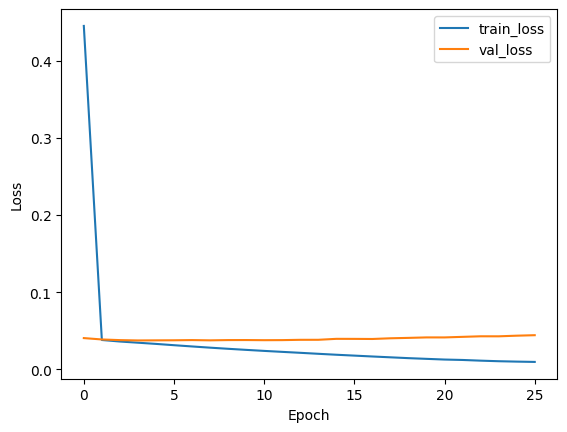

In [142]:
plt.plot(df['epo '],df[' train_loss'])
plt.plot(df['epo '],df[' val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','val_loss'])